In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm import tqdm
import ephem

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PTHS = {
    'sar_pth': '/home/arthur/results/sar_extended/05_addPRIMED/dsg.nc',
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
# Compute beta0
g  = 9.81  # m s-2
qb = 0.02  # kg/kg
L  = 2.5e6 # J/kg
Cp = 1e3   # J/kg/K
# dsg['beta0'] = (dsg.uc ** 2) * Cp * dsg.sst_pmd / (g * qb * L)
dsg['beta0'] = (dsg.uc ** 2) * Cp * dsg.temp_pmd / (g * qb * L)
dsg['beta0_T0'] = (dsg.uc ** 2) * Cp / (g * qb * L)

# # Rel SST
# dsg['rel_sst'] = dsg.sst_pmd - dsg.trop_sst_rms

# dK/dt
### Computing Kinetic Energy
V34         = 17.5 # m/s
g           = 9.8  # m/s^2
rho         = 1.15 # kg/m^3
theta_ratio = 1e-2 # []
# Below, dK/dt is expressed in J/hr, where 1J = 1 kg m^2 s^-2
dsg['dKdt'] = (rho * V34 ** 2 / (g * theta_ratio)) * 2 * (dsg['r34'] * dsg['vmx']) * ((dsg['vmx_dot_smth_ibt'] / 3600) * (dsg['r34']) + (dsg['r34_dot_smth_ibt'] * 1000 / 3600) * dsg['vmx'])
nrm         = 1e15
dsg['dKdt'] = dsg['dKdt'] / nrm # now in PJ/hr

# Group by basin
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016

for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0]

100%|██████████████████████████████████████| 1208/1208 [00:03<00:00, 317.80it/s]


In [4]:
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 33)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

332


In [ ]:
# 1) vmx, rmx, fcor, R34/R50/R64 + comparison with best-track data
# 2) B, rossby, Uc, R+, R0, eventually V+ and V0.
# By basin and by t(LMI)

In [75]:
d

<xarray.Dataset>
Dimensions:              (time: 332)
Coordinates:
  * time                 (time) datetime64[ns] 2013-07-01T10:41:57 ... 2024-0...
Data variables: (12/76)
    dist2coast           (time) float64 8.115e+04 1.202e+05 ... 1.521e+05
    speed                (time) float64 5.97 6.619 5.511 ... 9.435 7.474 5.392
    name                 (time) object RUMBIA WUTIP RAMMASUN ... EWINIAR AMPIL
    id                   (time) object wp062013 wp202013 ... wp012024 wp082024
    file                 (time) object rs2--owi-cm-20130701t104119-20130701t1...
    file_tcva            (time) object rs2--owi-ca-20130701t104119-20130701t1...
    ...                   ...
    beta0_pmd            (time) float64 1.349e+04 1.583e+04 ... 1.333e+04
    beta0_T0_pmd         (time) float64 52.55 59.07 51.1 ... 64.62 63.96 51.02
    beta0                (time) float64 411.3 623.0 532.1 ... 601.3 569.8 750.0
    beta0_T0             (time) float64 1.566 2.378 2.022 ... 2.289 2.171 2.842
    dKdt                 (time) float64 -0.03188 0.7363 -0.1493 ... 0.0788 nan
    basin_idx            (time) float64 3.0 3.0 3.0 3.0 2.0 ... 3.0 3.0 3.0 3.0
Attributes:
    Version:            1.0
    SAR_wind_product:   Ifremer (https://cyclobs.ifremer.fr/app/tropical), co...
    Best_track_data:    IBTrACS (https://www.ncei.noaa.gov/products/internati...
    SST_product:        REMSS, collocated with tropical cyclones during MAXSS...
    Authors:            Arthur Avenas, Alexis Mouche, Théo Cevaer
    Contact:            arthur.avenas@esa.int
    TC-PRIMED_product:  Version v01r01-preliminary, created 2024-09-08T06:24:...

### 1) Preliminary diagnostic

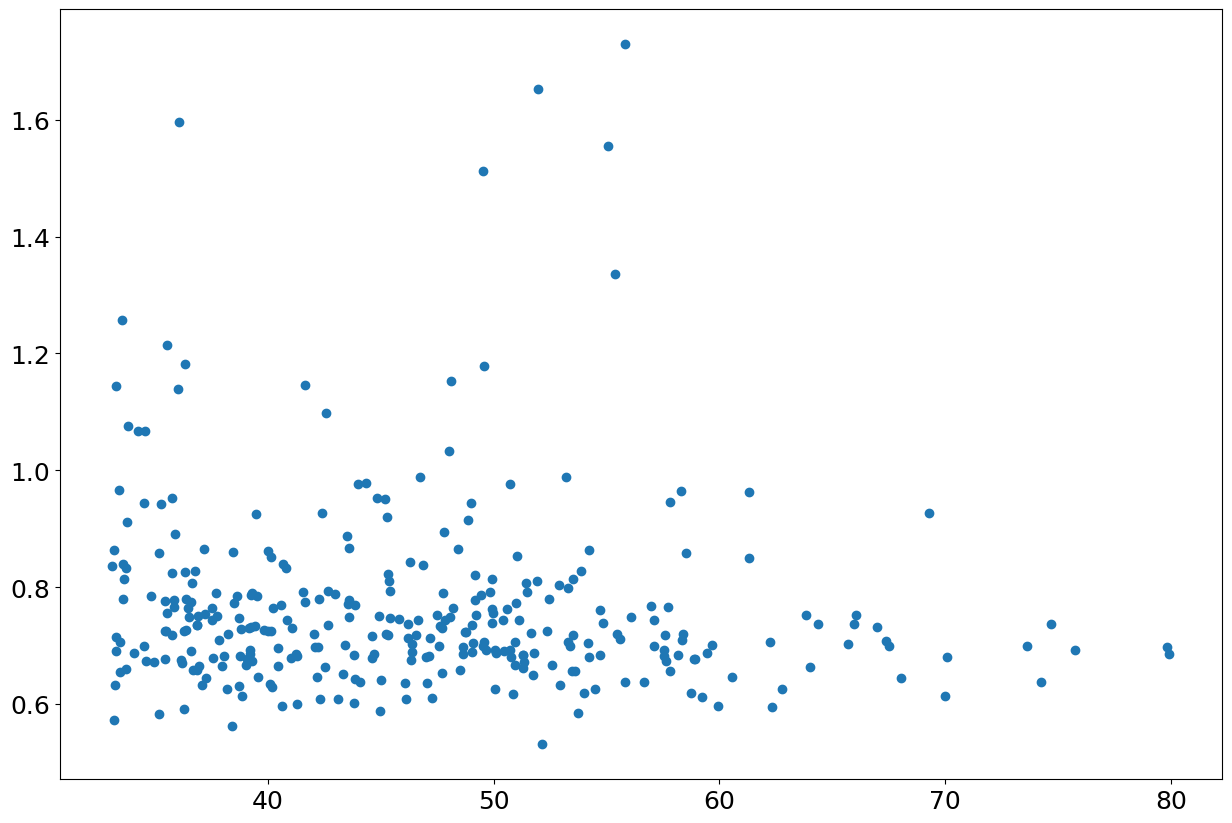

In [5]:
plt.scatter(d.vmx, d.beta0_pmd / 20000)

Text(0, 0.5, 'beta0 SAR')

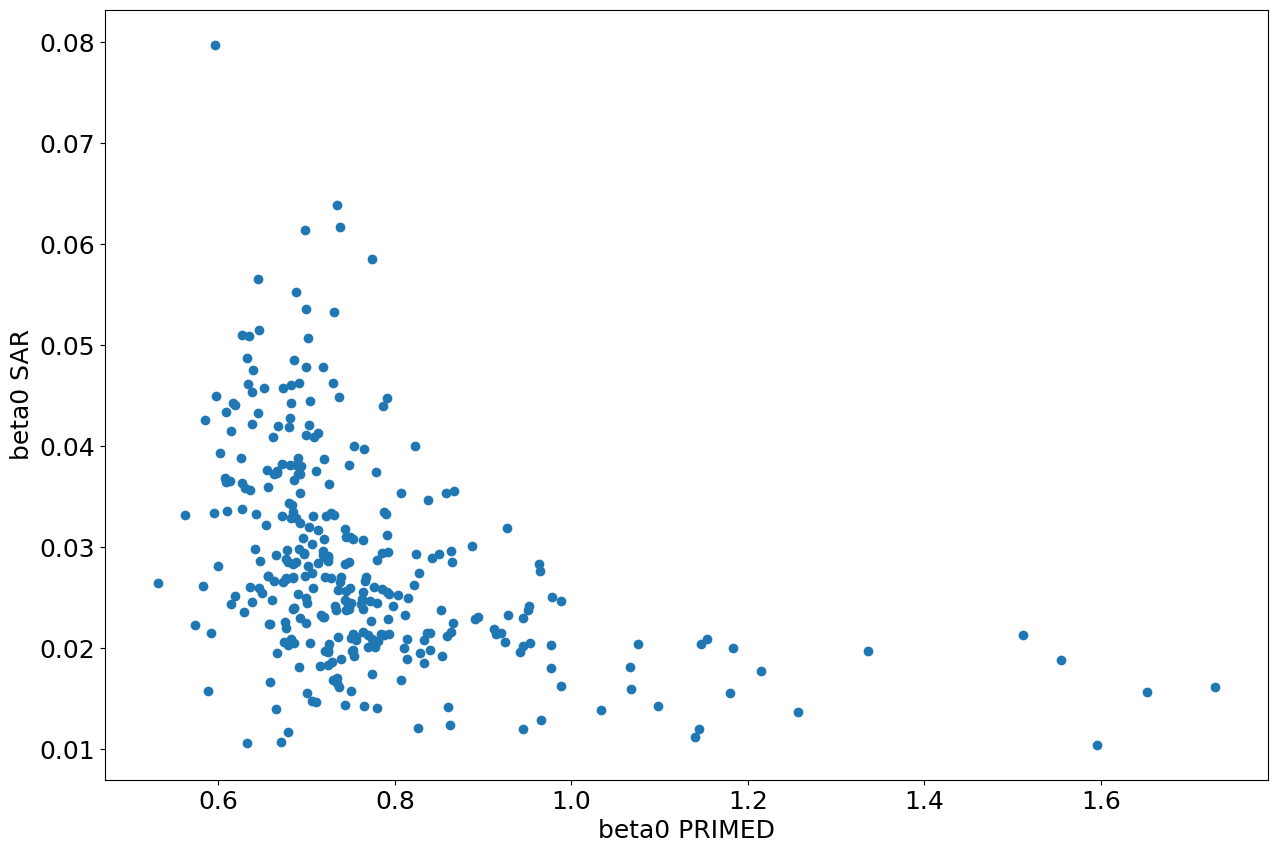

In [6]:
plt.scatter(d.beta0_pmd / 20000, d.beta0 / 20000)
plt.xlabel('beta0 PRIMED')
plt.ylabel('beta0 SAR')
# plt.xlim(0, 1)

Text(0, 0.5, 'beta0 SAR')

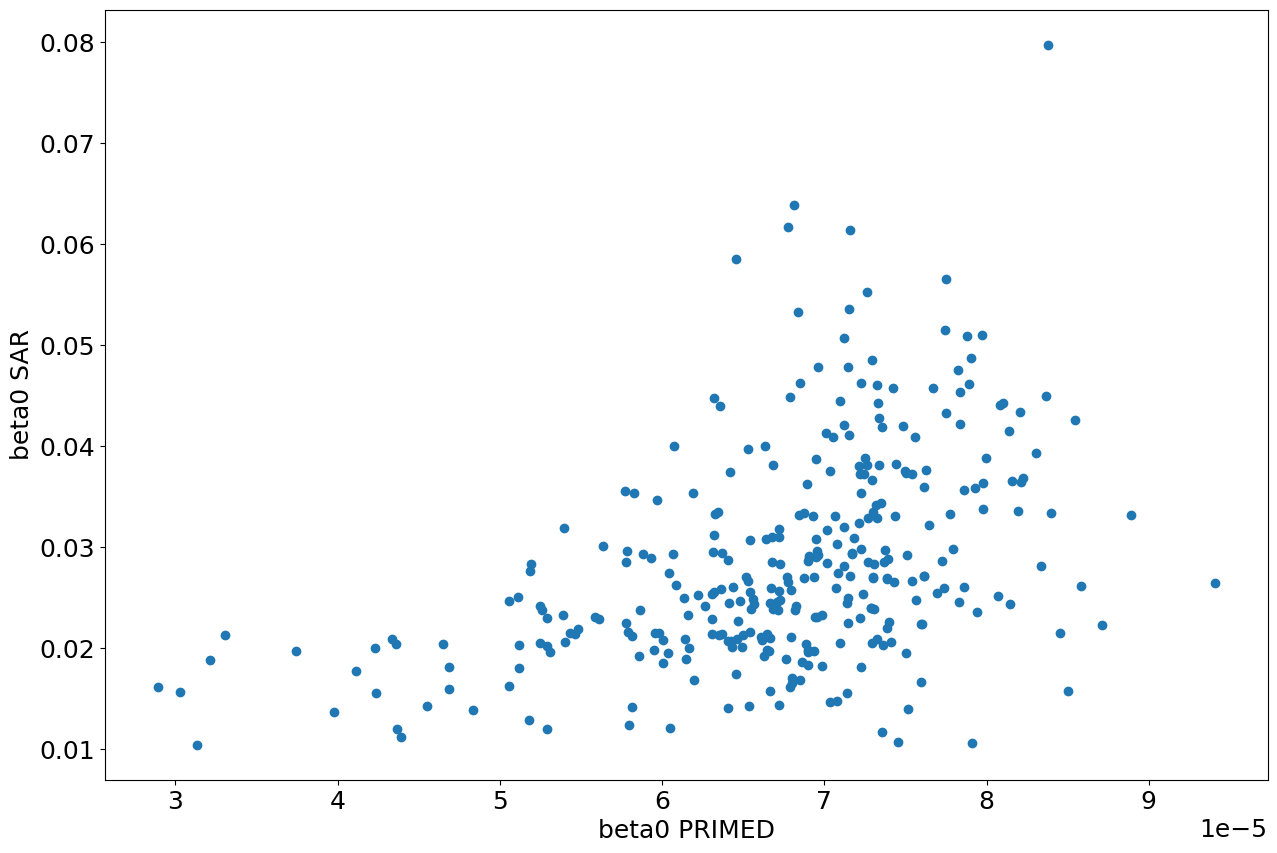

In [7]:
plt.scatter(1/ d.beta0_pmd, d.beta0 / 20000)
plt.xlabel('beta0 PRIMED')
plt.ylabel('beta0 SAR')
# plt.xlim(0, 1)

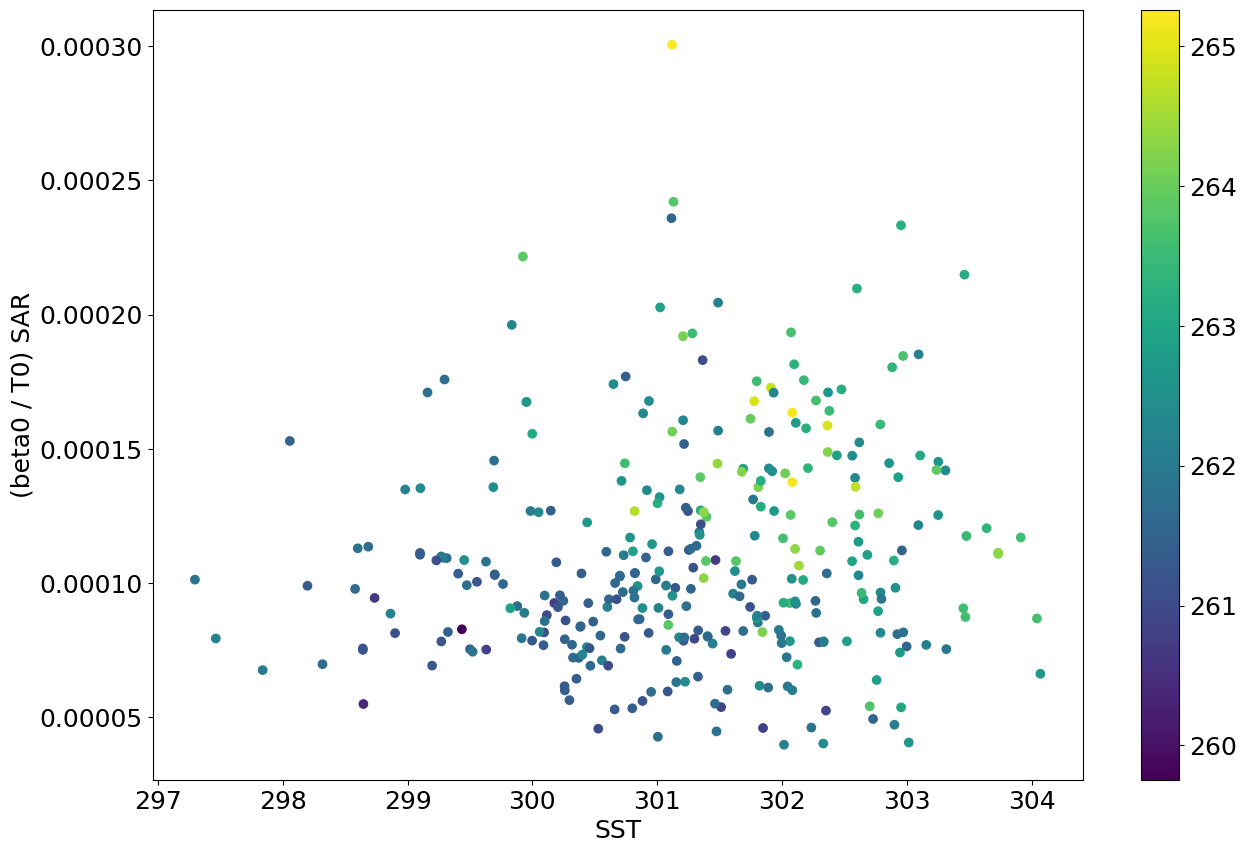

In [8]:
plt.scatter(d.sst_rms, d.beta0_T0 / 20000, c=d.temp_pmd)
plt.xlabel('SST')
plt.ylabel('(beta0 / T0) SAR')
plt.colorbar()
# plt.xlim(0, 1)

In [9]:
# plt.scatter(d.beta0_T0_pmd / 20000, d.beta0_T0 / 20000)
# plt.xlabel('beta0 / T0 PRIMED')
# plt.ylabel('beta0 / T0 SAR')
# # plt.xlim(0, 0.005)

Text(0, 0.5, 'Holland B')

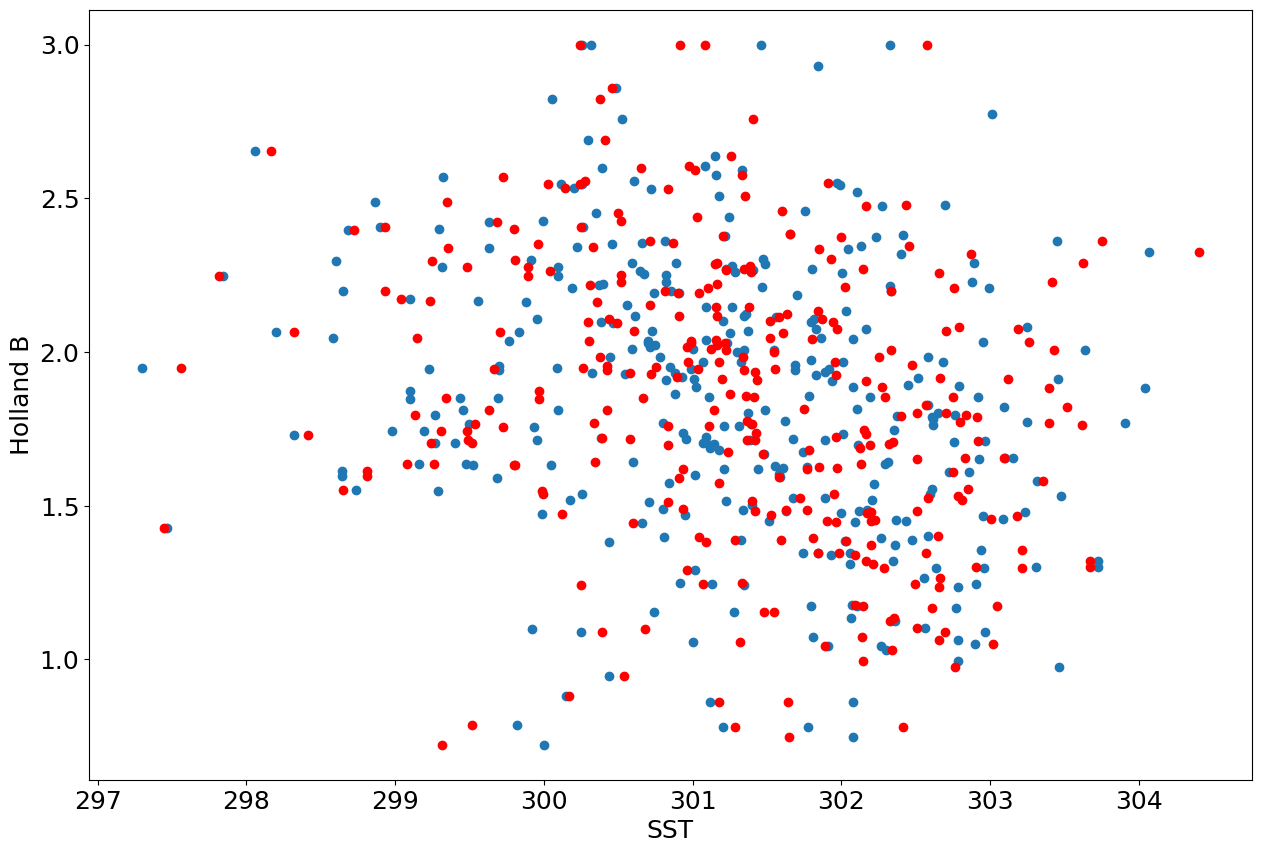

In [10]:
plt.scatter(d.sst_rms, d.B_hol)
plt.scatter(d.sst_pmd, d.B_hol, c='r')
plt.xlabel('SST')
plt.ylabel('Holland B')

Text(0, 0.5, 'Holland B')

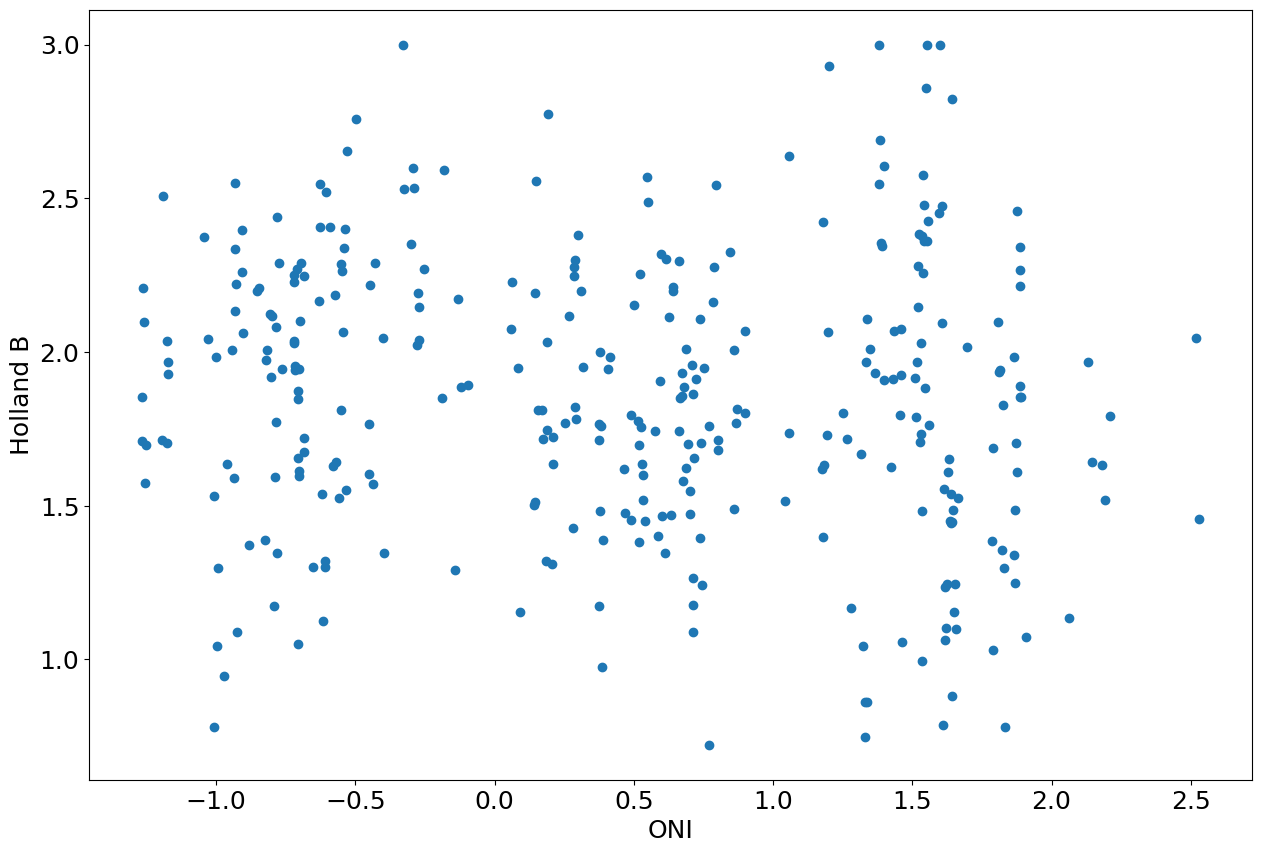

In [11]:
plt.scatter(d.oni_psl, d.B_hol)
plt.xlabel('ONI')
plt.ylabel('Holland B')

Text(0, 0.5, 'R34')

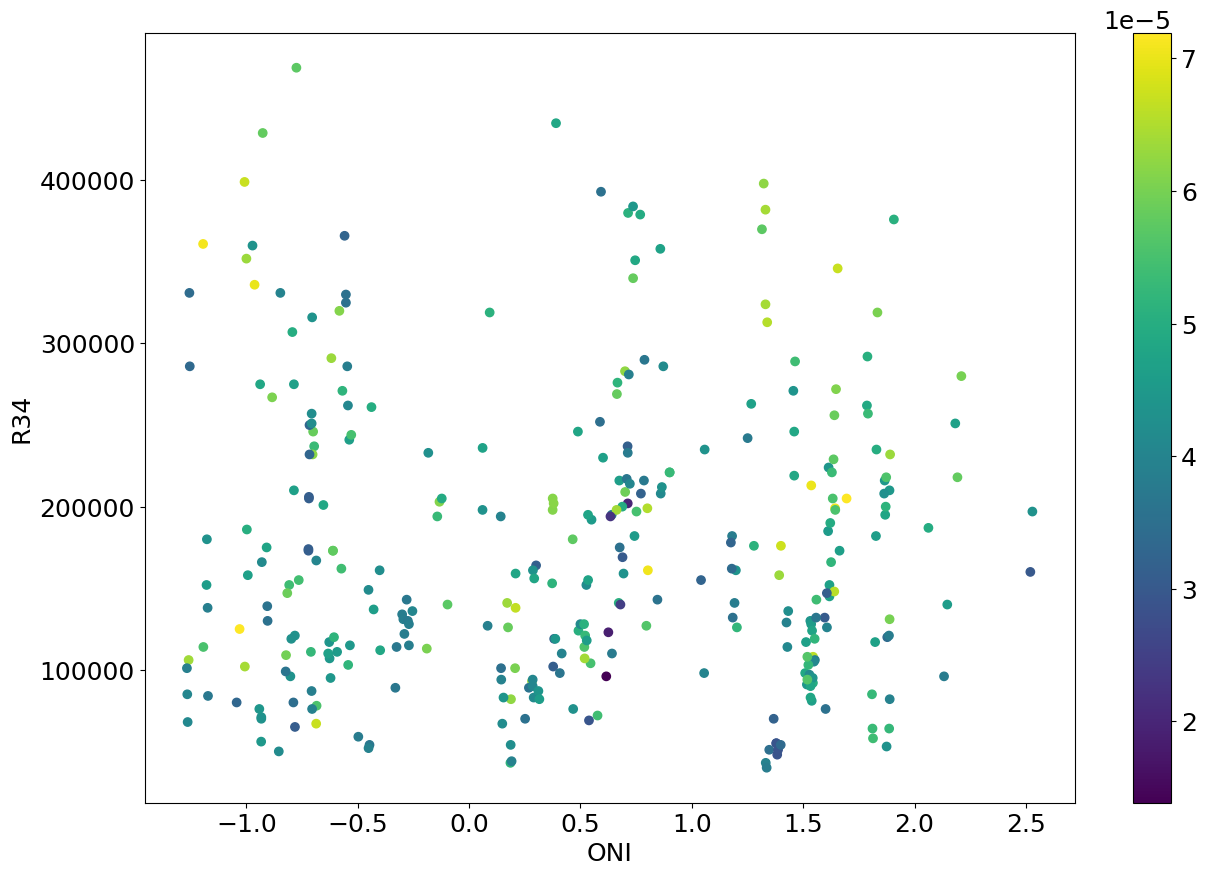

In [12]:
plt.scatter(d.oni_psl, d.r34, c=abs(d.fcor))
plt.colorbar()
plt.xlabel('ONI')
plt.ylabel('R34')

Text(0, 0.5, 'R34')

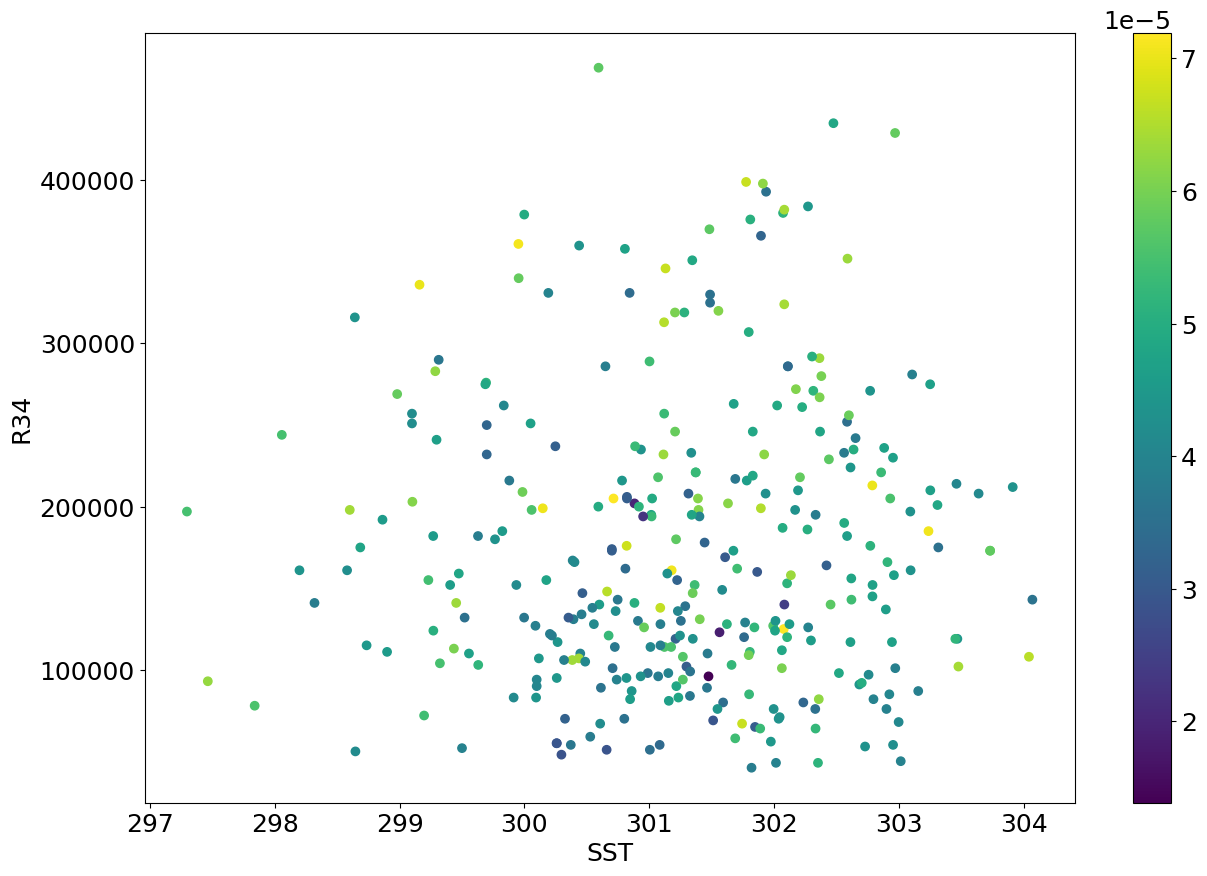

In [13]:
plt.scatter(d.sst_rms, d.r34, c=abs(d.fcor))
plt.colorbar()
plt.xlabel('SST')
plt.ylabel('R34')

(array([34., 96., 91., 49., 29., 16.,  5.,  3.,  0.,  1.]),
 array([0.01388159, 0.02312359, 0.0323656 , 0.04160761, 0.05084961,
        0.06009162, 0.06933362, 0.07857563, 0.08781764, 0.09705964,
        0.10630165]),
 <BarContainer object of 10 artists>)

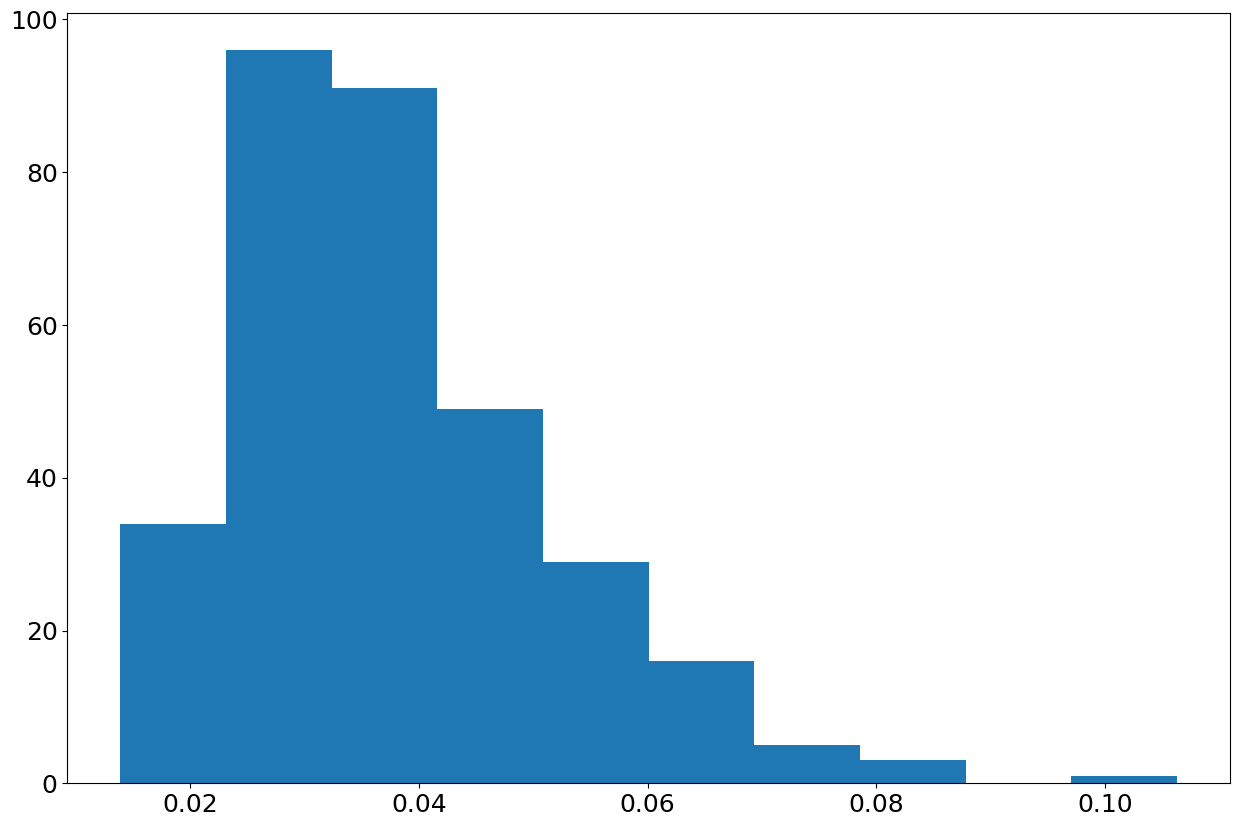

In [14]:
plt.hist(d.beta0 / 15000)

### 2) Variation by basin

/tmp/ipykernel_17544/3892731901.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


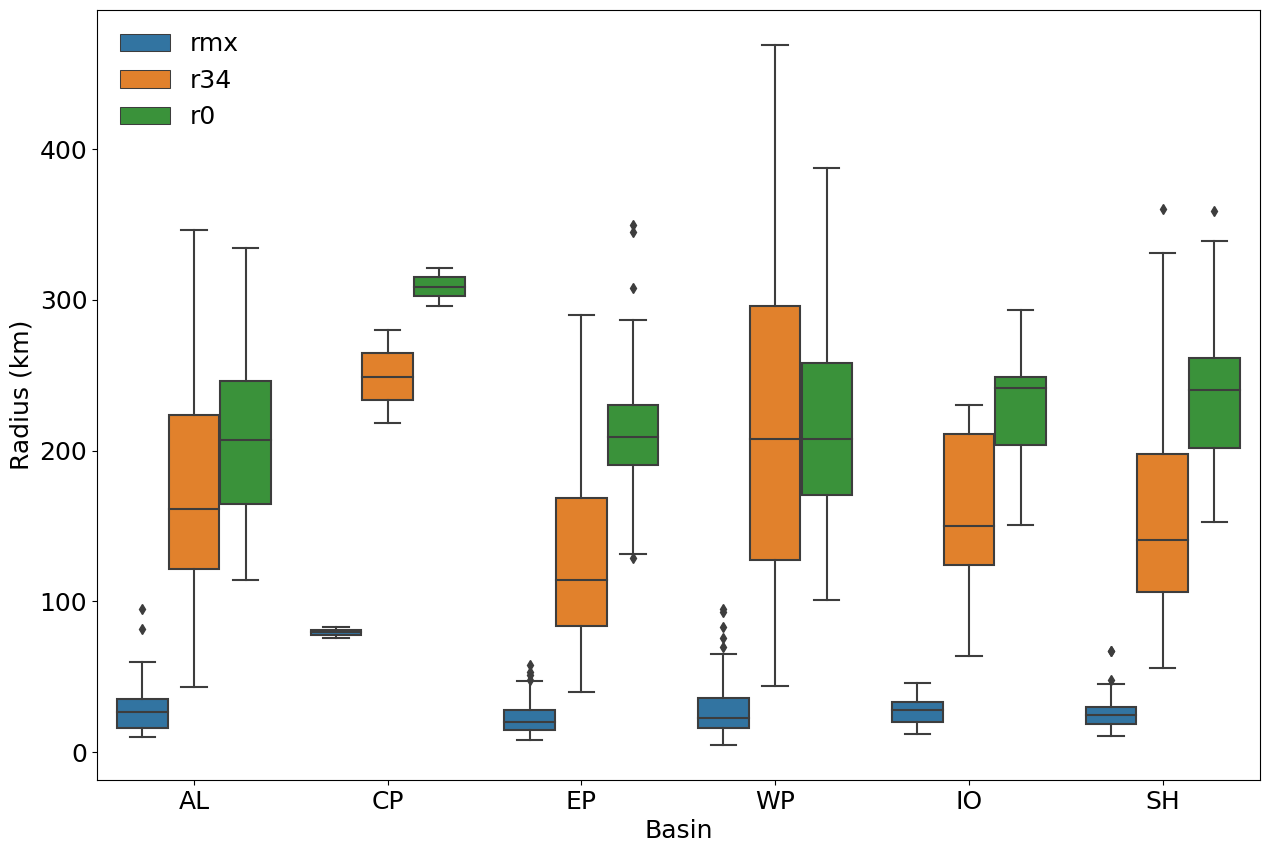

In [15]:
df      = d[['basin_idx', 'rmx', 'r34', 'r0']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['rmx', 'r34', 'r0'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks() / 1000]
g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Radius (km)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

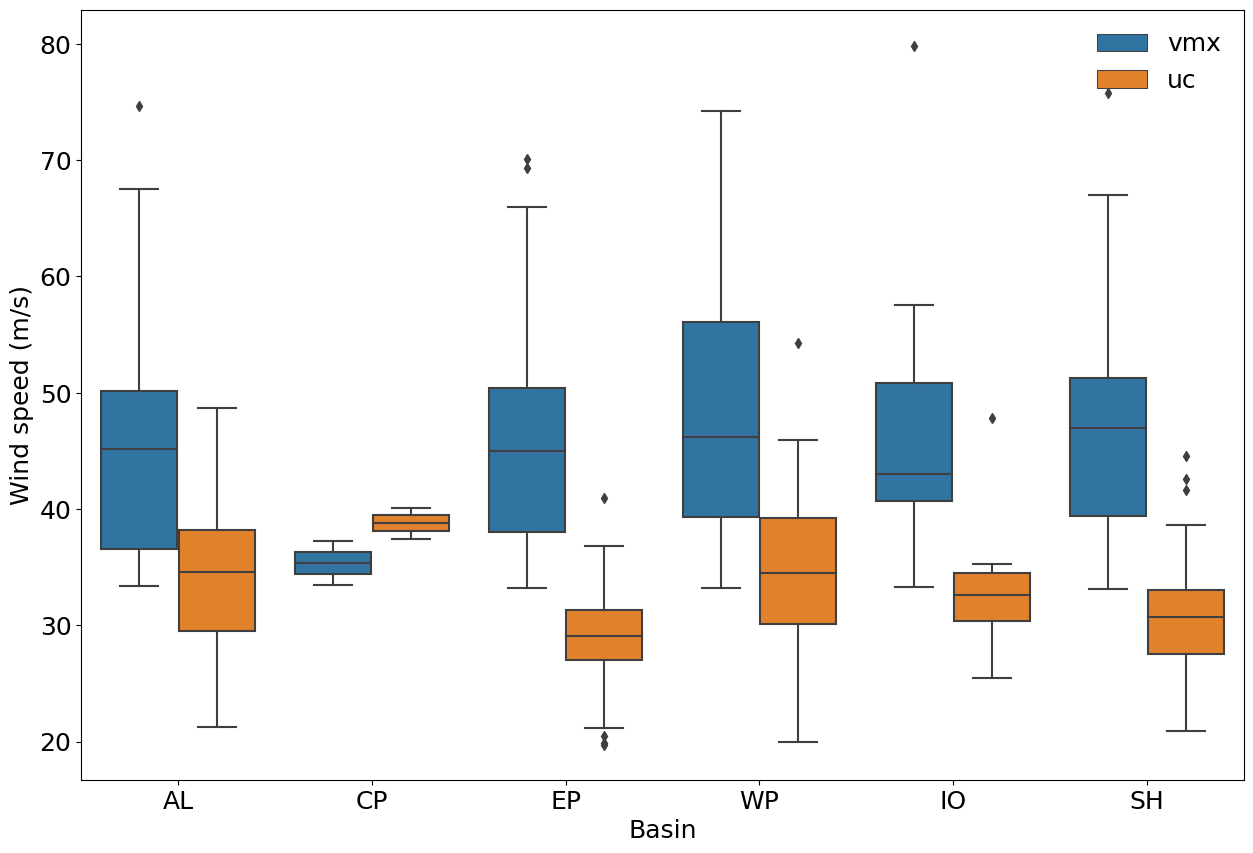

In [16]:
df      = d[['basin_idx', 'vmx', 'uc']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['vmx', 'uc'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Wind speed (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper right')

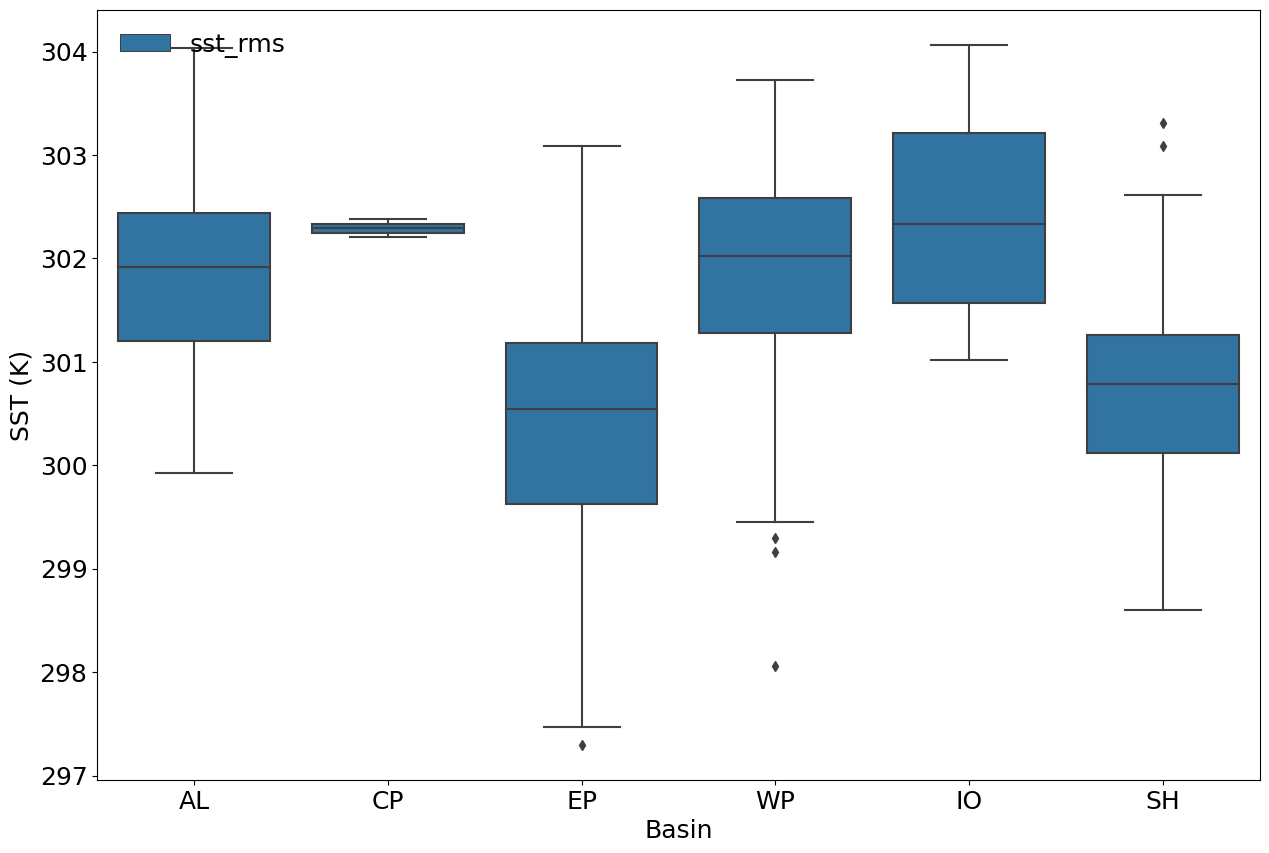

In [17]:
df      = d[['basin_idx', 'sst_rms']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['sst_rms'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('SST (K)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

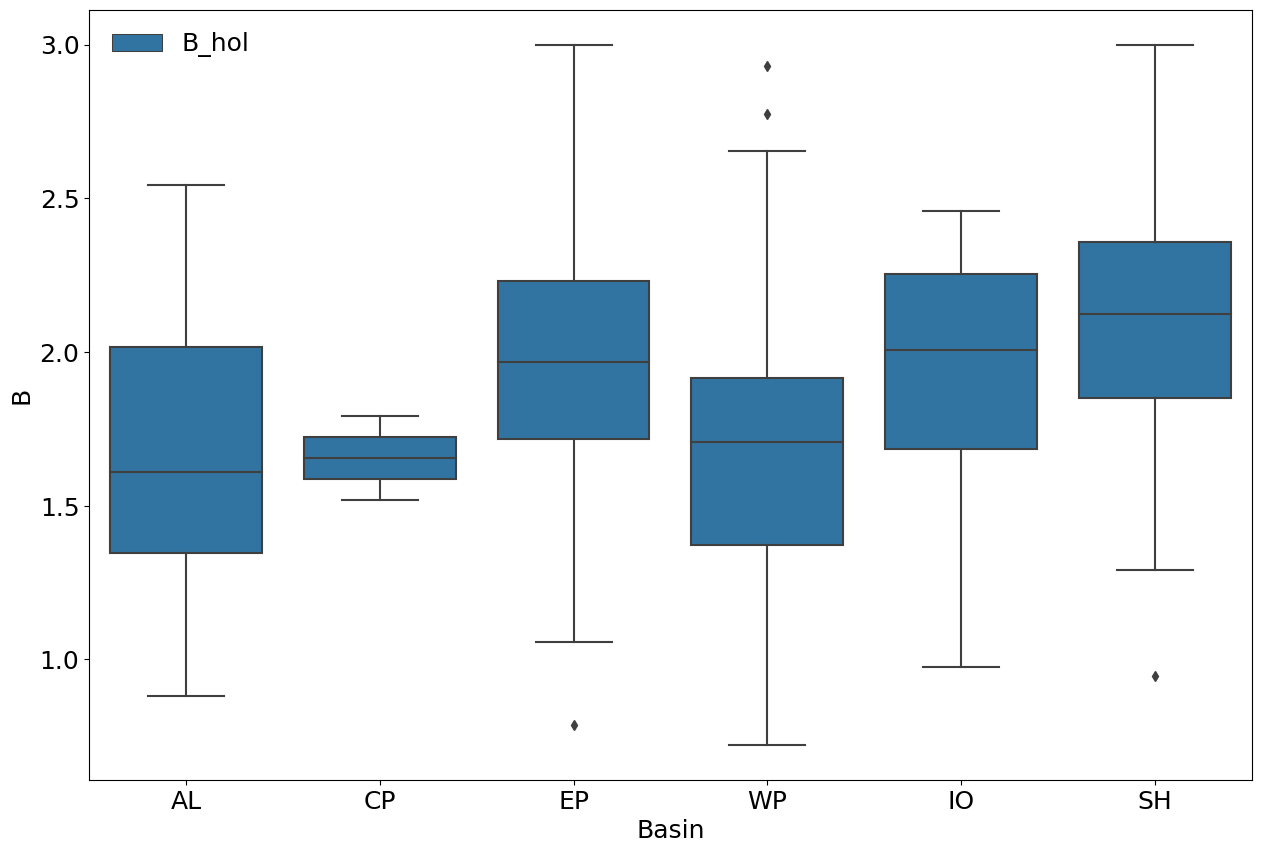

In [18]:
df      = d[['basin_idx', 'B_hol']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['B_hol'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('B')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

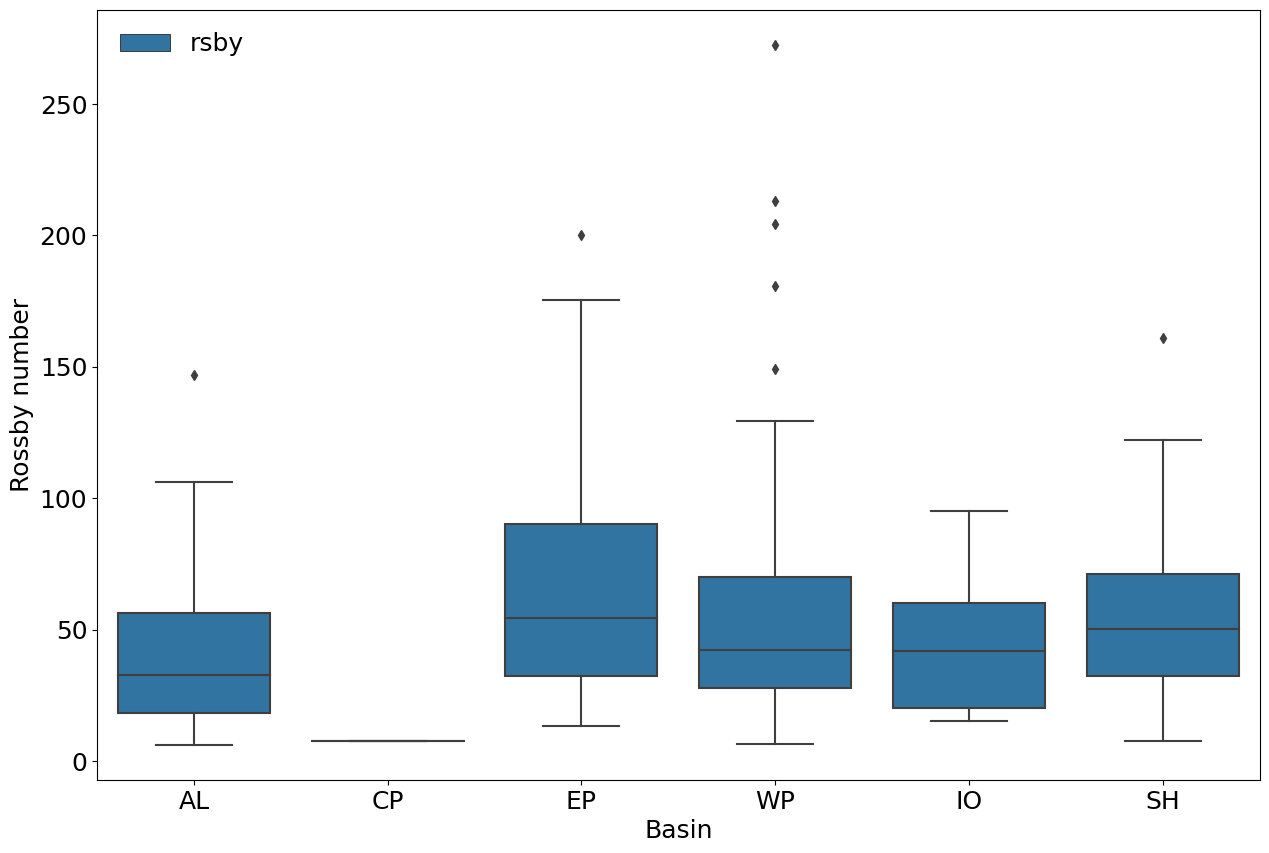

In [19]:
df      = d[['basin_idx', 'rsby']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['rsby'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Rossby number')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

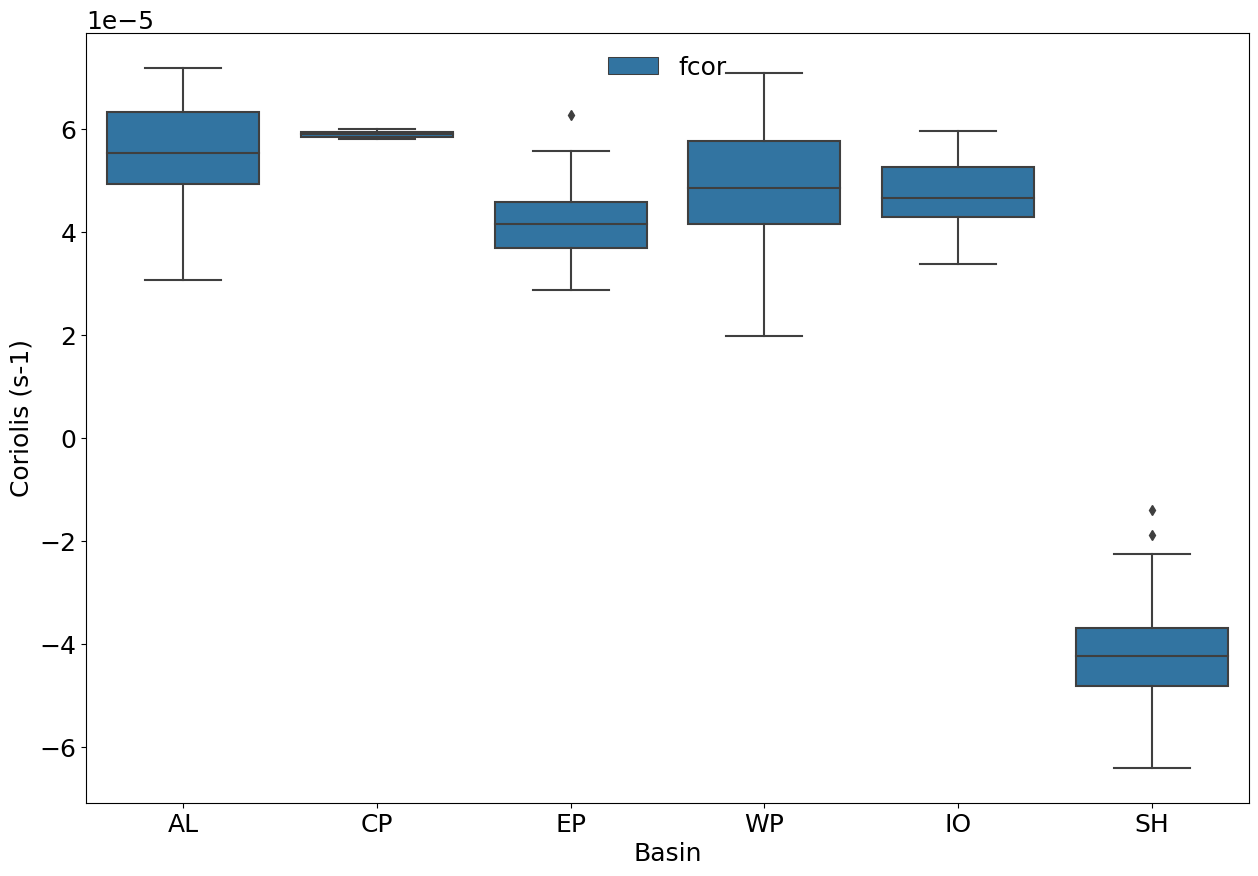

In [20]:
df      = d[['basin_idx', 'fcor']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['fcor'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Coriolis (s-1)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper center')

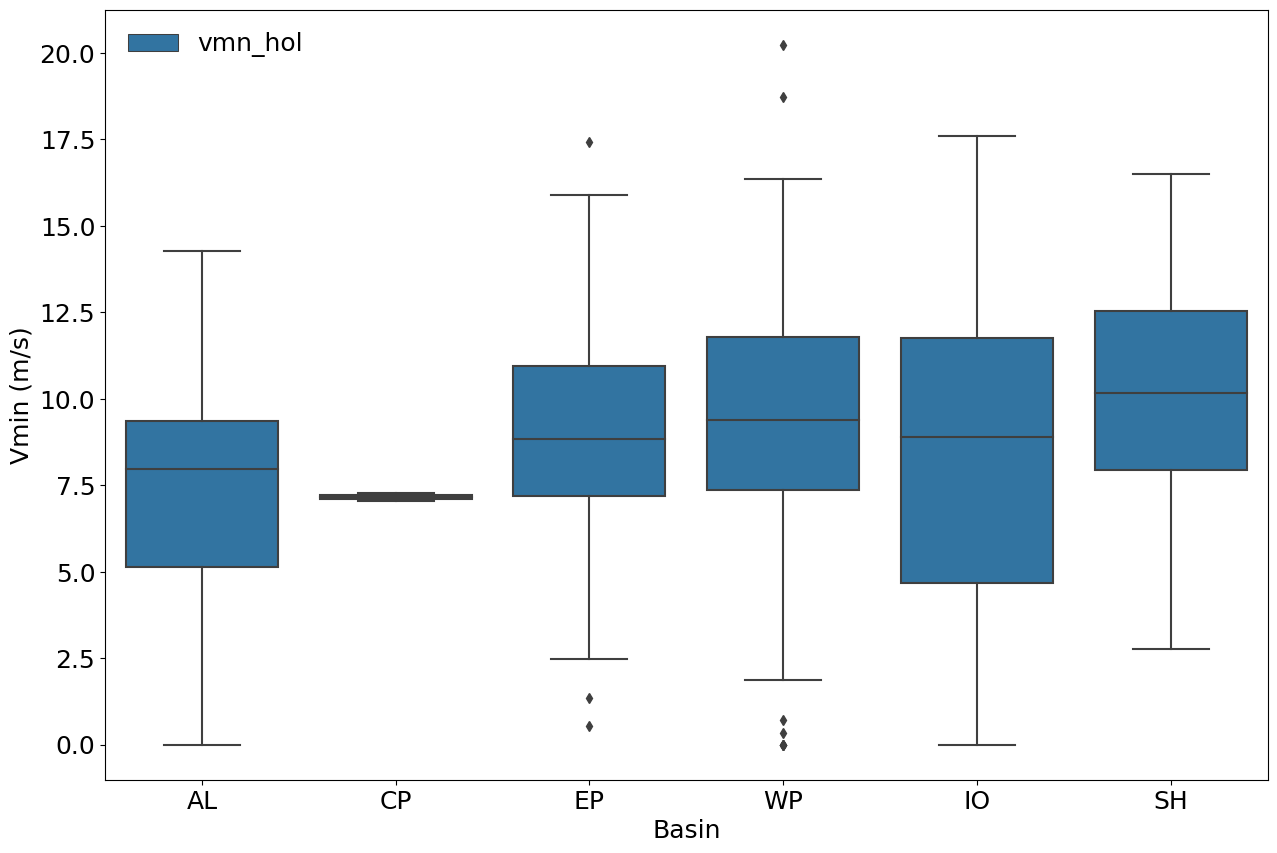

In [21]:
df      = d[['basin_idx', 'vmn_hol']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['vmn_hol'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Vmin (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

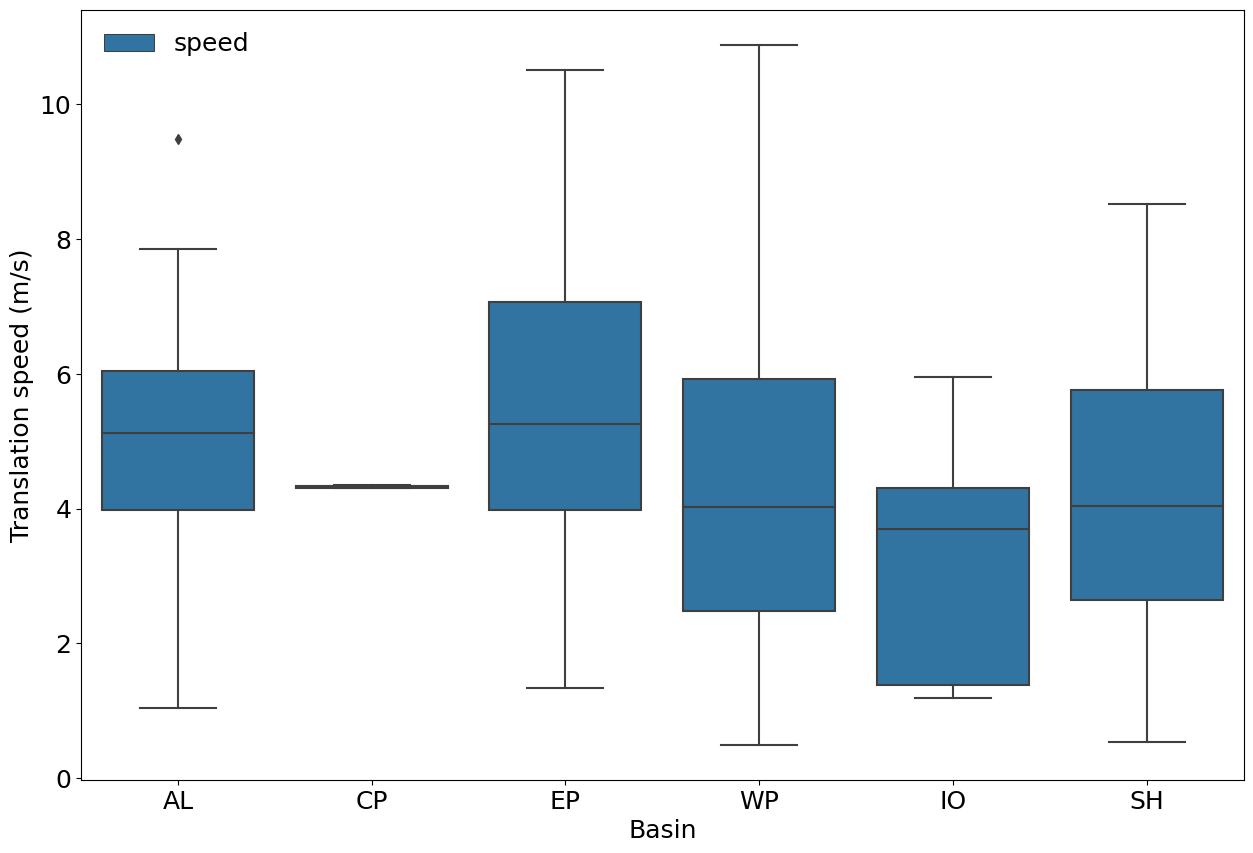

In [22]:
df      = d[['basin_idx', 'speed']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['speed'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('Translation speed (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper left')

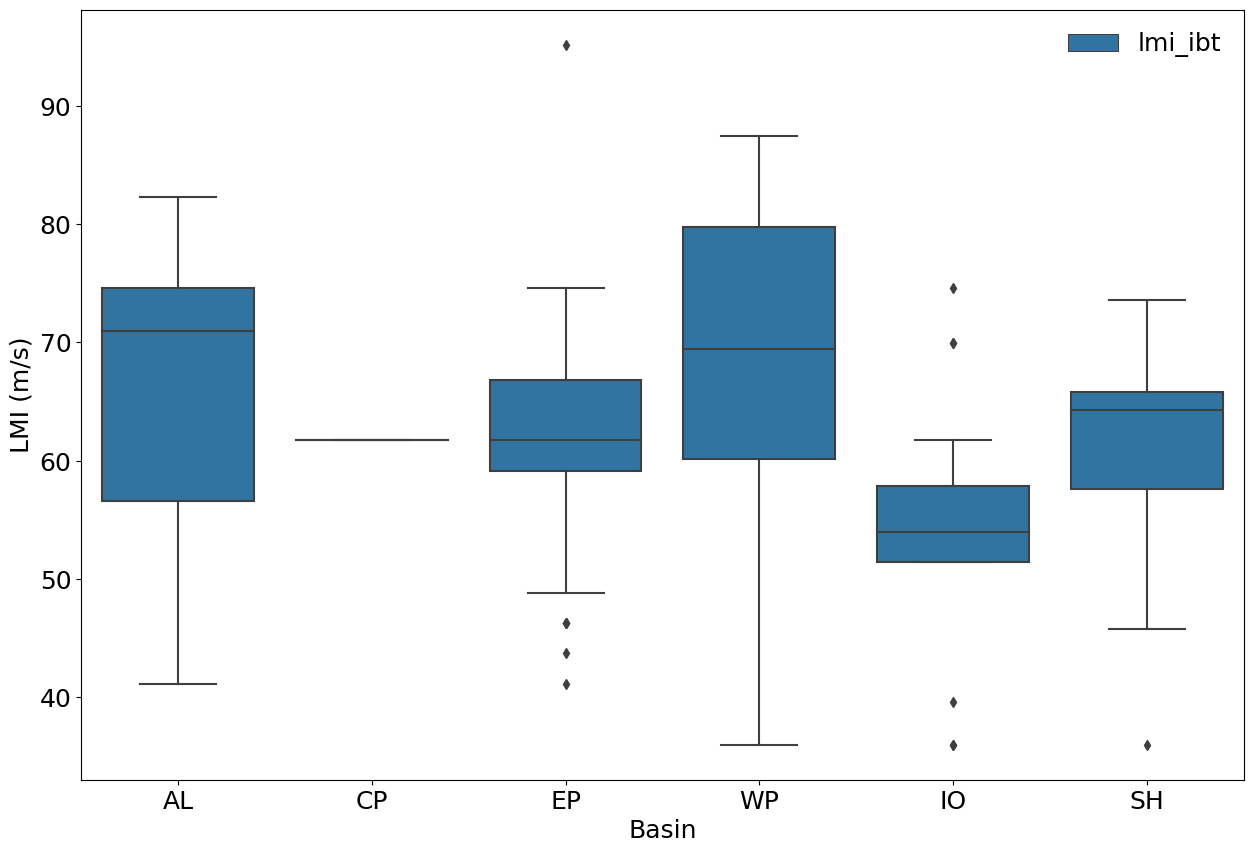

In [23]:
df      = d[['basin_idx', 'lmi_ibt']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['lmi_ibt'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
# ylabels = ['{:,.0f}'.format(y) for y in g.get_yticks()]
# g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('LMI (m/s)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper right')

/tmp/ipykernel_17544/2202944619.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


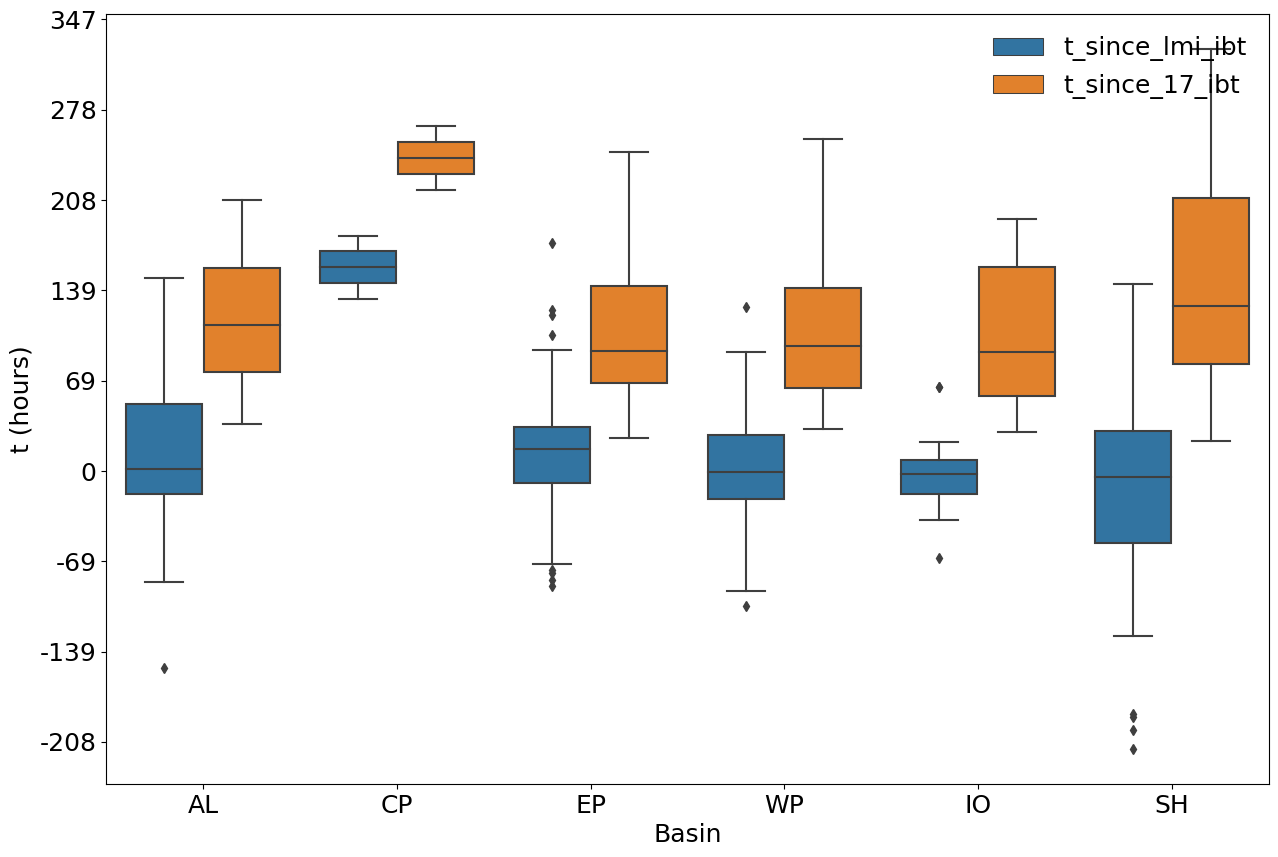

In [24]:
df      = d[['basin_idx', 't_since_lmi_ibt', 't_since_17_ibt']].to_dataframe()
df_plot = df.melt(id_vars='basin_idx', value_vars=['t_since_lmi_ibt', 't_since_17_ibt'])

g = sns.boxplot(x='basin_idx', y='value', hue='variable', data=df_plot)

# Labels
xlabels = [basin_keys[round(float(l.get_text()))].upper() for l in g.get_xticklabels()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y / 3600) for y in g.get_yticks()]
g.set_yticklabels(ylabels)

# Legend
g.set_xlabel('Basin')
g.set_ylabel('t (hours)')
# plt.yscale('log')
plt.legend(frameon=False, loc='upper right')

### 3) Dependance by basin

In [25]:
da = d.where(d.basin == 'al', drop=True)
dc = d.where(d.basin == 'cp', drop=True)
de = d.where(d.basin == 'ep', drop=True)
di = d.where(d.basin == 'io', drop=True)
ds = d.where(d.basin == 'sh', drop=True)
dw = d.where(d.basin == 'wp', drop=True)

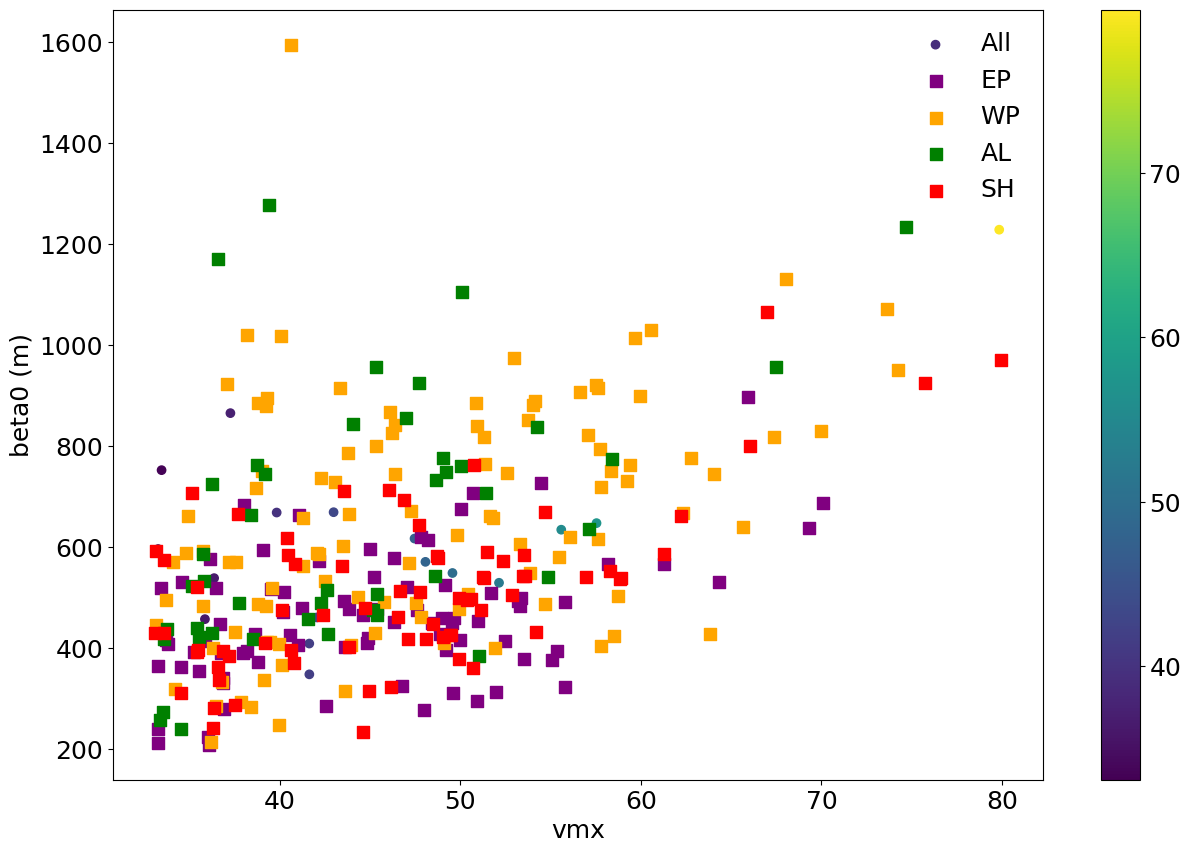

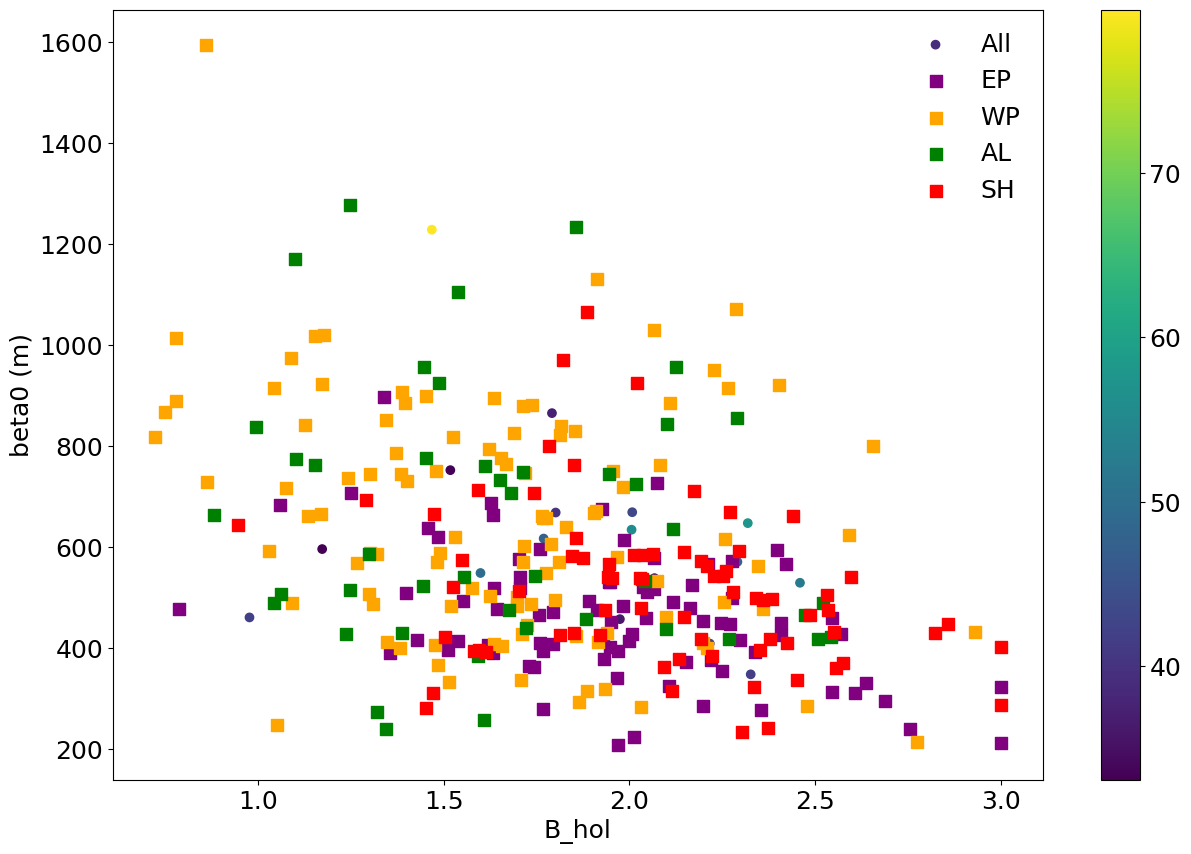

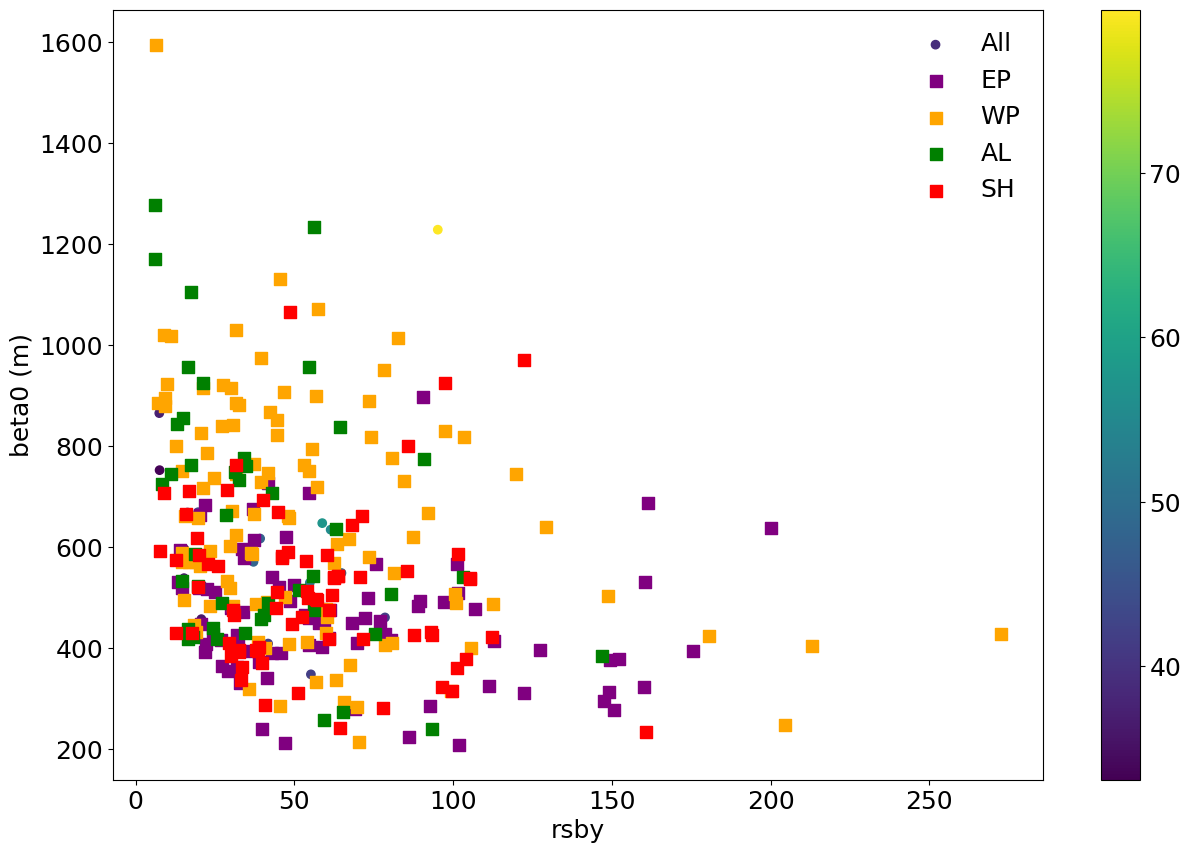

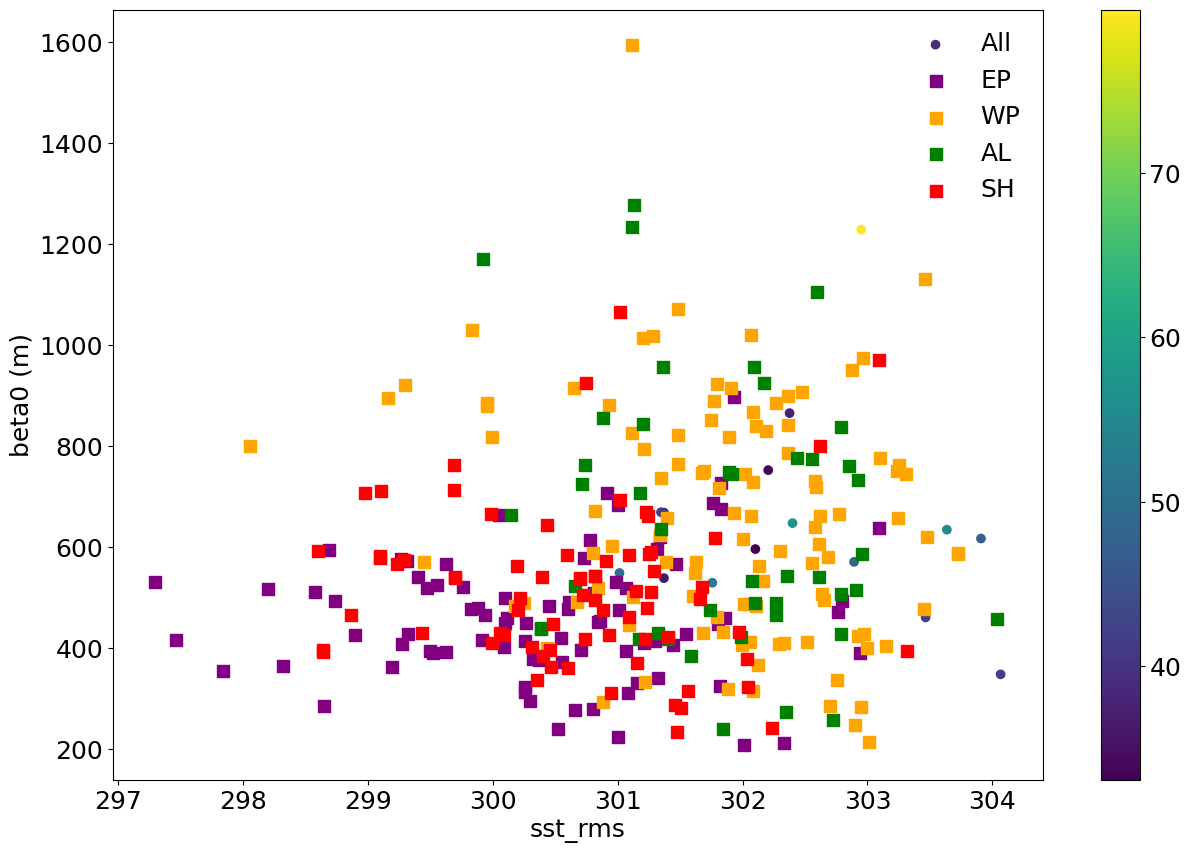

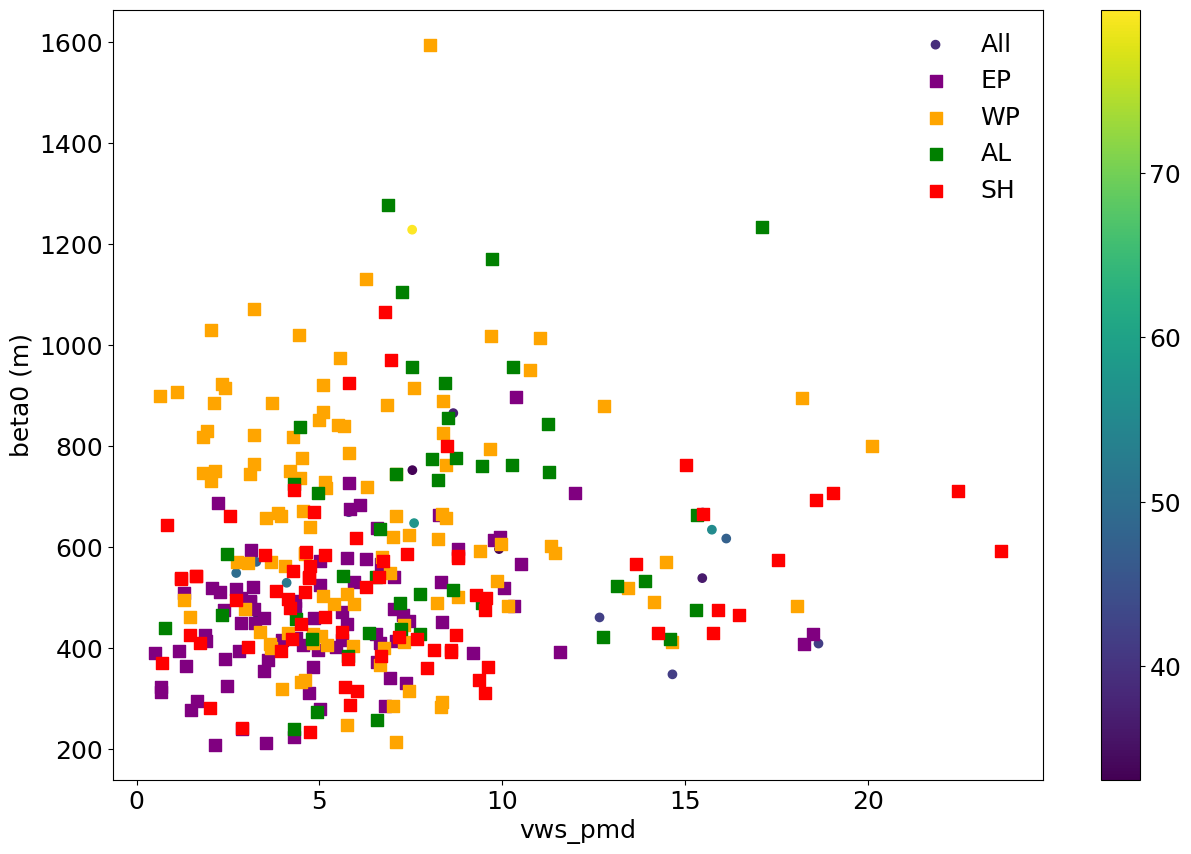

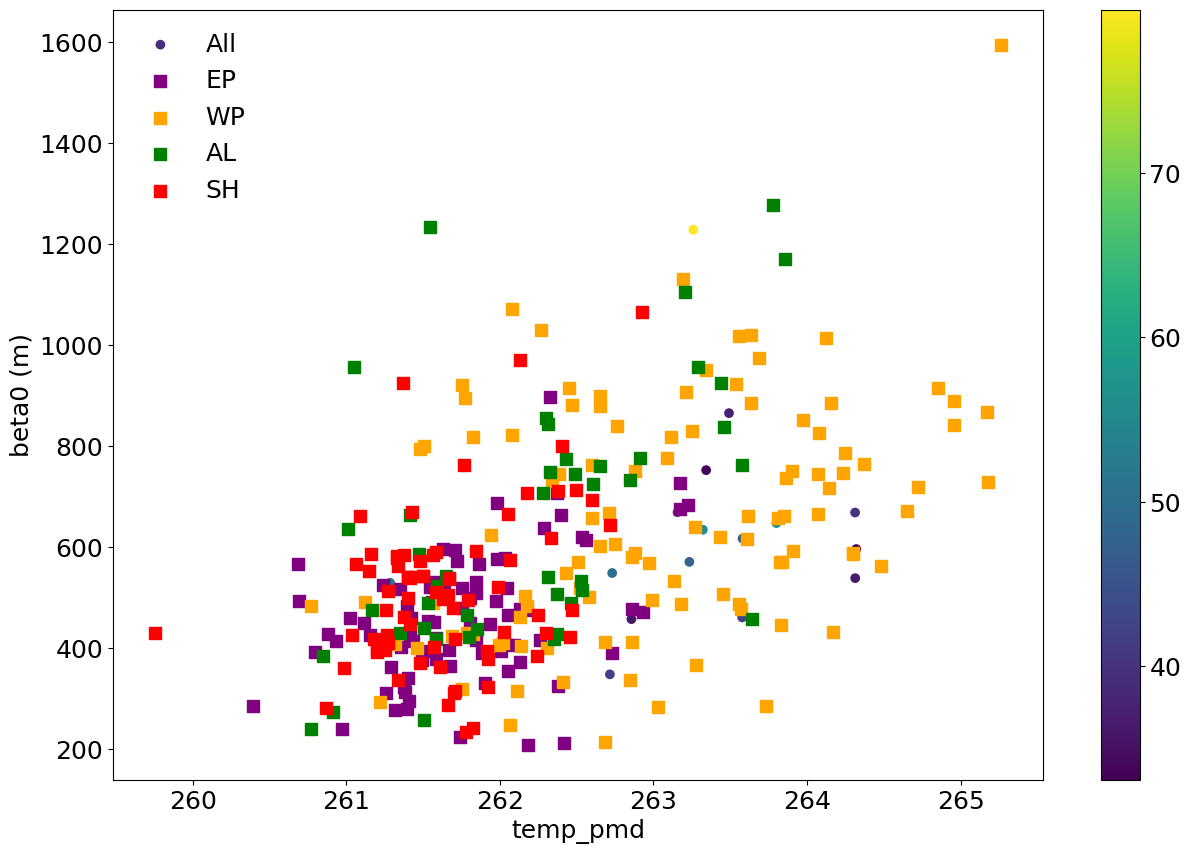

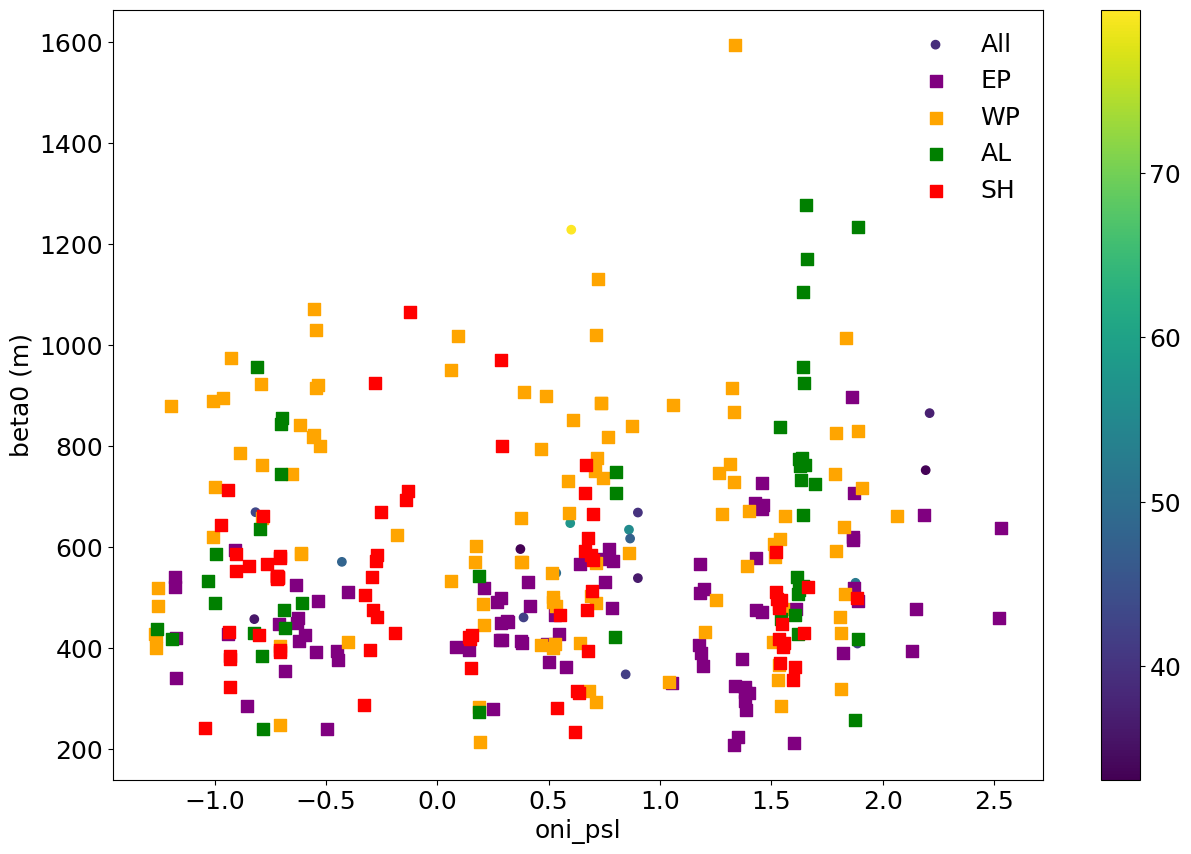

In [26]:
for prm in ['vmx', 'B_hol', 'rsby', 'sst_rms', 'vws_pmd', 'temp_pmd', 'oni_psl']:
    plt.scatter(d[prm],  d.beta0,  c=d.vmx,                      label='All')
    plt.colorbar()
    plt.scatter(de[prm], de.beta0, c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw.beta0, c='orange', marker='s', s=80, label='WP')
    plt.scatter(da[prm], da.beta0, c='green',  marker='s', s=80, label='AL')
    plt.scatter(ds[prm], ds.beta0, c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('beta0 (m)')
    plt.show()

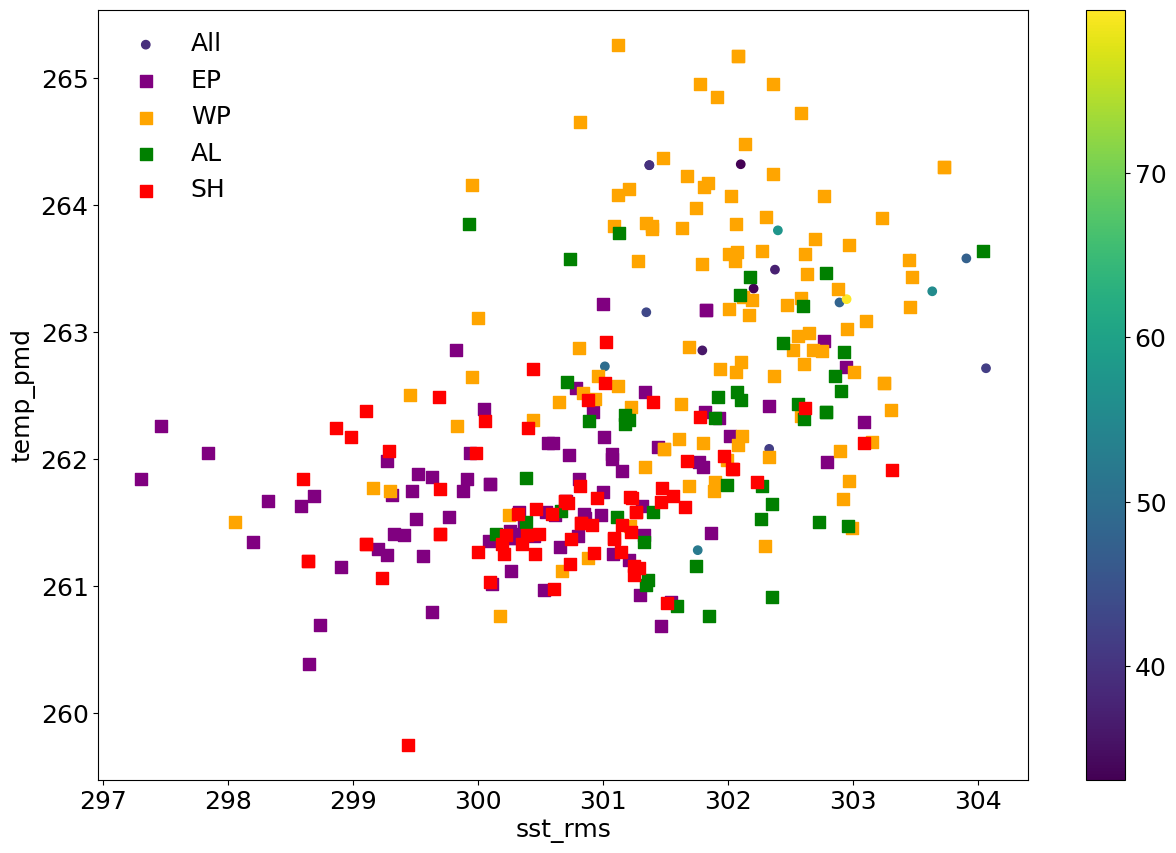

In [27]:
y = 'temp_pmd'

for prm in ['sst_rms']:
    plt.scatter(d[prm],  d[y],  c=d.vmx,                      label='All')
    plt.colorbar()
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel(y)
    plt.show()

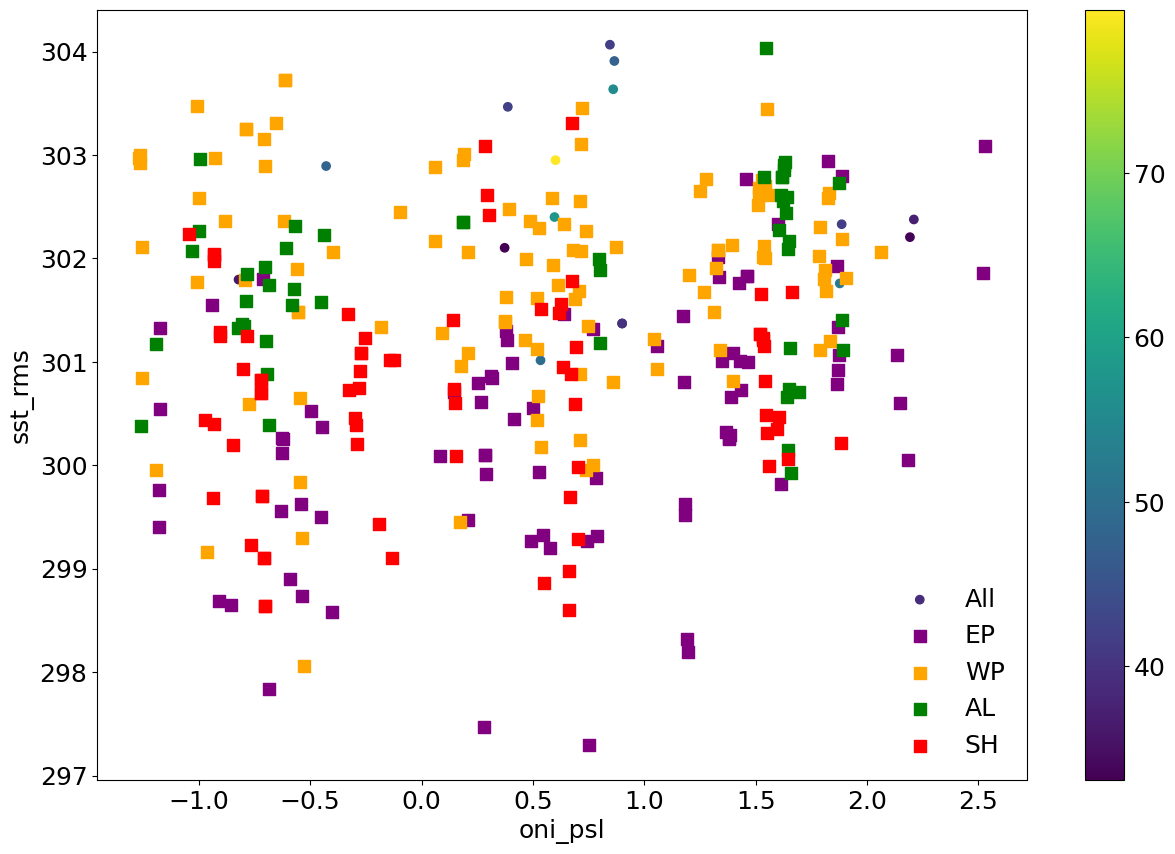

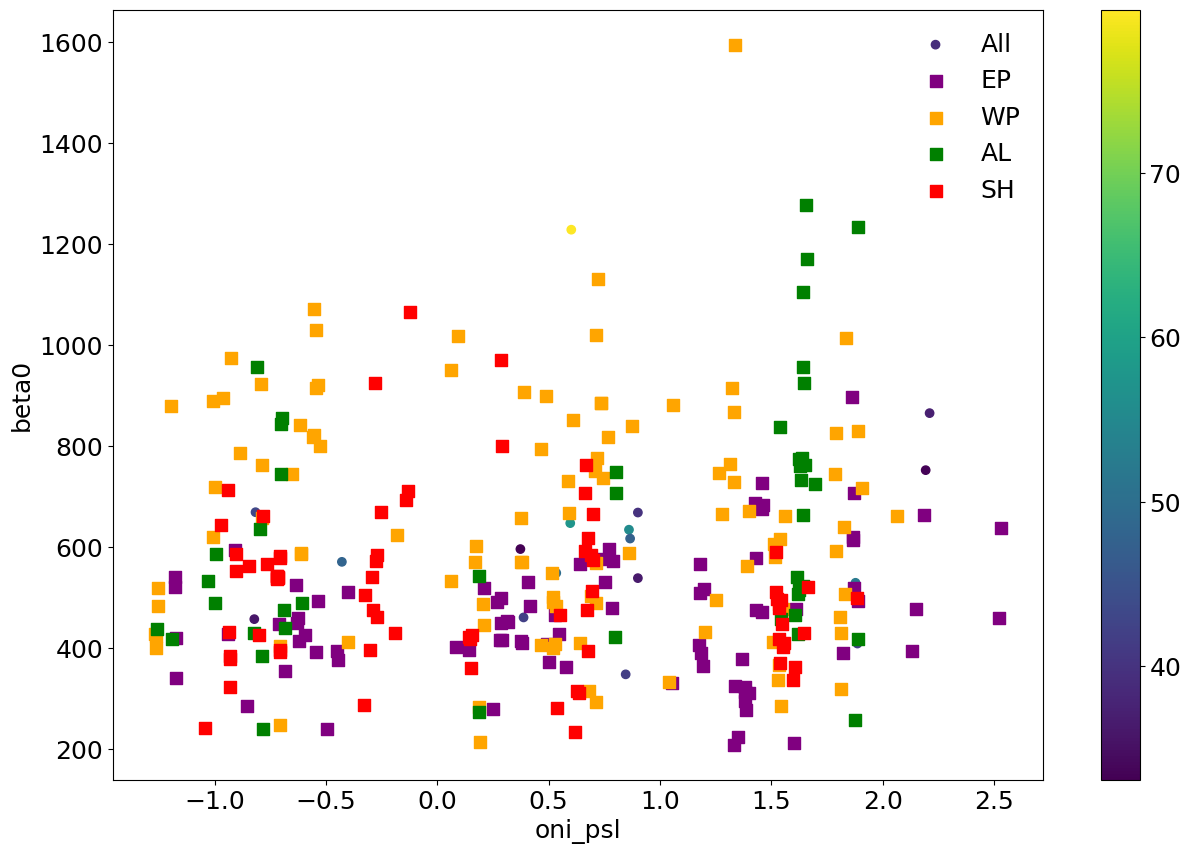

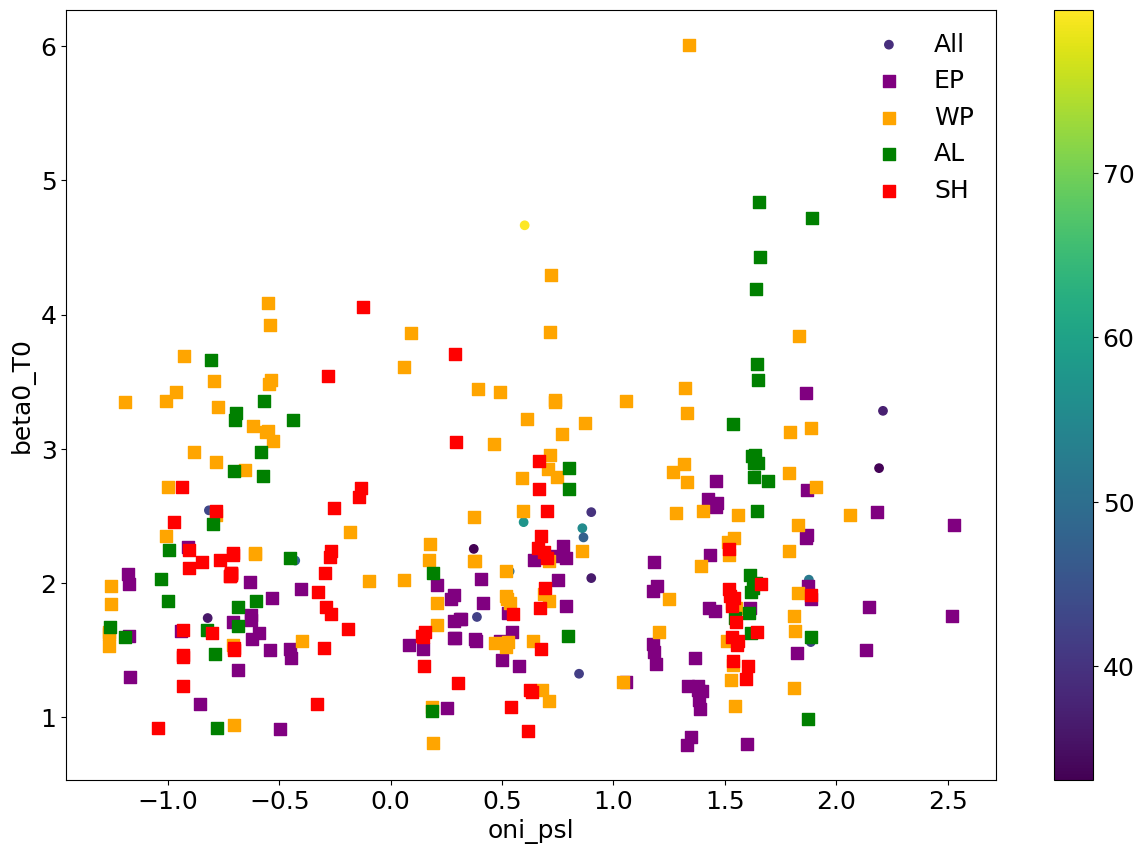

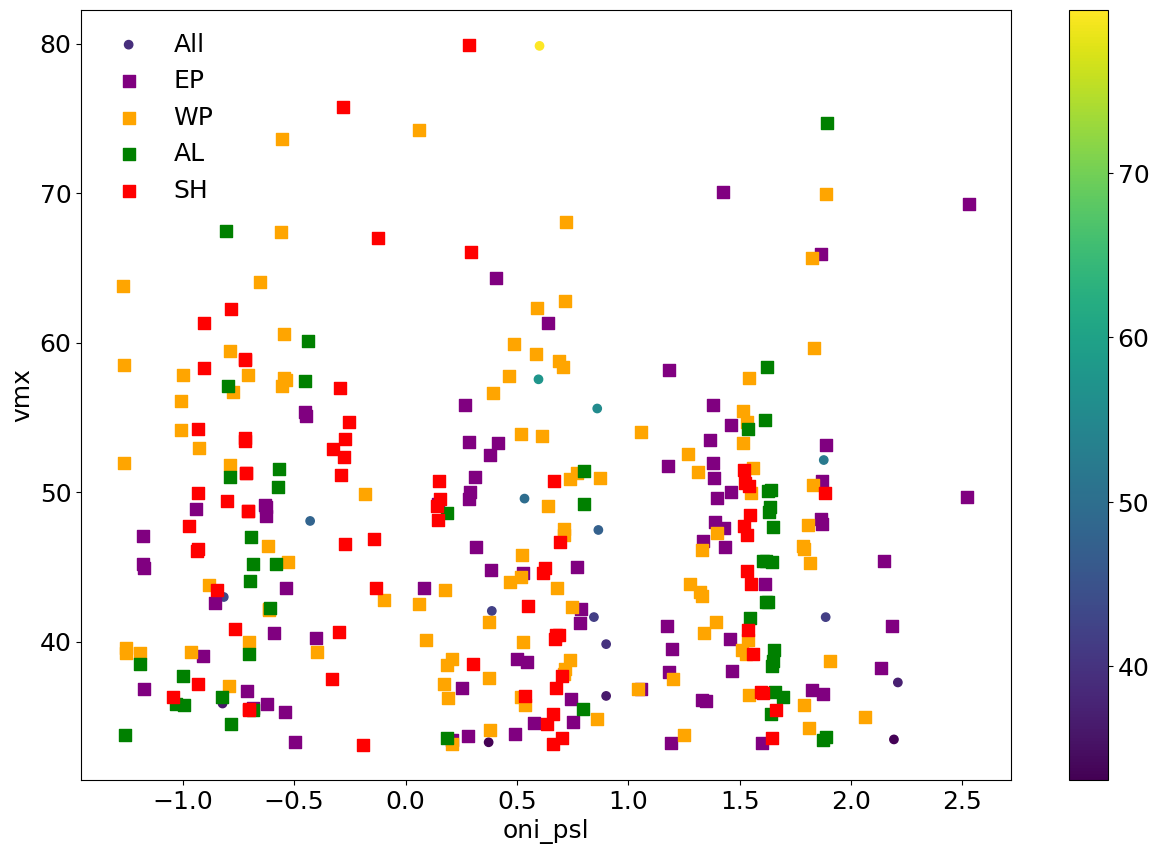

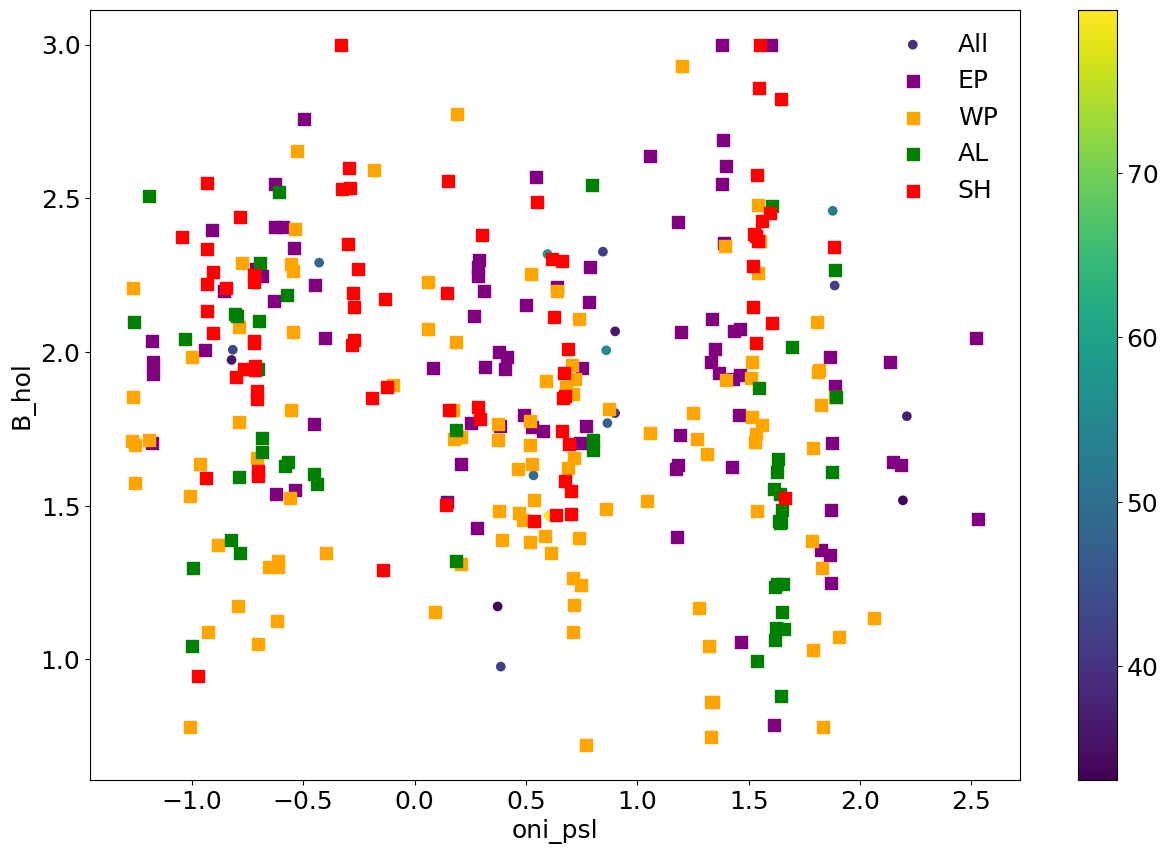

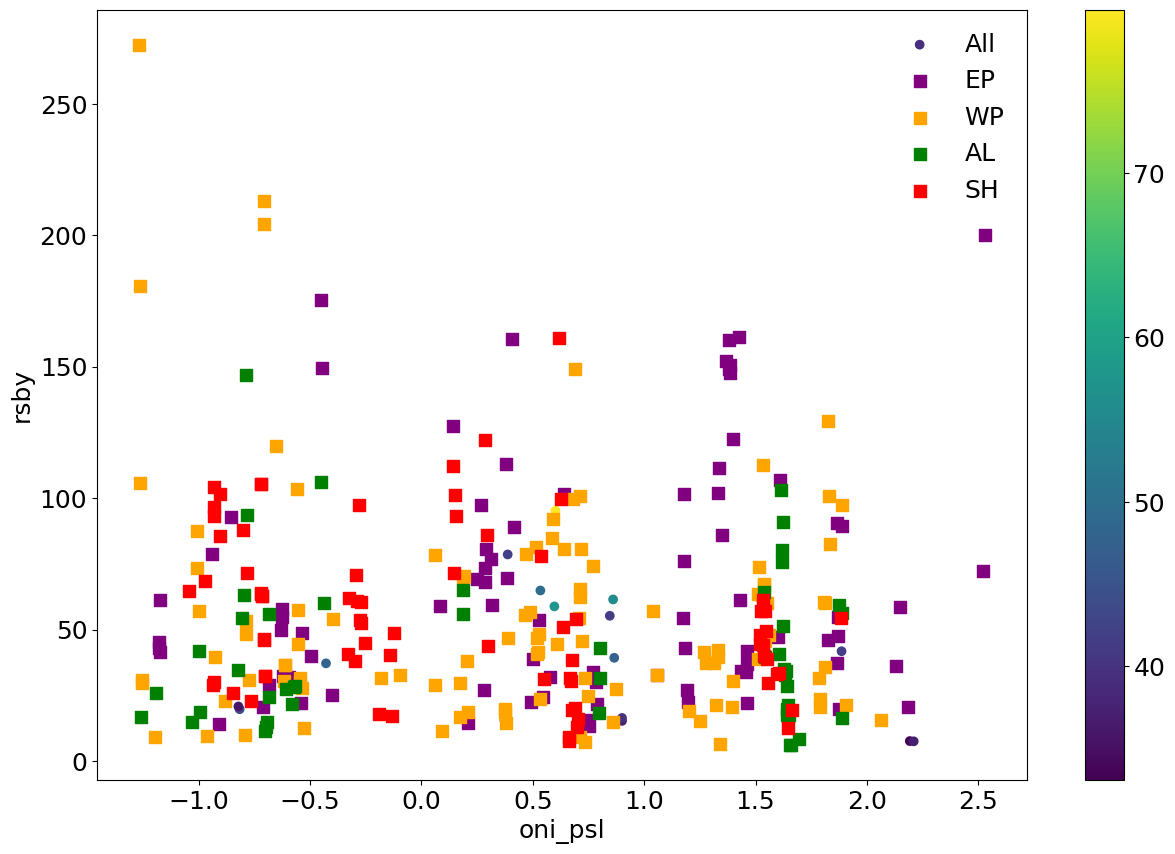

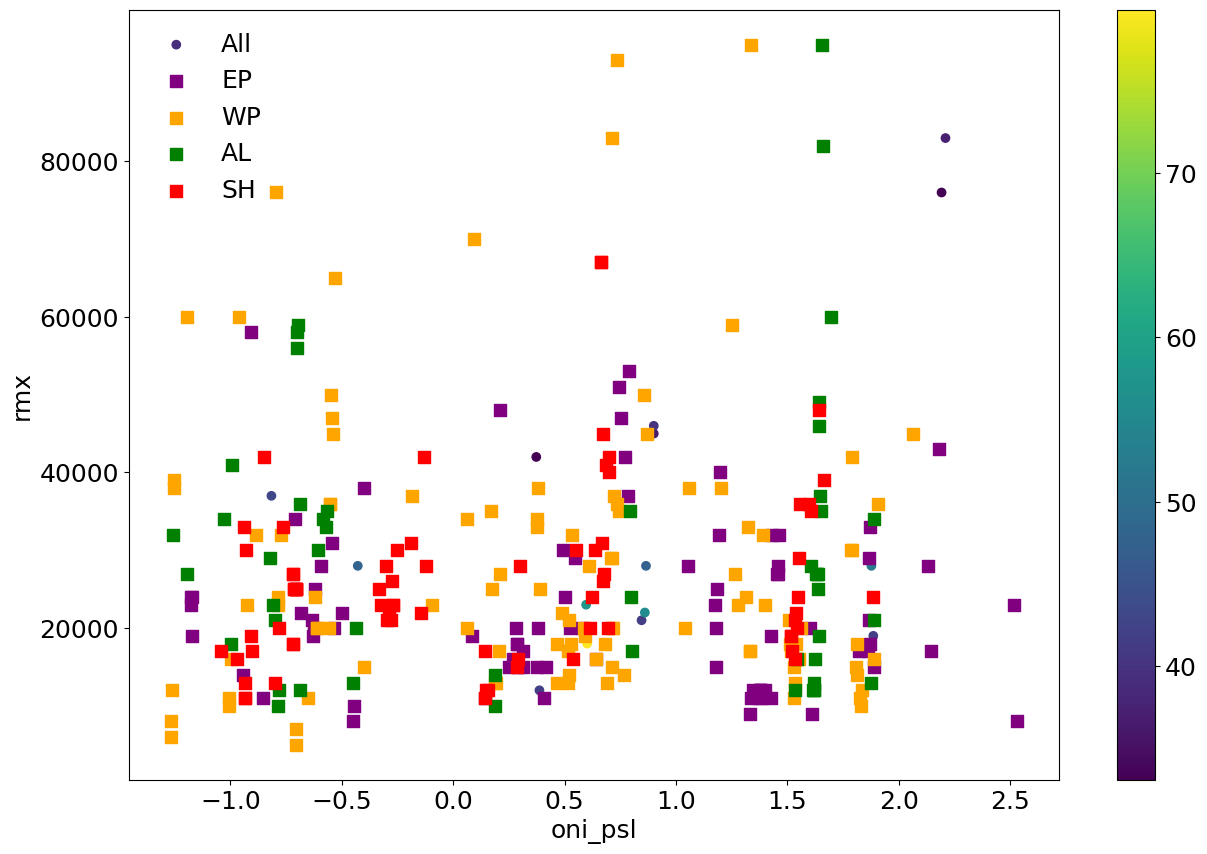

In [28]:
x = 'oni_psl'

for prm in ['sst_rms', 'beta0', 'beta0_T0', 'vmx', 'B_hol', 'rsby', 'rmx']:
    plt.scatter(d[x],  d[prm],  c=d.vmx,                      label='All')
    plt.colorbar()
    plt.scatter(de[x], de[prm], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[x], dw[prm], c='orange', marker='s', s=80, label='WP')
    plt.scatter(da[x], da[prm], c='green',  marker='s', s=80, label='AL')
    plt.scatter(ds[x], ds[prm], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(x)
    plt.ylabel(prm)
    plt.show()

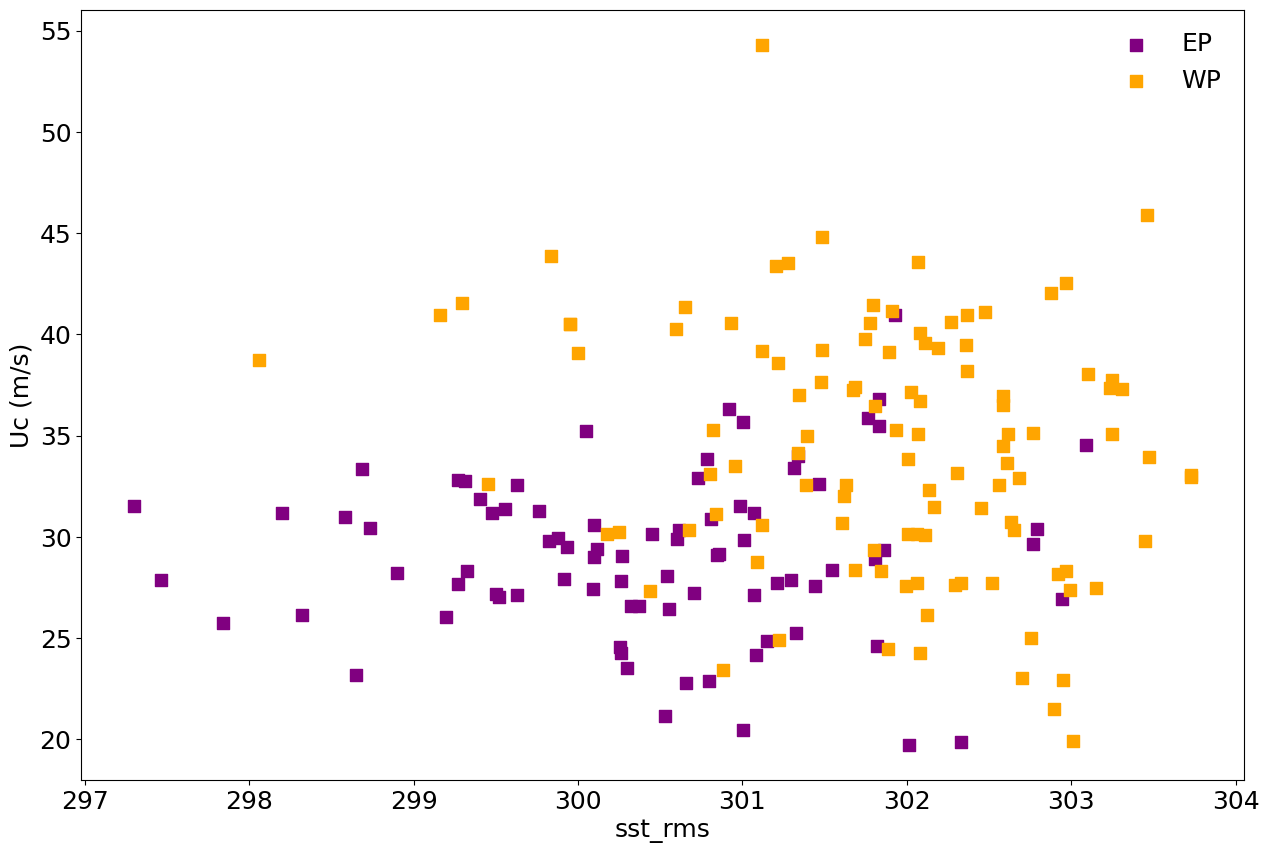

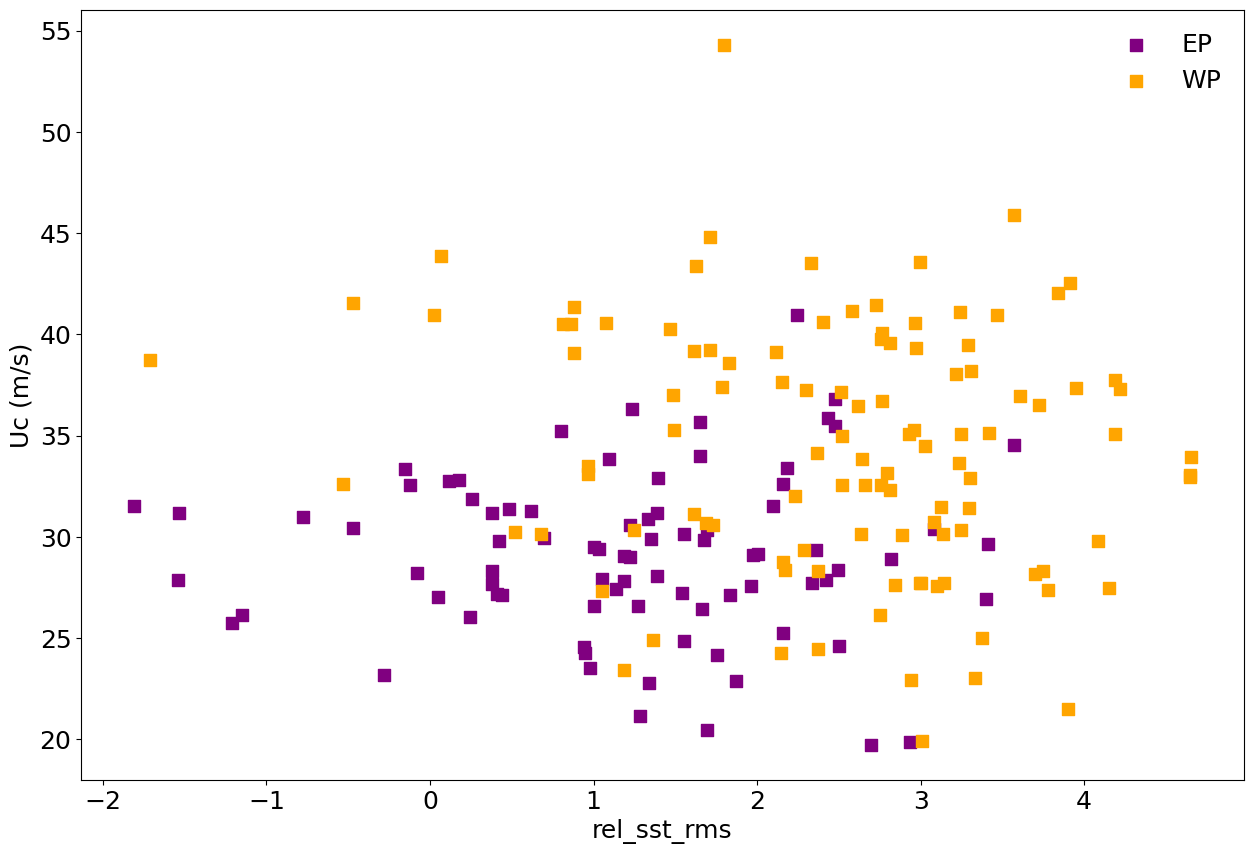

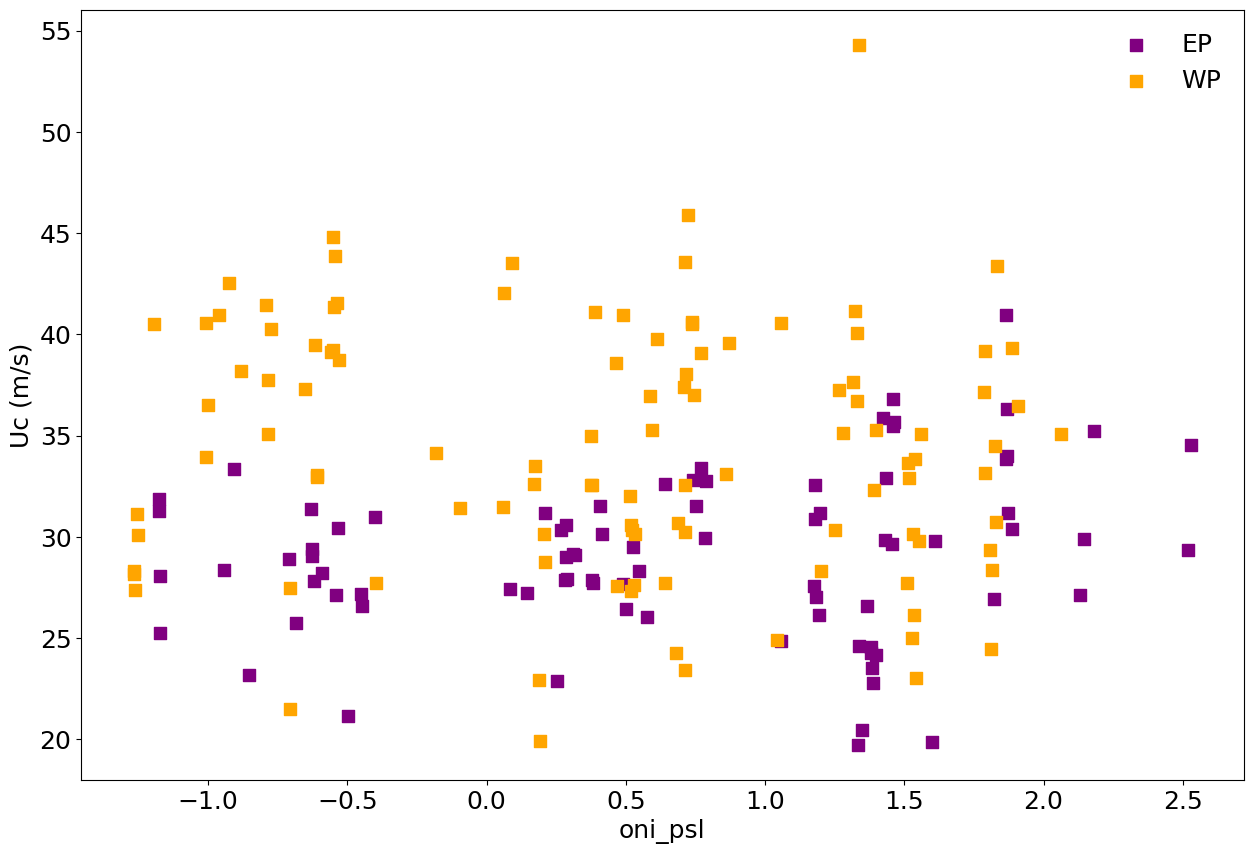

In [29]:
### SYNTHESIS
y = 'uc'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Uc (m/s)')
    plt.show()

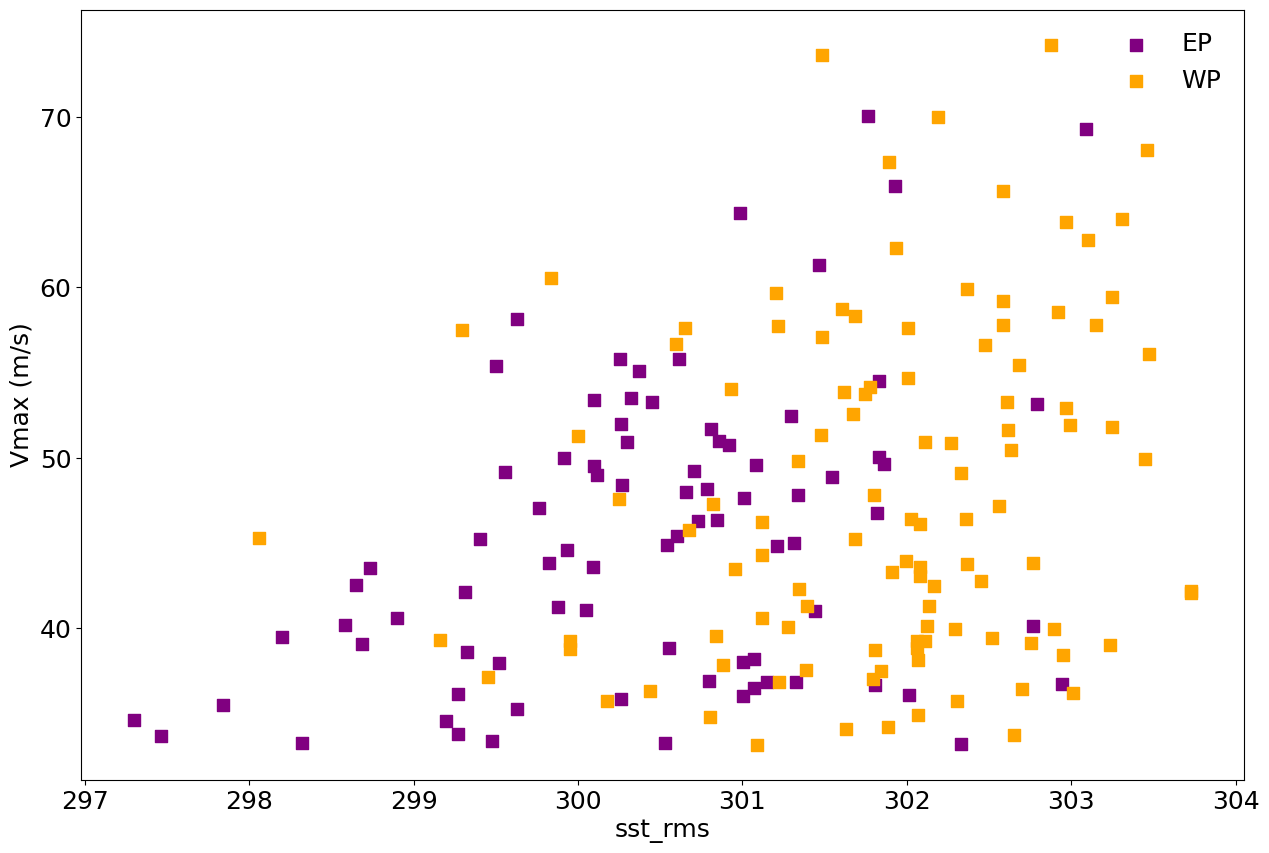

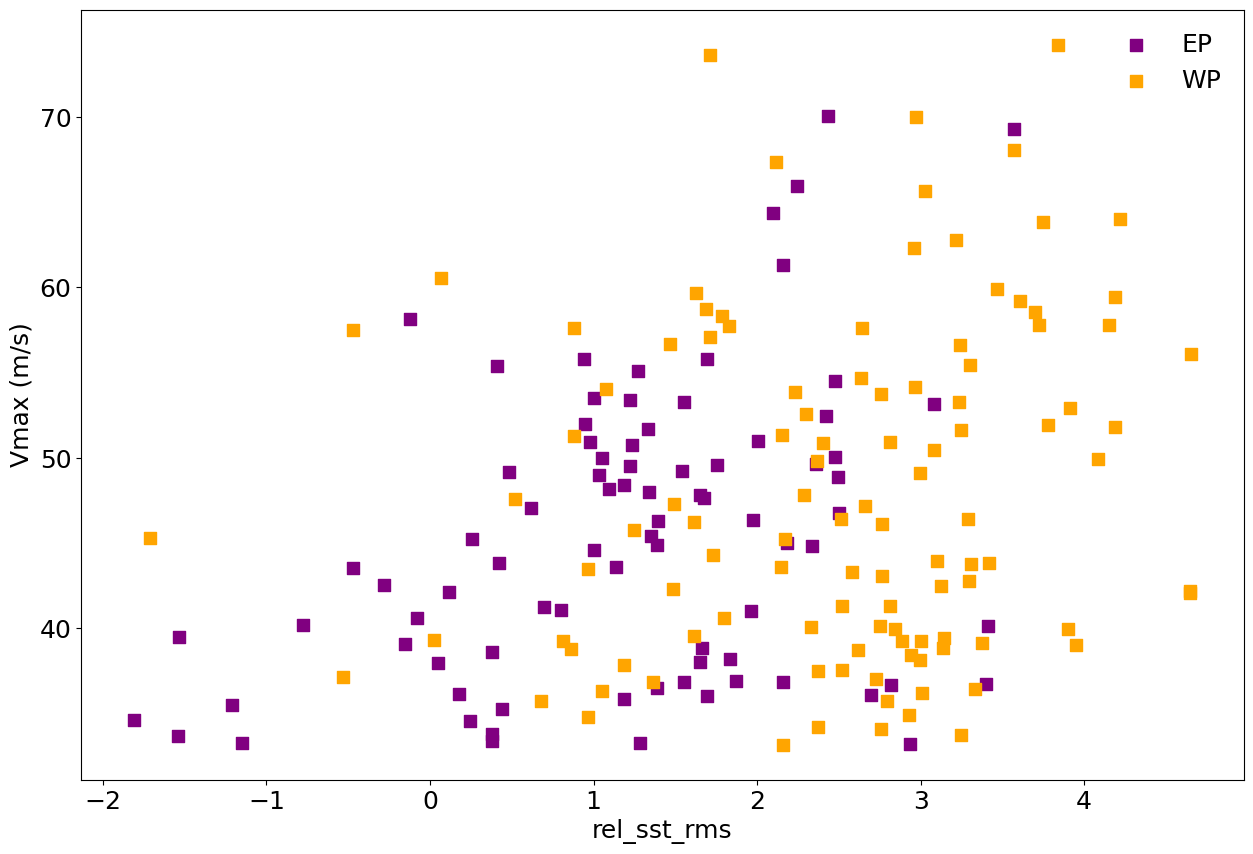

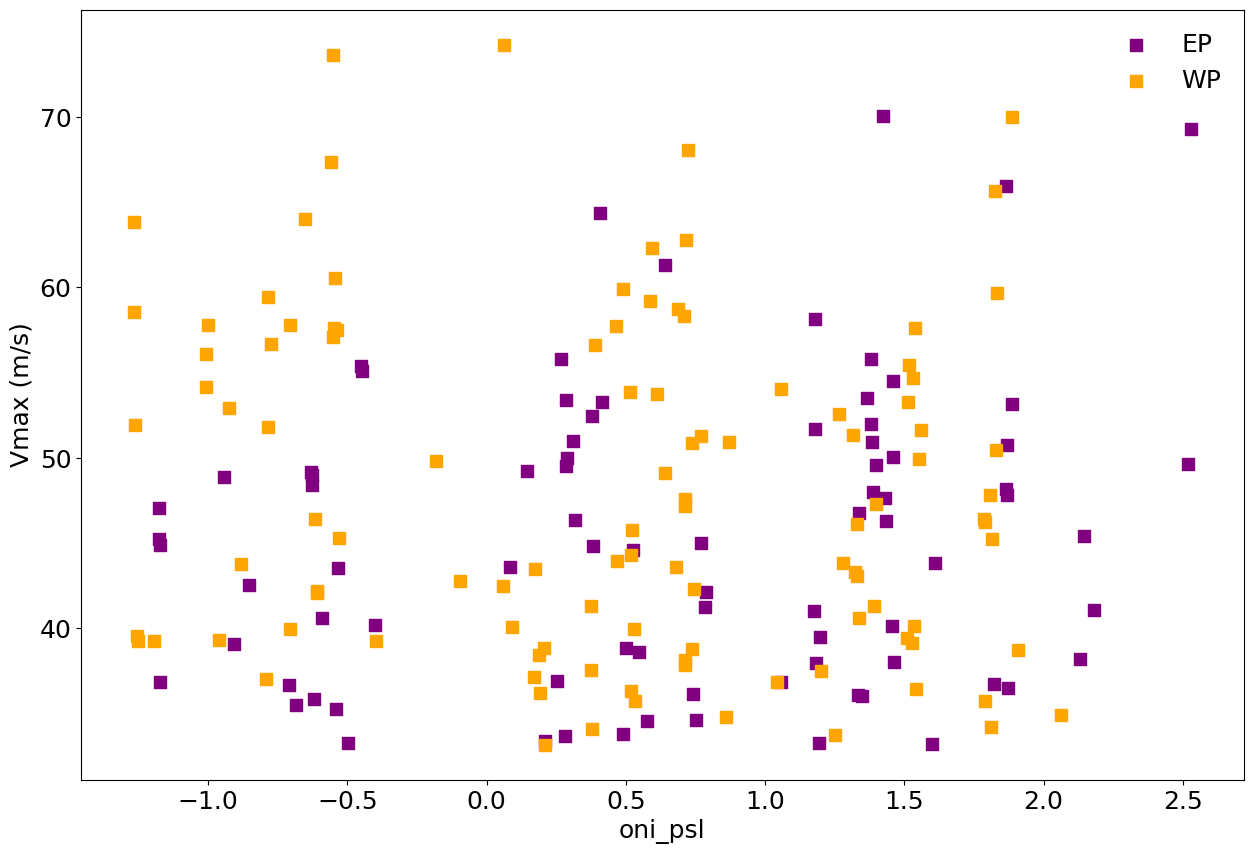

In [30]:
### SYNTHESIS
y = 'vmx'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Vmax (m/s)')
    plt.show()

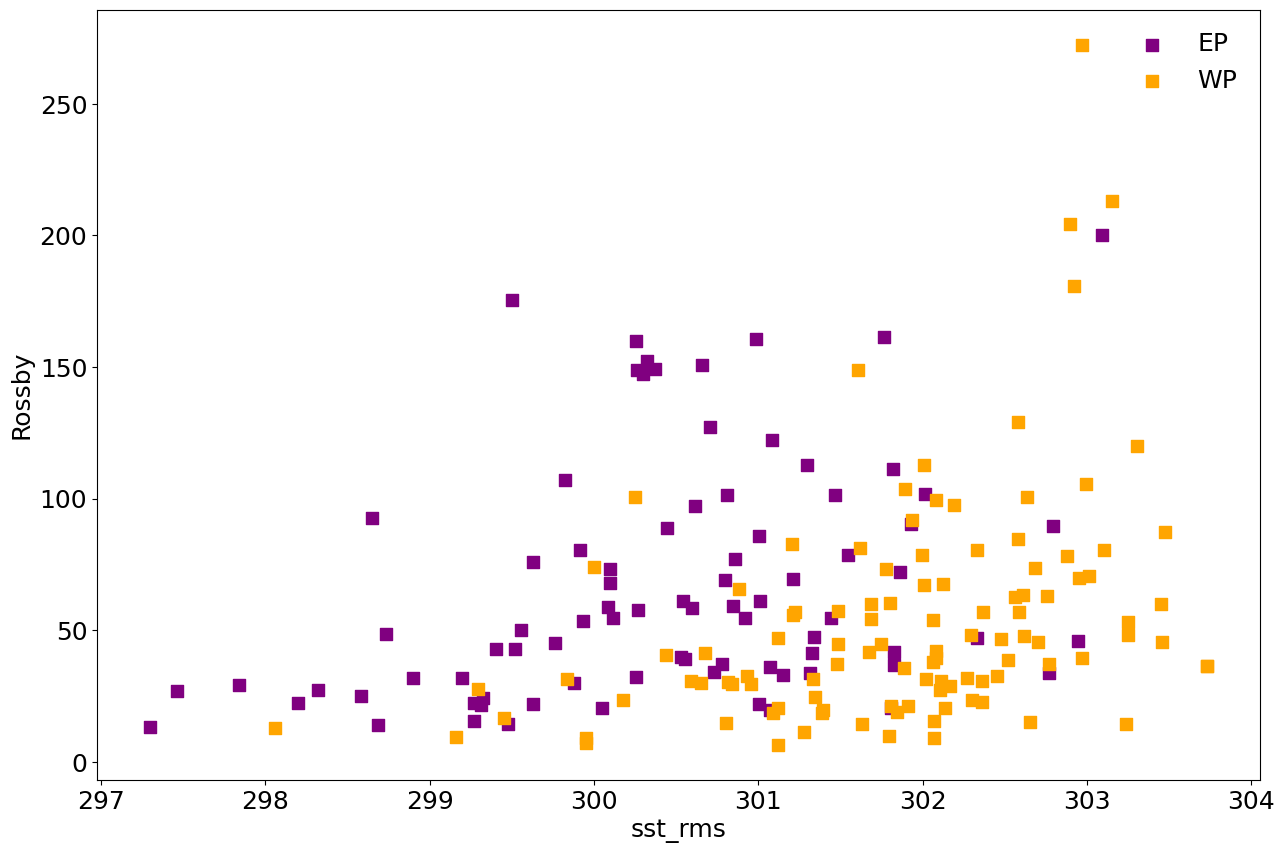

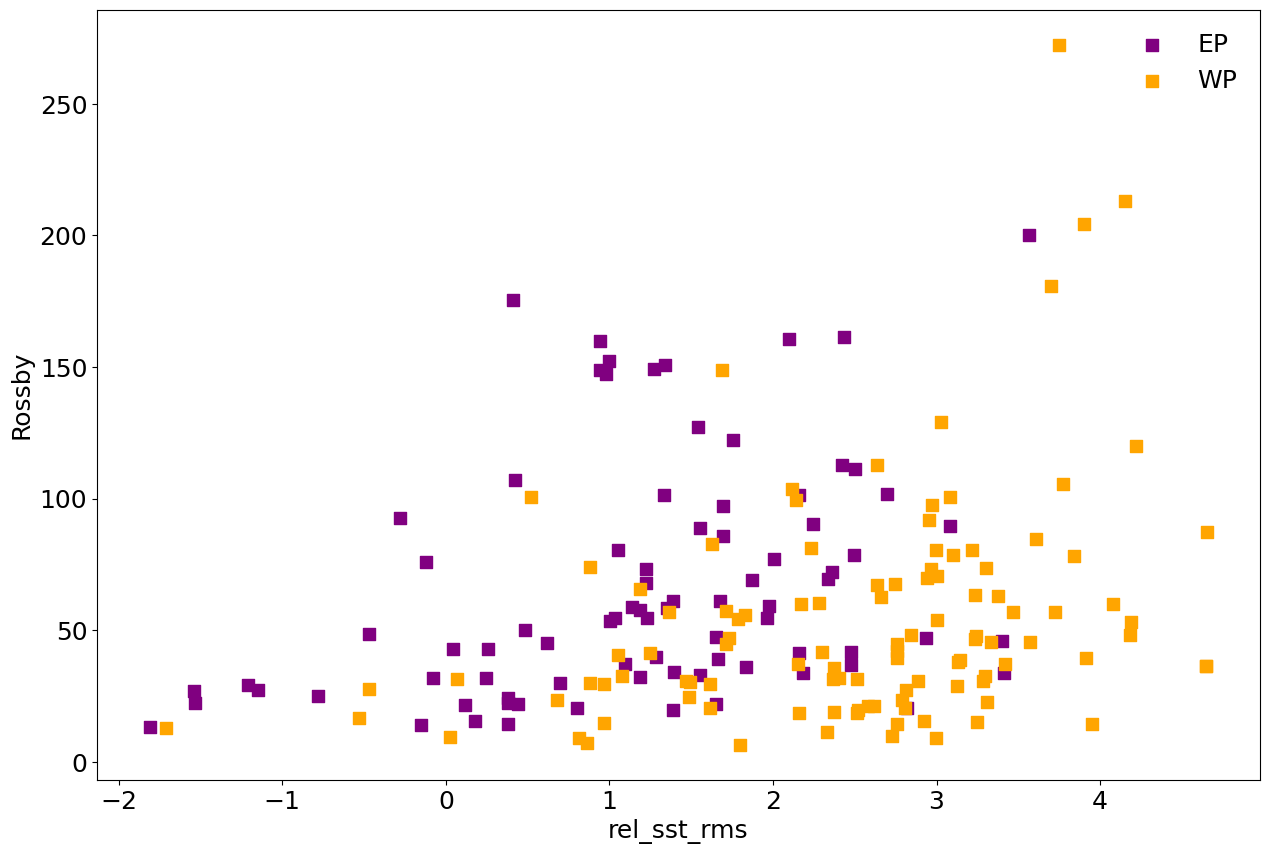

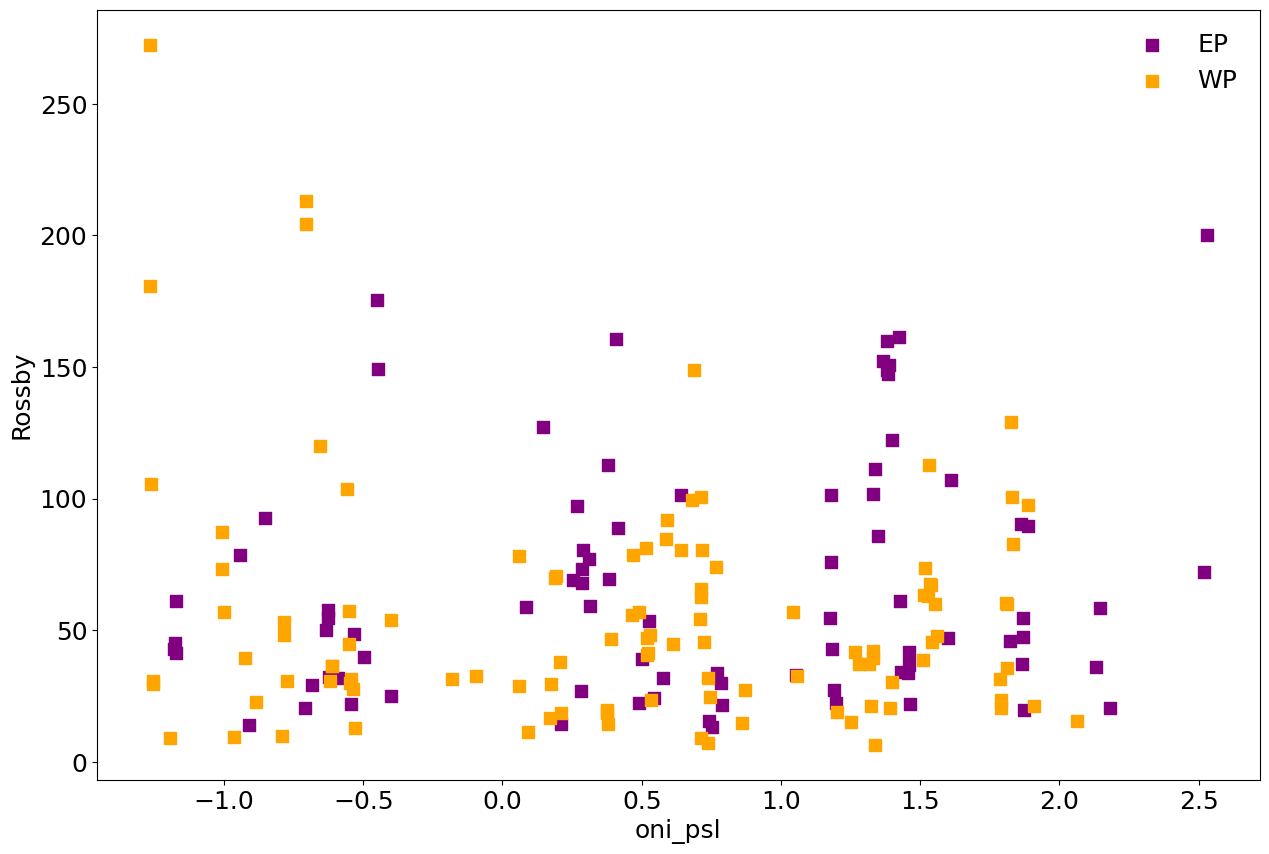

In [31]:
### SYNTHESIS
y = 'rsby'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Rossby')
    plt.show()

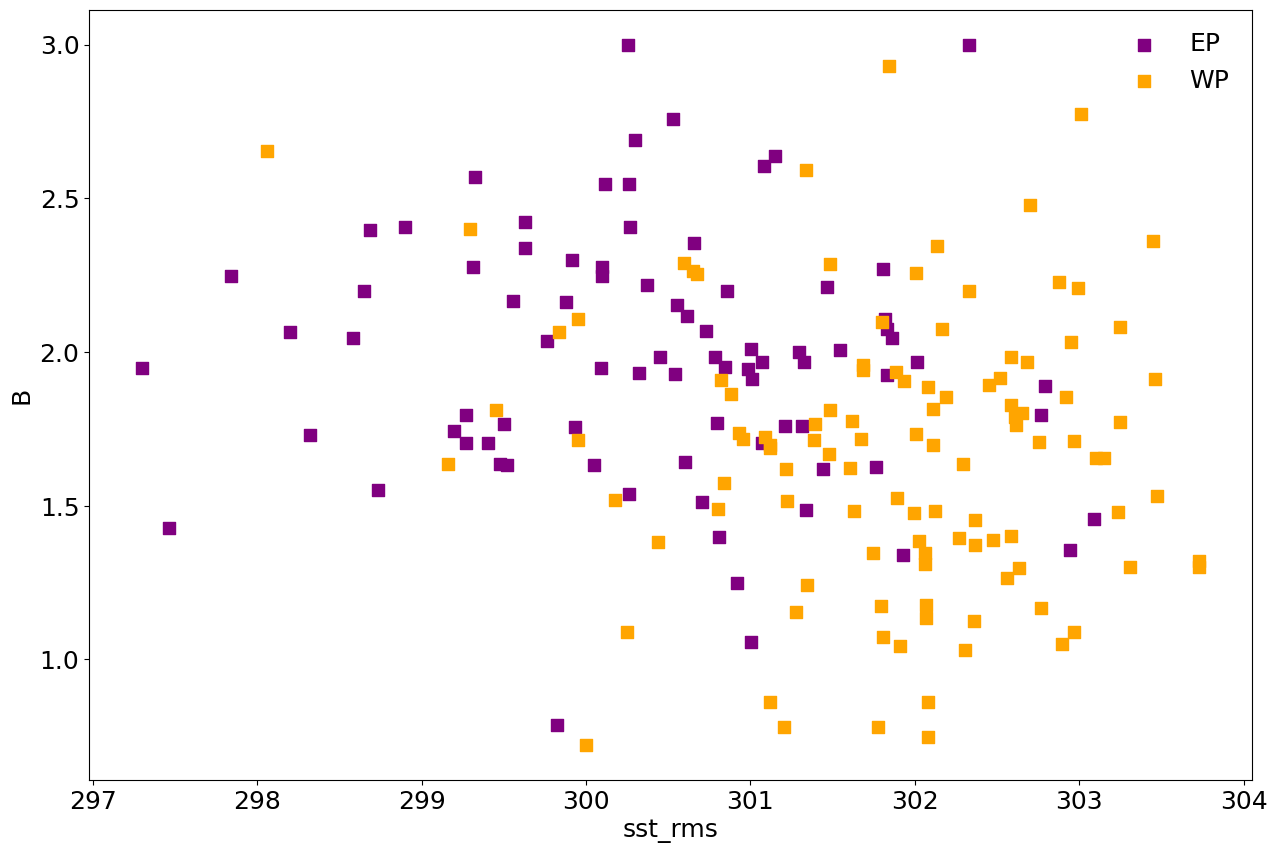

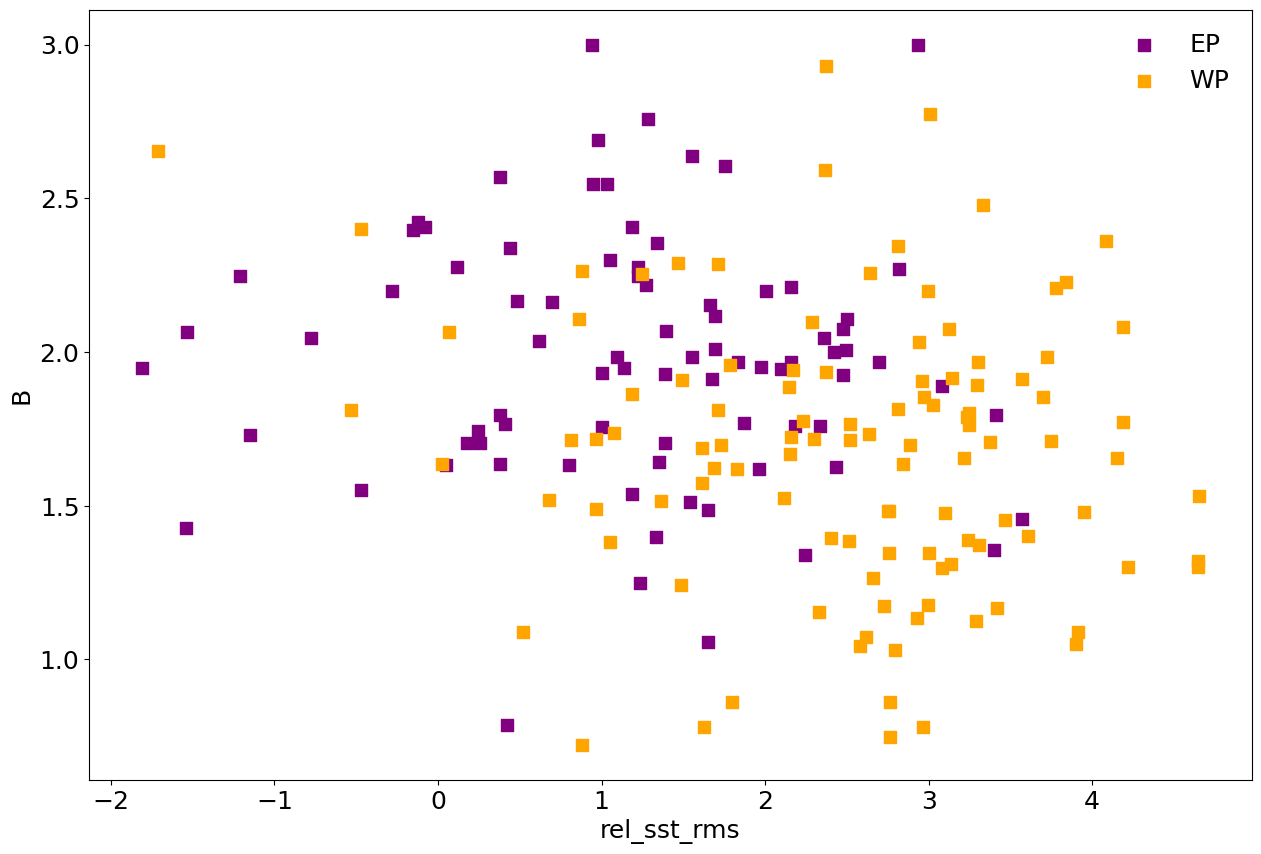

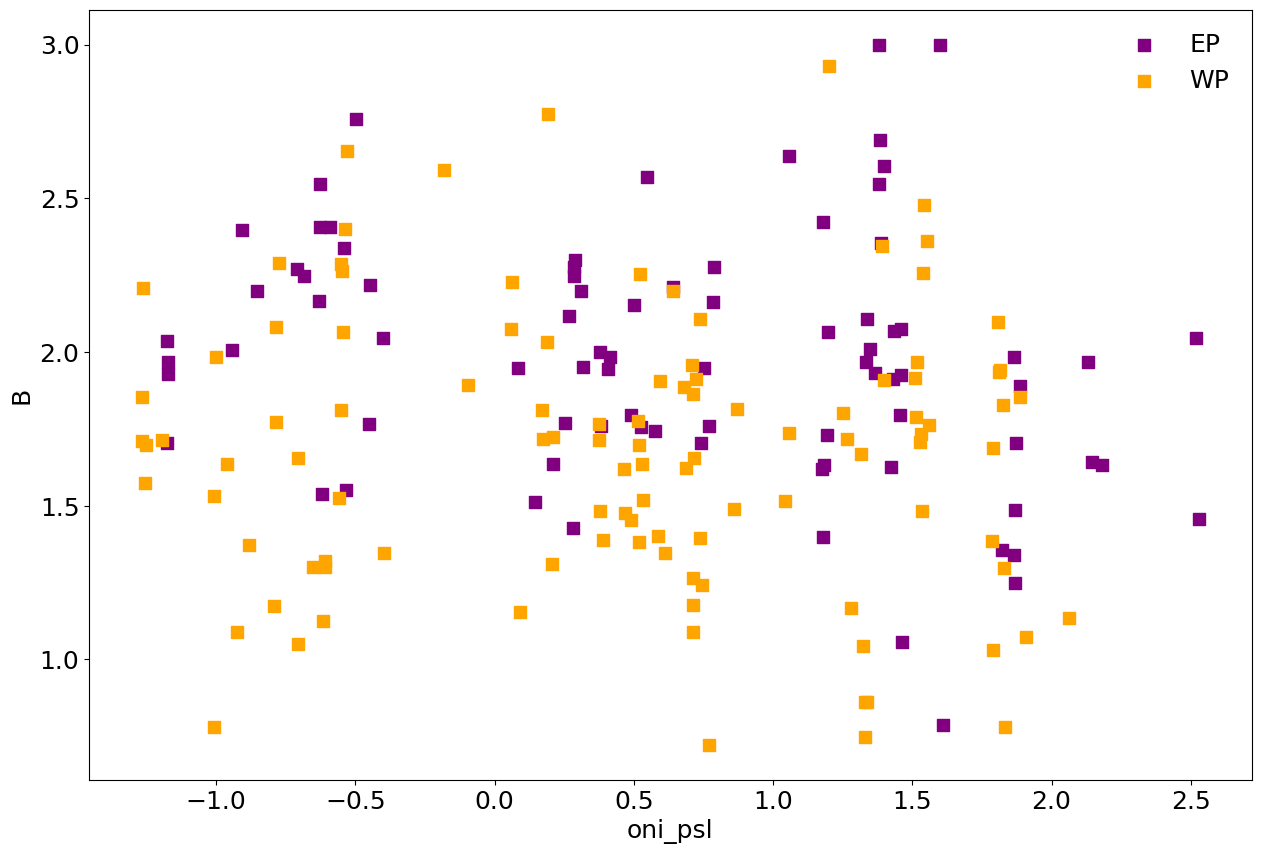

In [32]:
### SYNTHESIS
y = 'B_hol'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('B')
    plt.show()

In [33]:
# ### SYNTHESIS
# for prm in ['sst_rms', 'oni_psl']:
#     plt.scatter(de[prm], np.sqrt(de.B_hol * de.rsby), c='purple', marker='s', s=80, label='EP')
#     plt.scatter(dw[prm], np.sqrt(dw.B_hol * dw.rsby), c='orange', marker='s', s=80, label='WP')
#     # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
#     # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
#     plt.legend(frameon=False)
#     plt.xlabel(prm)
#     plt.ylabel('sqrt(B * rsby)')
#     plt.show()

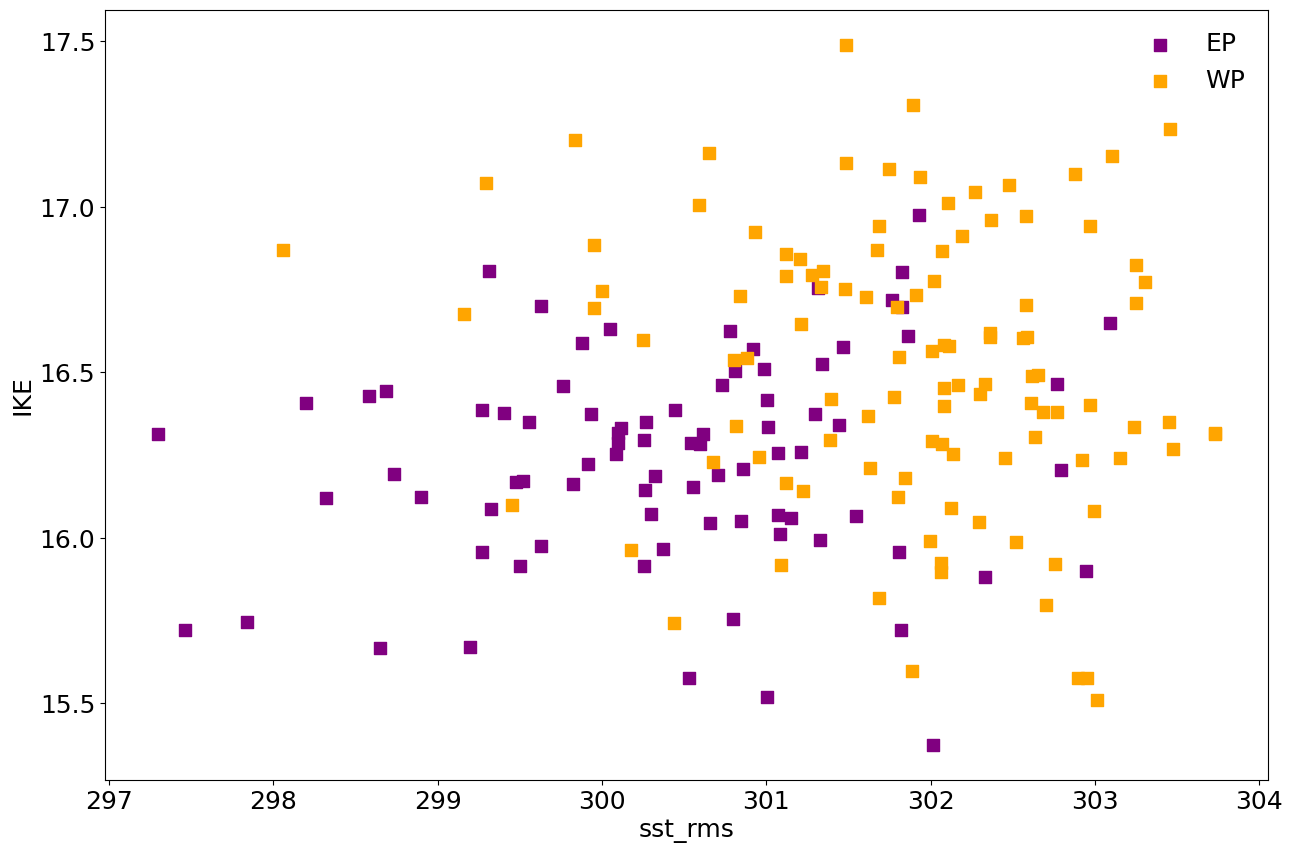

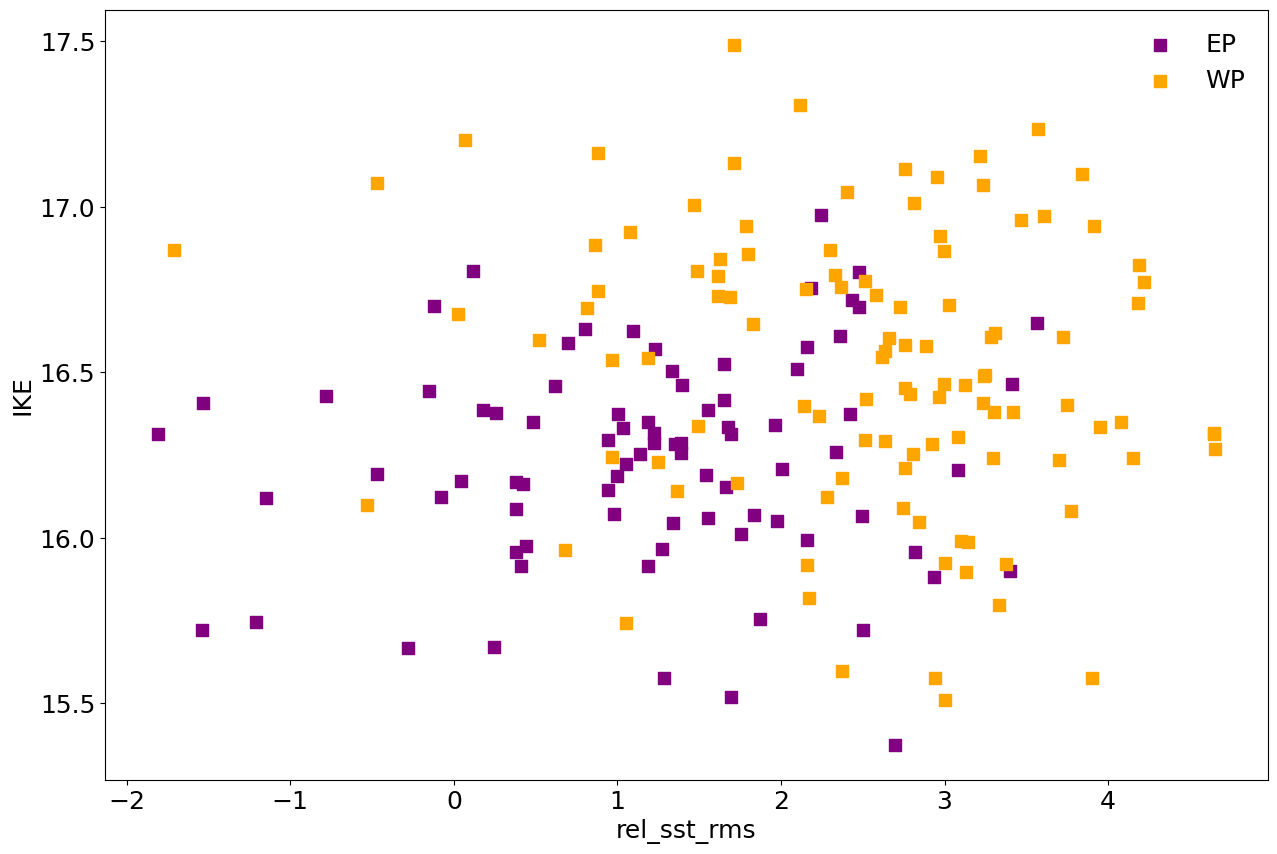

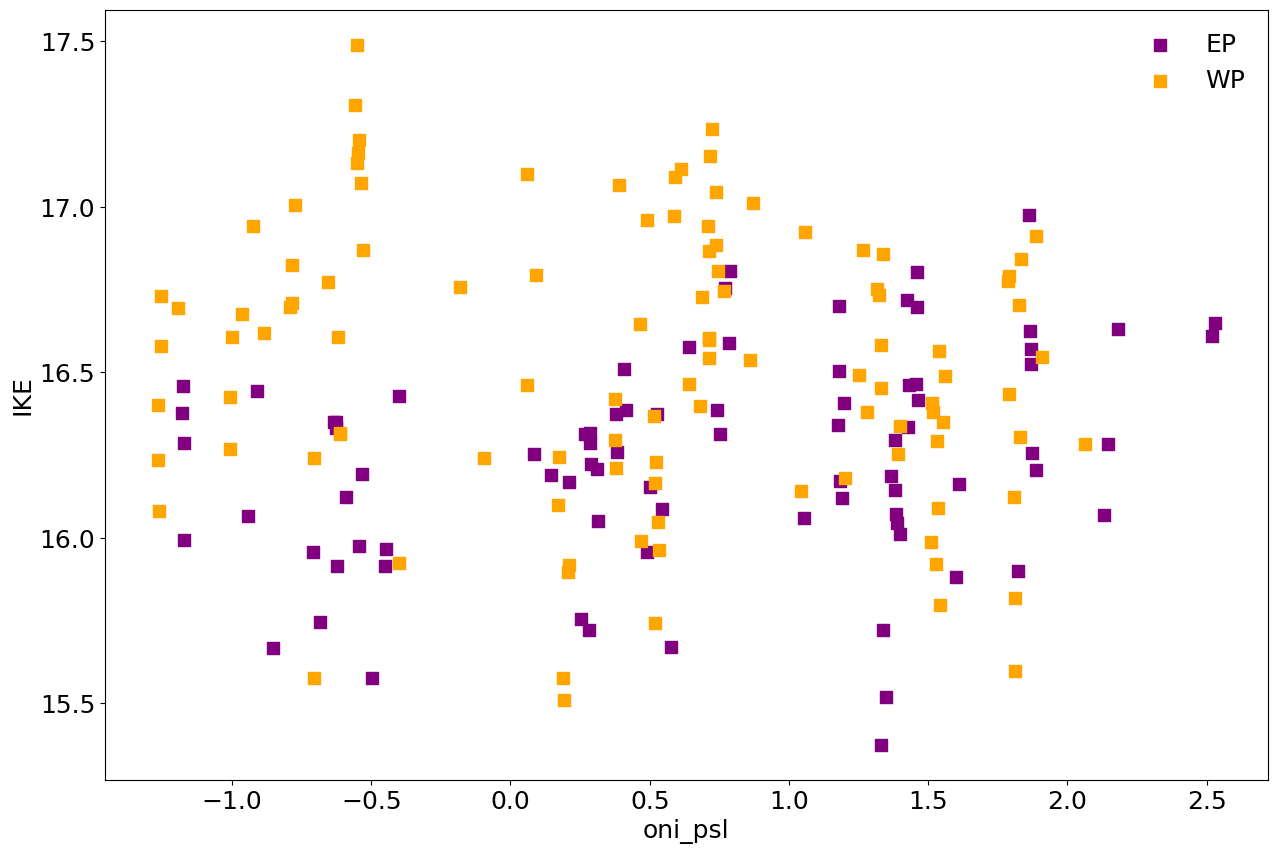

In [34]:
### SYNTHESIS
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], np.log10(de.K), c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], np.log10(dw.K), c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('IKE')
    plt.show()

### 4) Conditional dependance

In [35]:
# plt.scatter(d.vmx ** 2 / np.sqrt(d.rsby), np.sqrt(d.B_hol), c=d.uc ** 2, cmap=cm.get_cmap('Reds'))
# # plt.scatter(d.vmx ** 2 / np.sqrt(d.rsby), np.sqrt(d.B_hol), c=d.oni_psl)
# plt.colorbar()

In [36]:
# # plt.scatter(dl.vmx ** 2 / np.sqrt(dl.rsby), np.sqrt(dl.B_hol), c=dl.uc ** 2)
# # plt.scatter(dl.vmx ** 2 / np.sqrt(dl.rsby), np.sqrt(dl.B_hol), c=dl.sst_rms)
# plt.colorbar()

Text(0, 0.5, 'Rossby number')

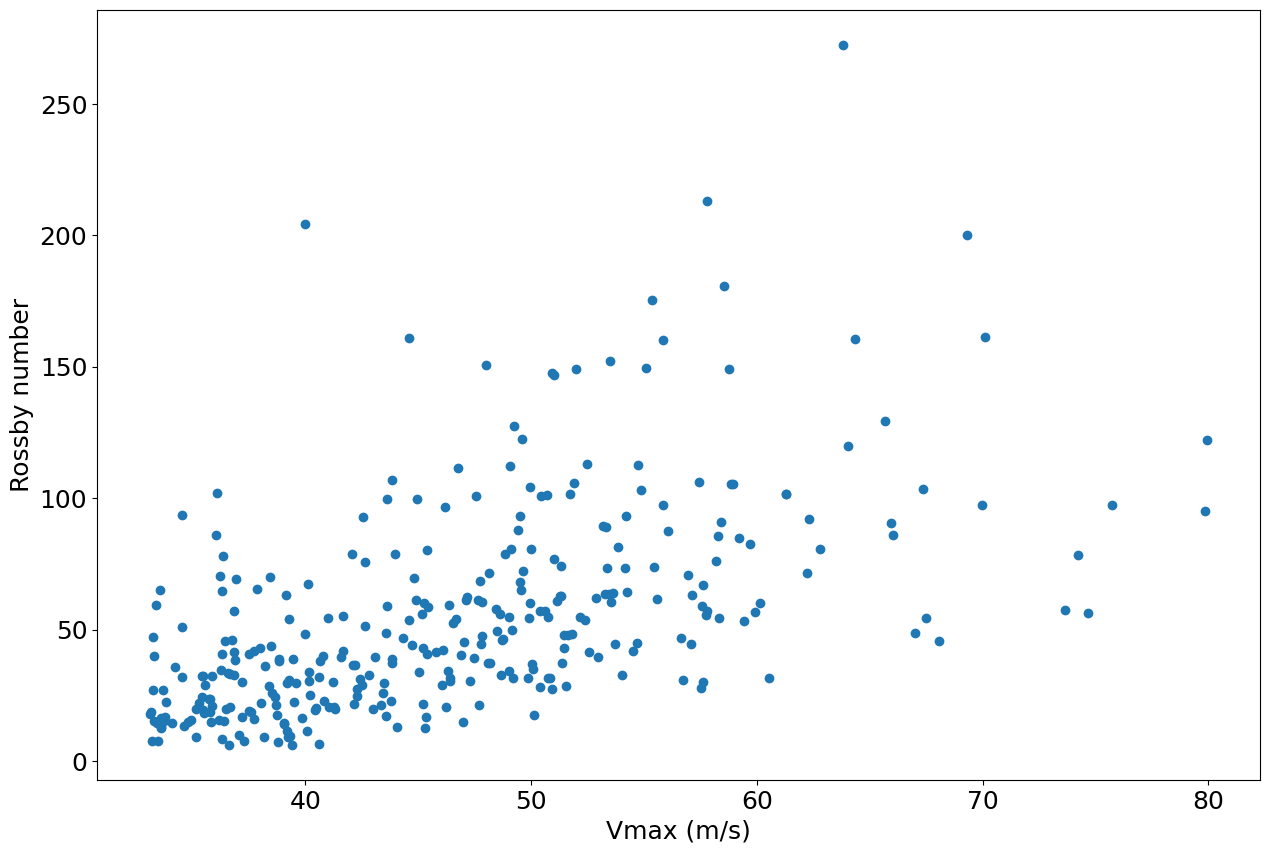

In [37]:
plt.scatter(d.vmx, d.rsby)
plt.xlabel('Vmax (m/s)')
plt.ylabel('Rossby number')

In [38]:
# Also try Vmax  55 m/s
cond = (d.vmx > 55) & (d.vmx < 57) & (d.rsby > 80) & (d.rsby < 100)
dcd  = d.where(cond, drop=True)

In [39]:
print('Vmax ** 2 variation: {:.1f}%'.format((1 - float(dcd.vmx.min() ** 2 / dcd.vmx.max() ** 2)) * 100))
print('sqrt(rsby) variation: {:.1f}%'.format((1 - float(np.sqrt(dcd.rsby.min()) / np.sqrt(dcd.rsby.max()))) * 100))
print('sqrt(B) variation: {:.1f}%'.format((1 - float(np.sqrt(dcd.B_hol.min()) / np.sqrt(dcd.B_hol.max()))) * 100))
print('Uc ** 2 variation: {:.1f}%'.format((1 - float(dcd.uc.min() ** 2 / dcd.uc.max() ** 2)) * 100))

Vmax ** 2 variation: 0.9%
sqrt(rsby) variation: 5.1%
sqrt(B) variation: 15.0%
Uc ** 2 variation: 20.1%


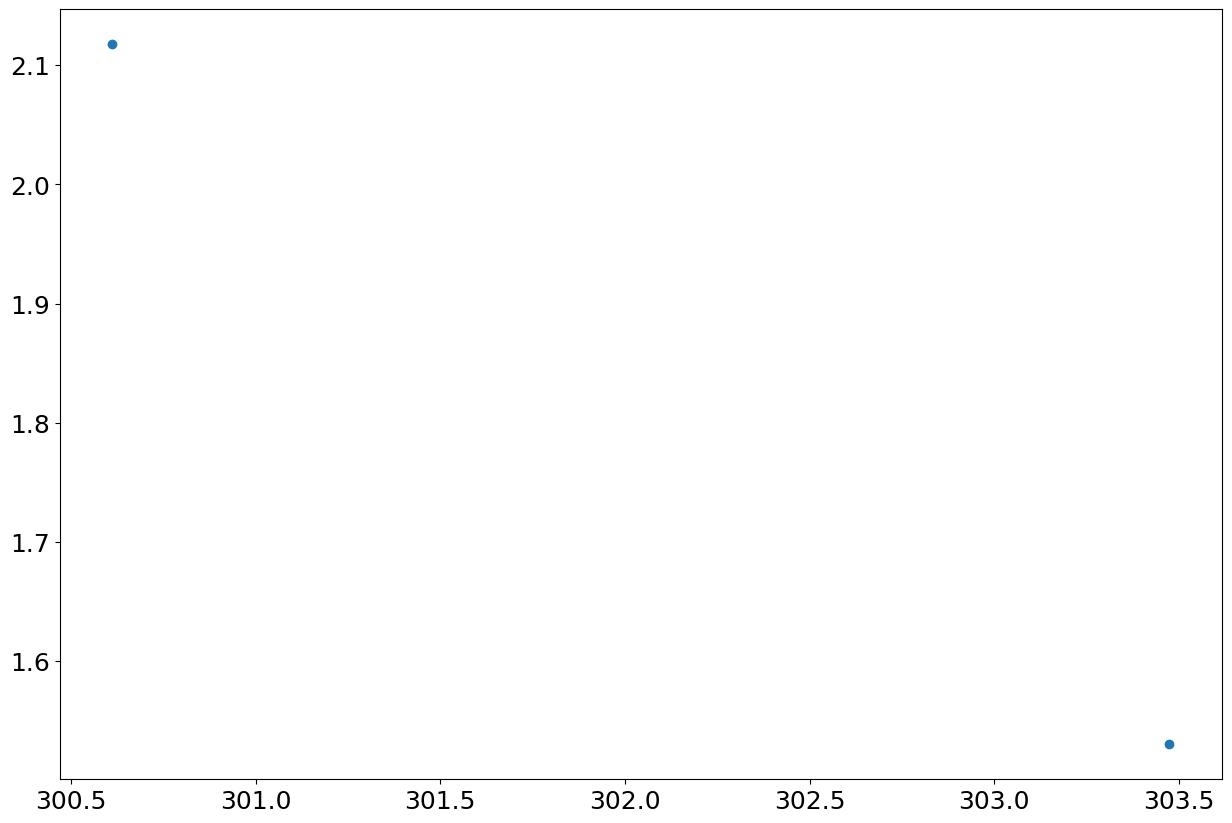

In [40]:
plt.scatter(dcd.sst_rms, dcd.B_hol)

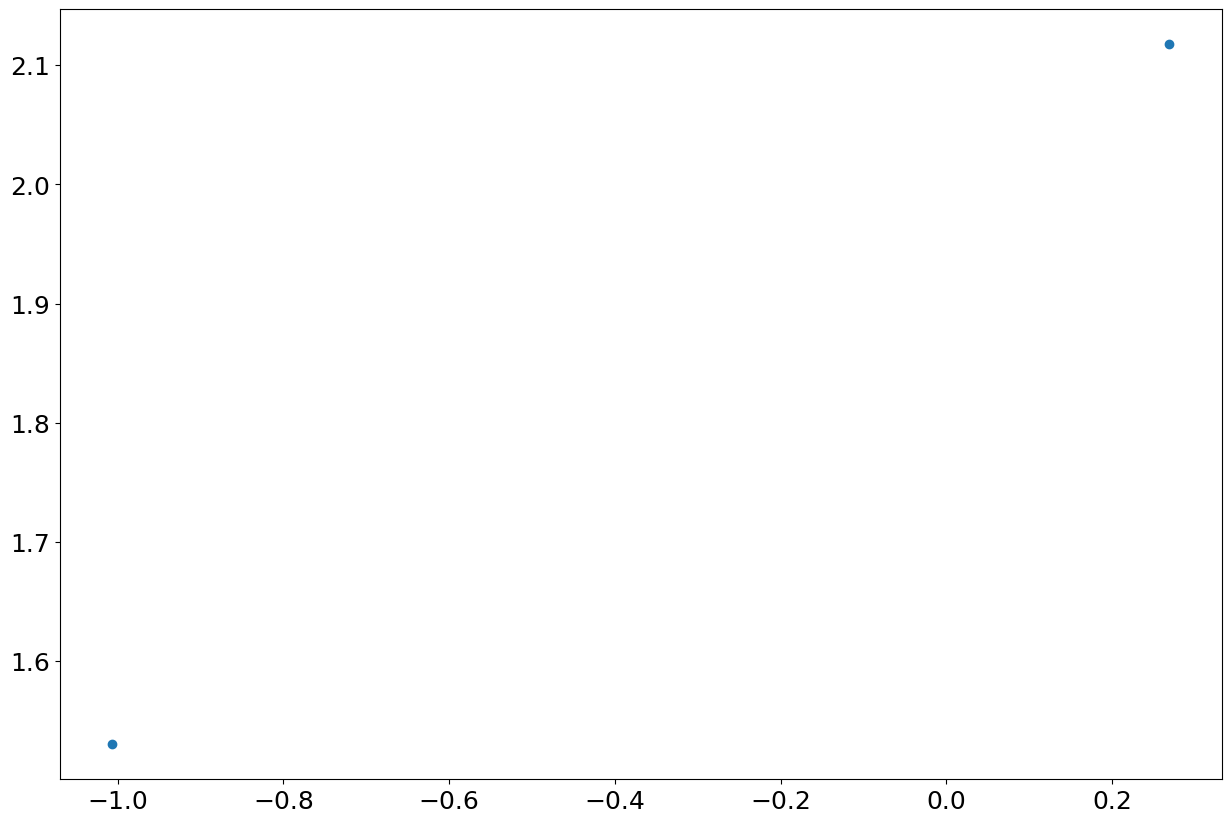

In [41]:
plt.scatter(dcd.oni_psl, dcd.B_hol)

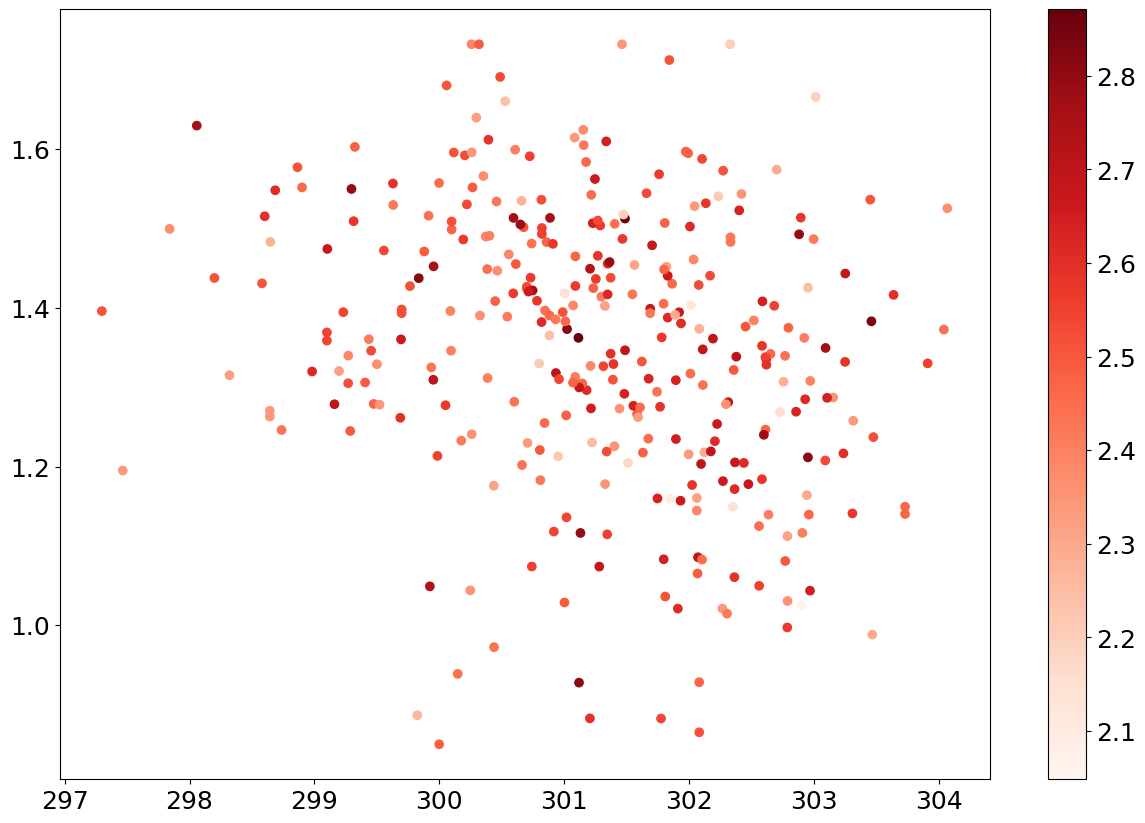

In [42]:
### Need to take cases that have the same Vmax^2 / sqrt(rsby)
plt.scatter(d.sst_rms, np.sqrt(d.B_hol), c=np.log10(d.vmx ** 2 / np.sqrt(d.rsby)), cmap=cm.get_cmap('Reds'))
plt.colorbar()

(array([13., 52., 82., 73., 49., 33., 11.,  8.,  8.,  3.]),
 array([111.81231893, 174.93305621, 238.05379349, 301.17453077,
        364.29526804, 427.41600532, 490.5367426 , 553.65747988,
        616.77821716, 679.89895444, 743.01969171]),
 <BarContainer object of 10 artists>)

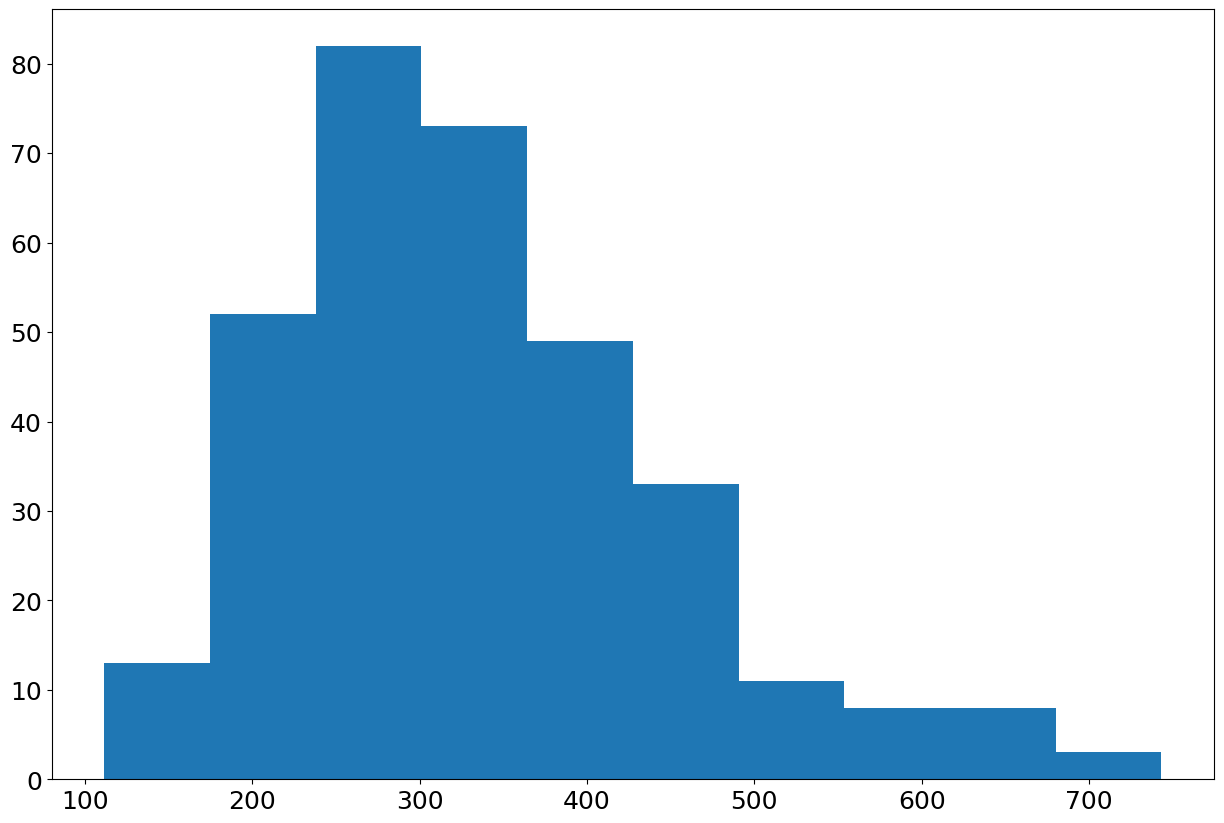

In [43]:
plt.hist(d.vmx ** 2 / np.sqrt(d.rsby))

In [44]:
cond = (d.vmx ** 2 / np.sqrt(d.rsby) > 280) & (d.vmx ** 2 / np.sqrt(d.rsby) < 320)
dcd  = d.where(cond, drop=True)

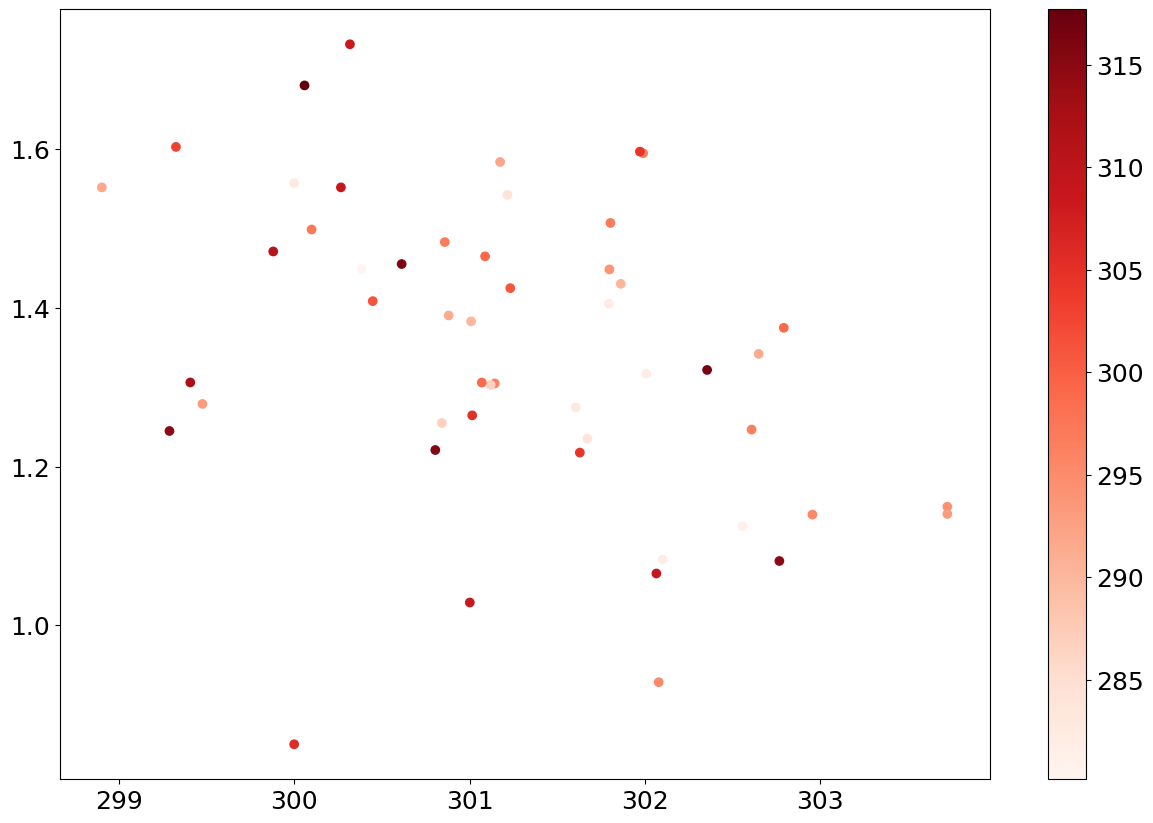

In [45]:
### Need to take cases that have the same Vmax^2 / sqrt(rsby)

plt.scatter(dcd.sst_rms, np.sqrt(dcd.B_hol), c=dcd.vmx ** 2 / np.sqrt(dcd.rsby), cmap=cm.get_cmap('Reds'))
plt.colorbar()

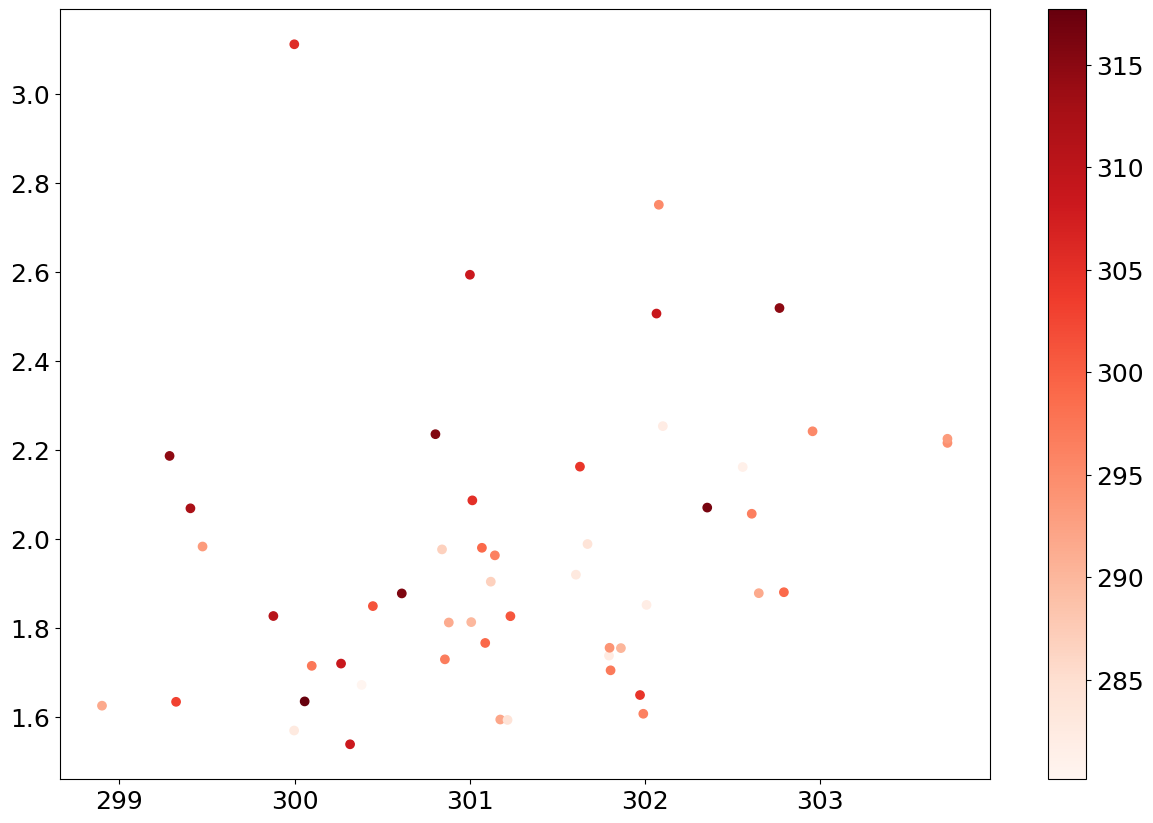

In [46]:
### Need to take cases that have the same Vmax^2 / sqrt(rsby)
# The uppermost case is an ERC

plt.scatter(dcd.sst_rms, dcd.beta0_T0, c=dcd.vmx ** 2 / np.sqrt(dcd.rsby), cmap=cm.get_cmap('Reds'))
plt.colorbar()

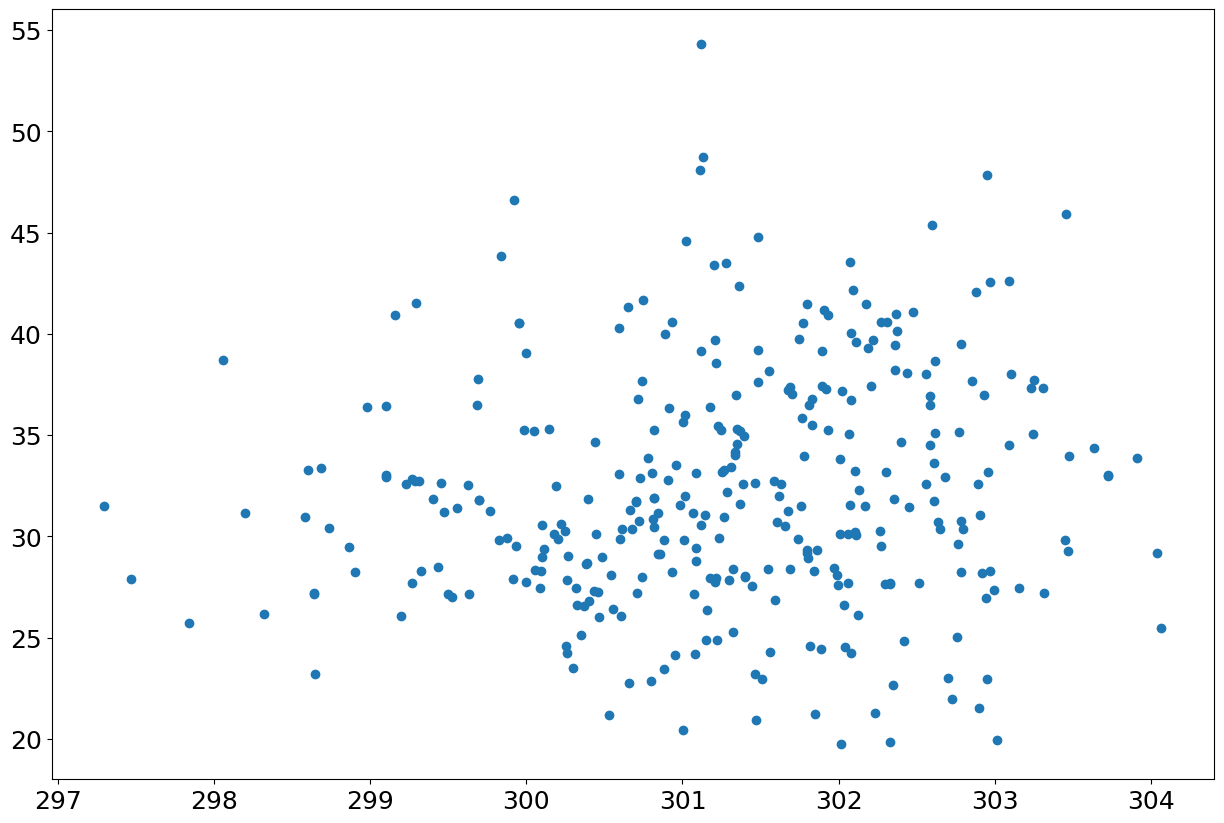

In [47]:
plt.scatter(d.sst_rms, d.uc)

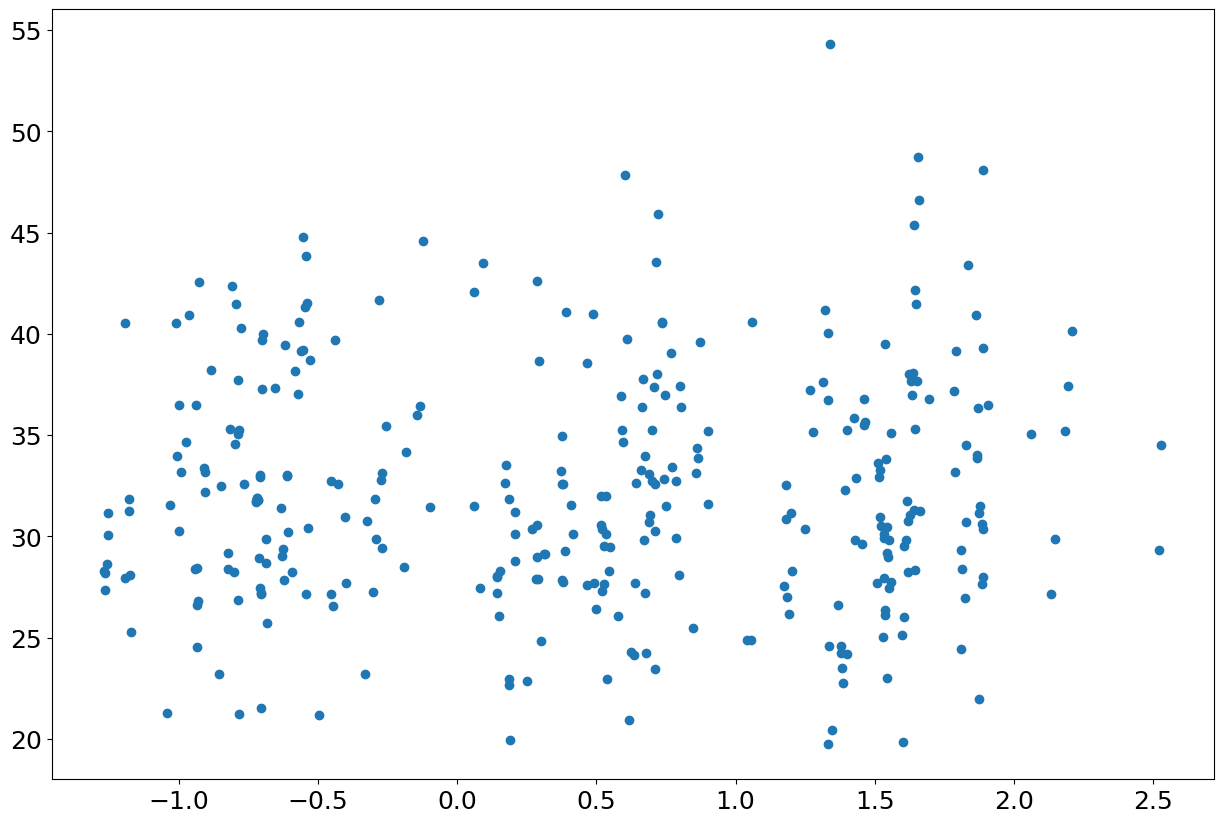

In [48]:
plt.scatter(d.oni_psl, d.uc)

### 5) At the LMI

In [49]:
hrs_thr = 3 # threshold, in hours
dl      = d.where((d.t_since_lmi_ibt / 3600 > -hrs_thr) & (d.t_since_lmi_ibt / 3600 < hrs_thr), drop=True)
print(len(dl.time))

22


In [50]:
da = dl.where(dl.basin == 'al', drop=True)
dc = dl.where(dl.basin == 'cp', drop=True)
de = dl.where(dl.basin == 'ep', drop=True)
di = dl.where(dl.basin == 'io', drop=True)
ds = dl.where(dl.basin == 'sh', drop=True)
dw = dl.where(dl.basin == 'wp', drop=True)

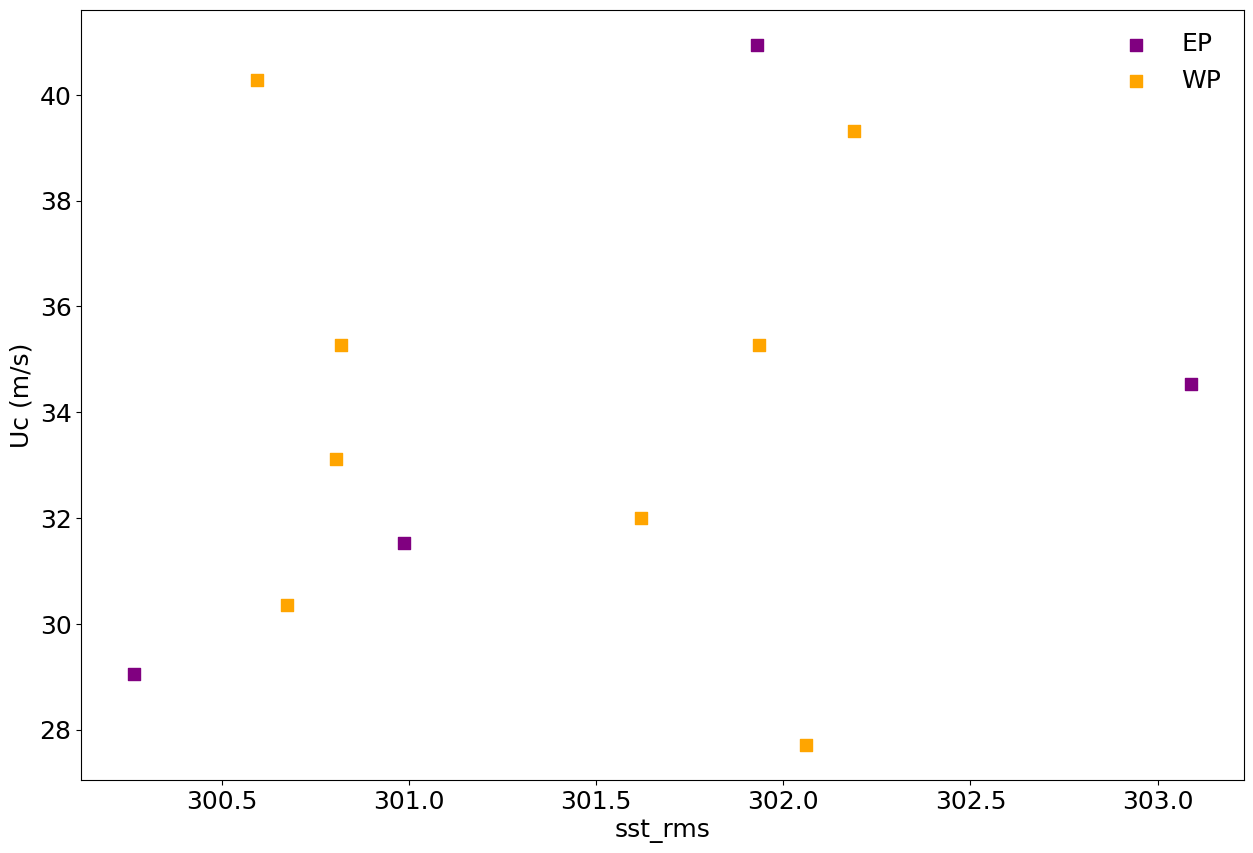

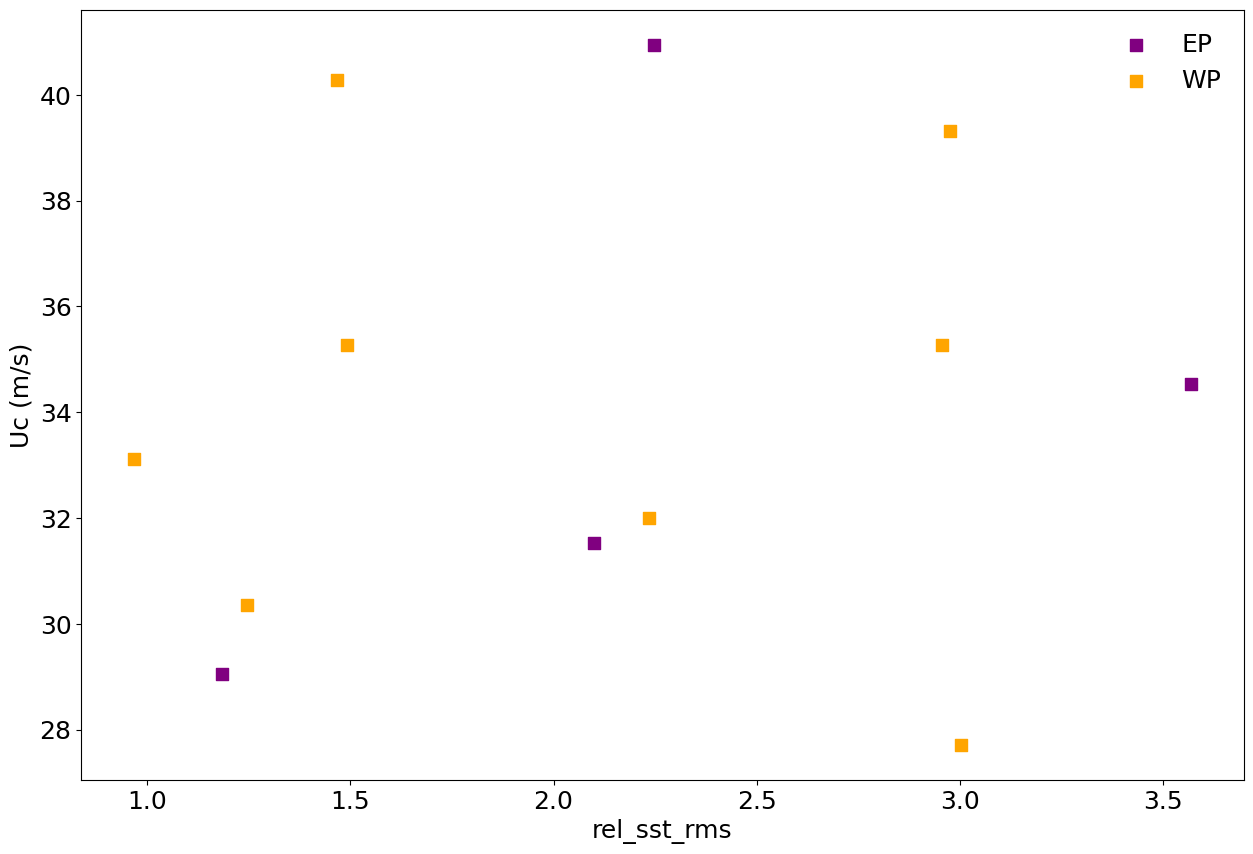

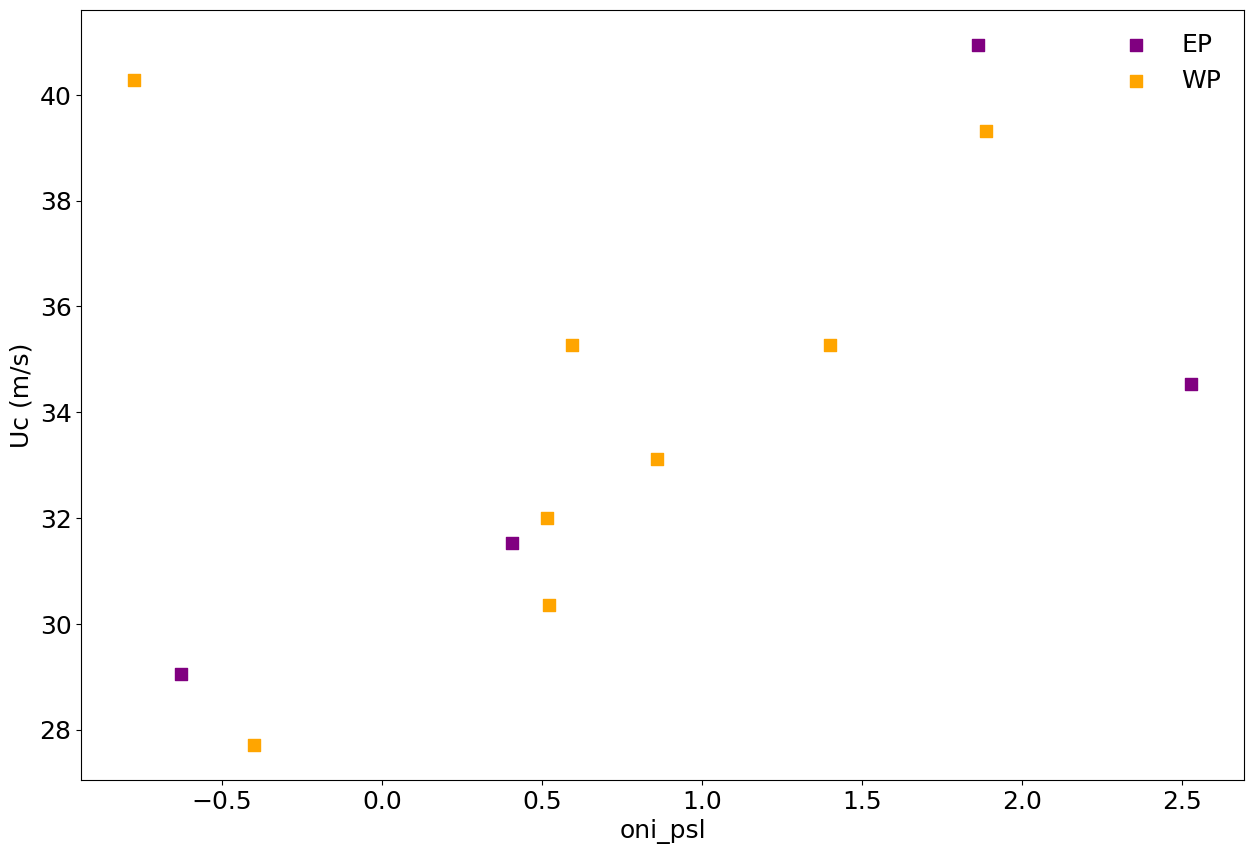

In [51]:
### SYNTHESIS
y = 'uc'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Uc (m/s)')
    plt.show()

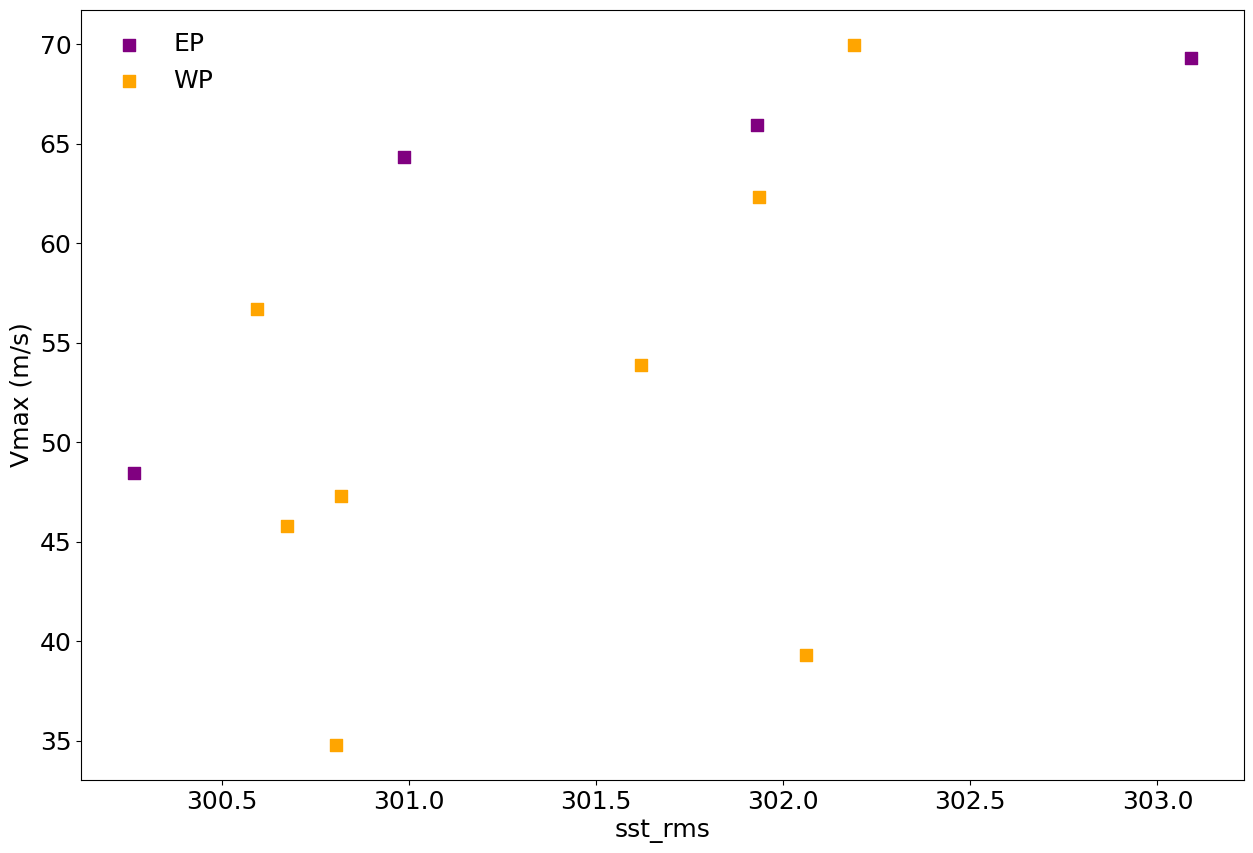

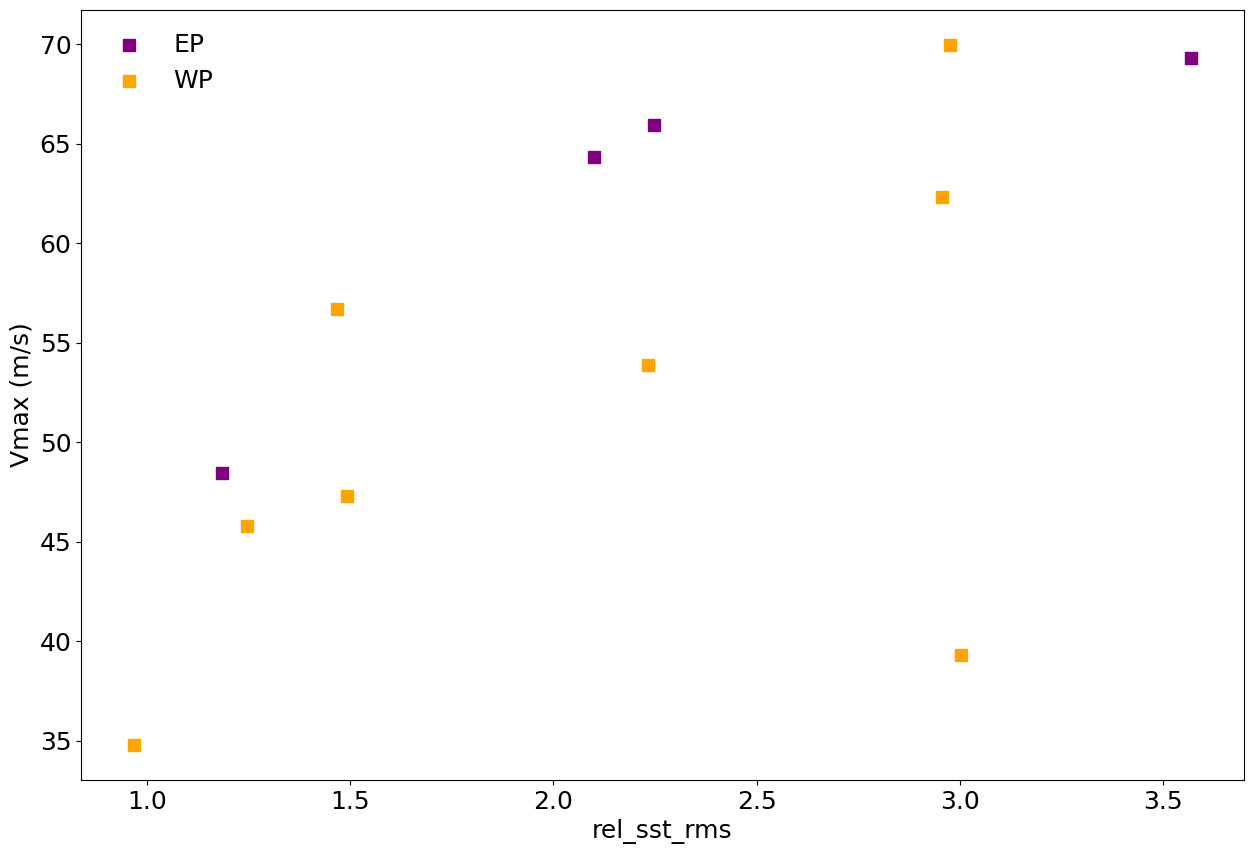

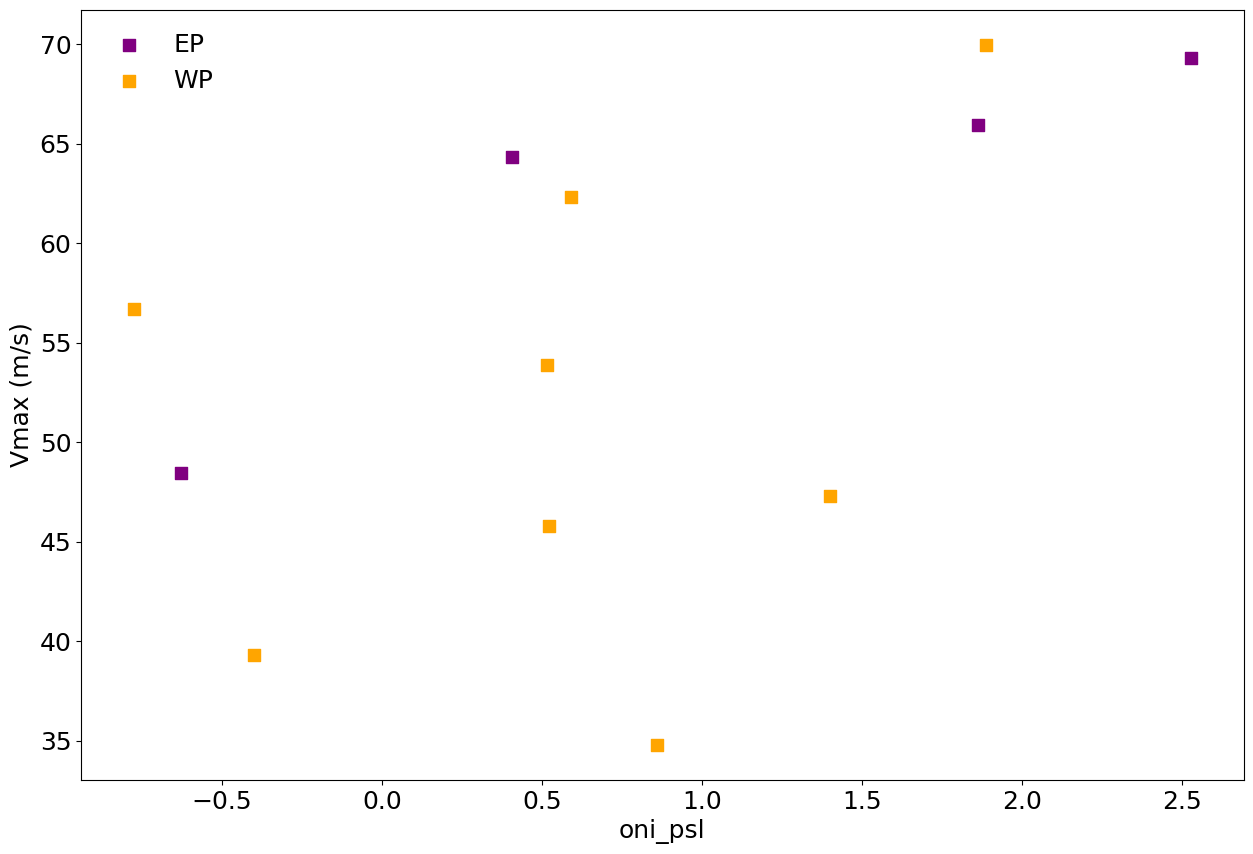

In [52]:
### SYNTHESIS
y = 'vmx'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Vmax (m/s)')
    plt.show()

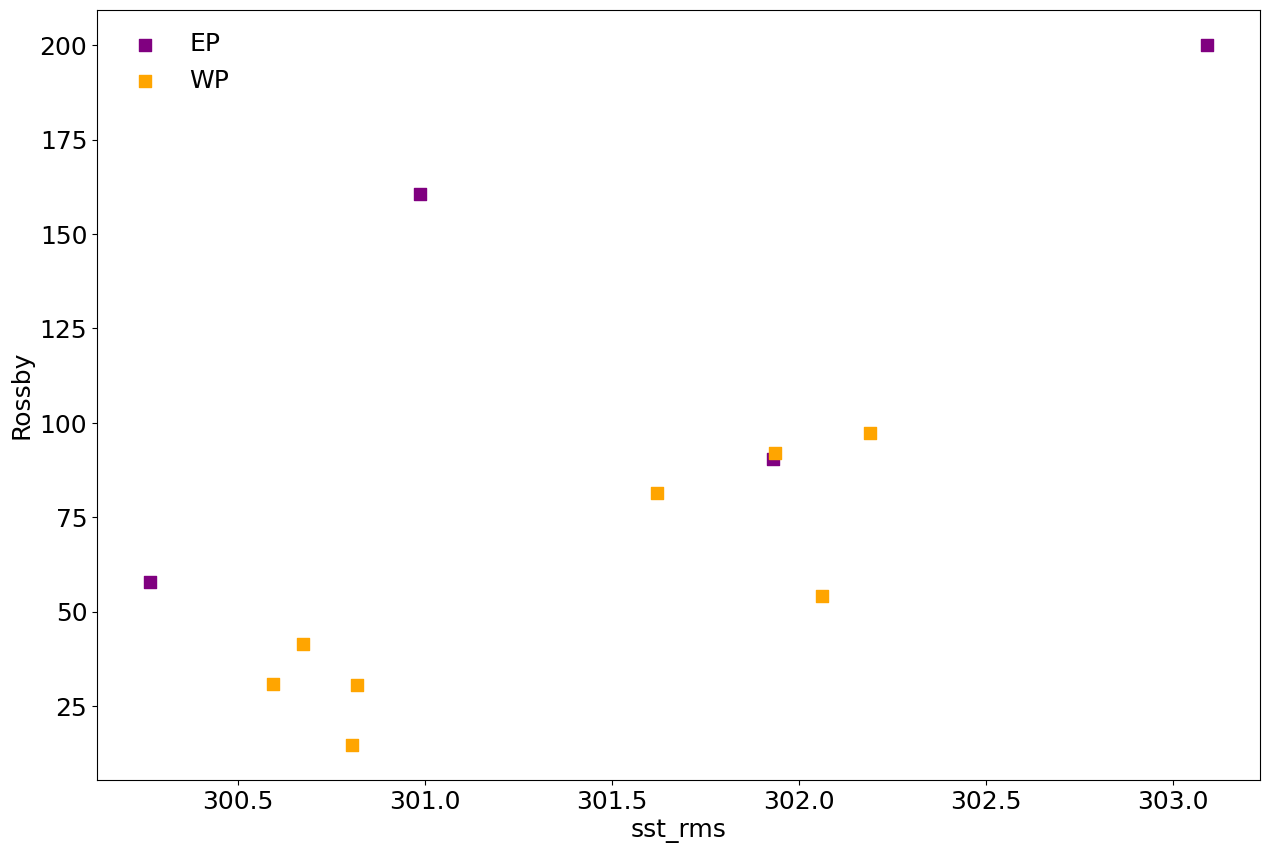

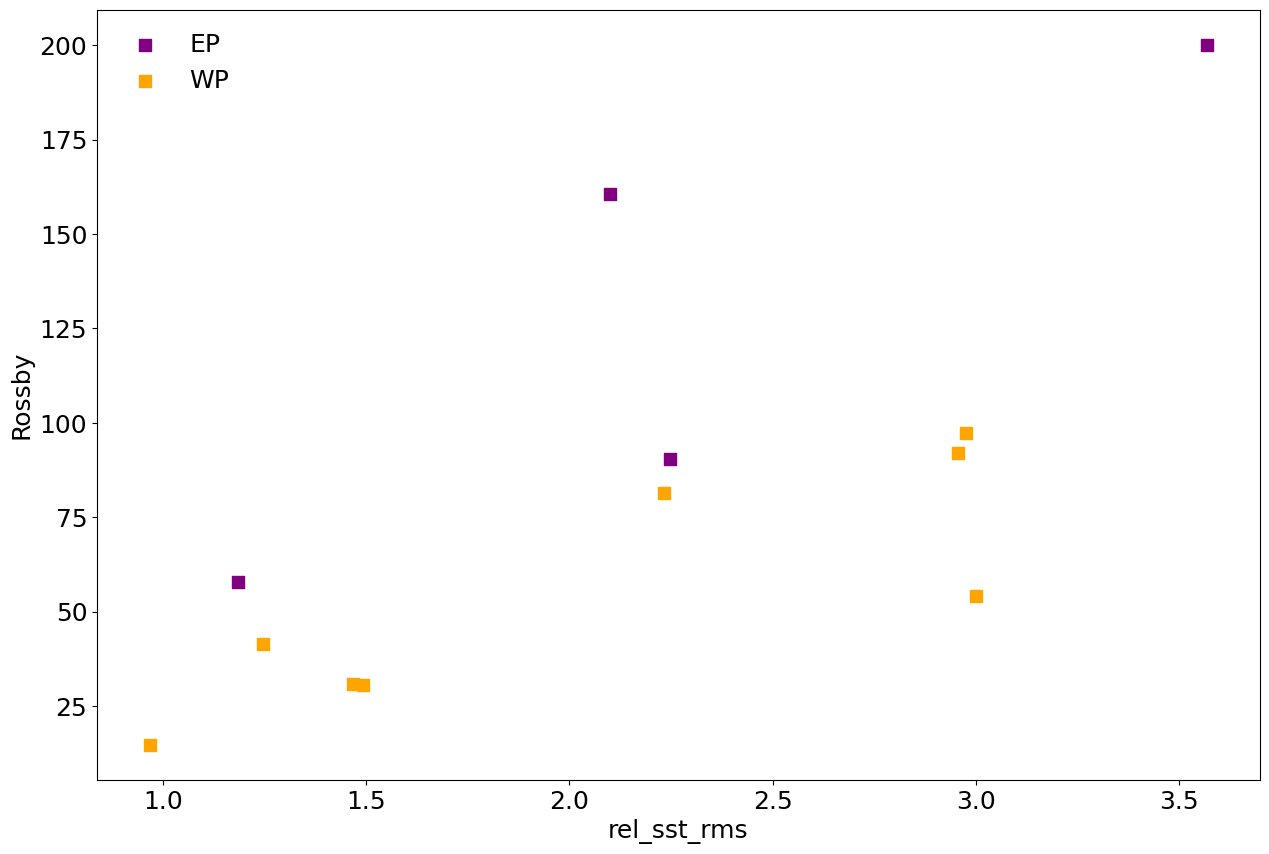

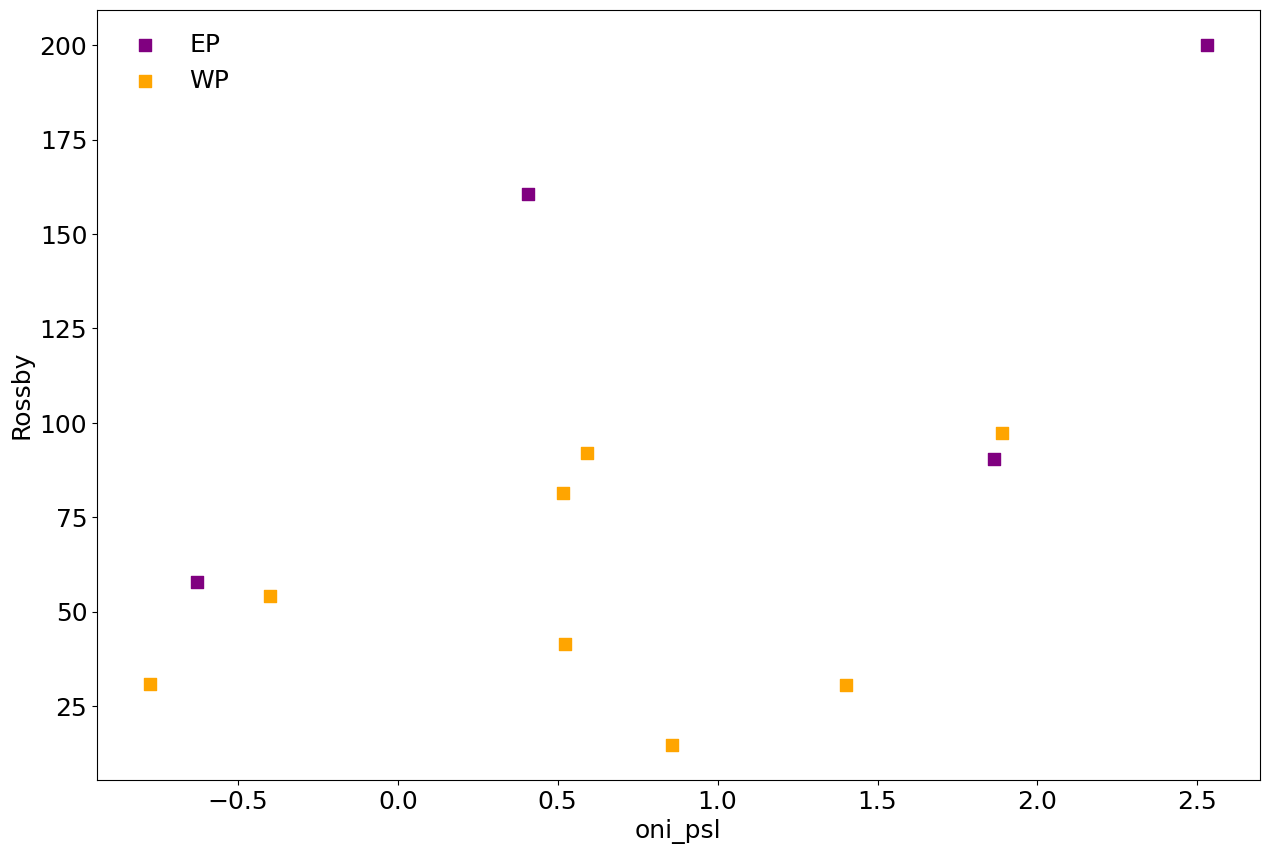

In [53]:
### SYNTHESIS
y = 'rsby'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Rossby')
    plt.show()

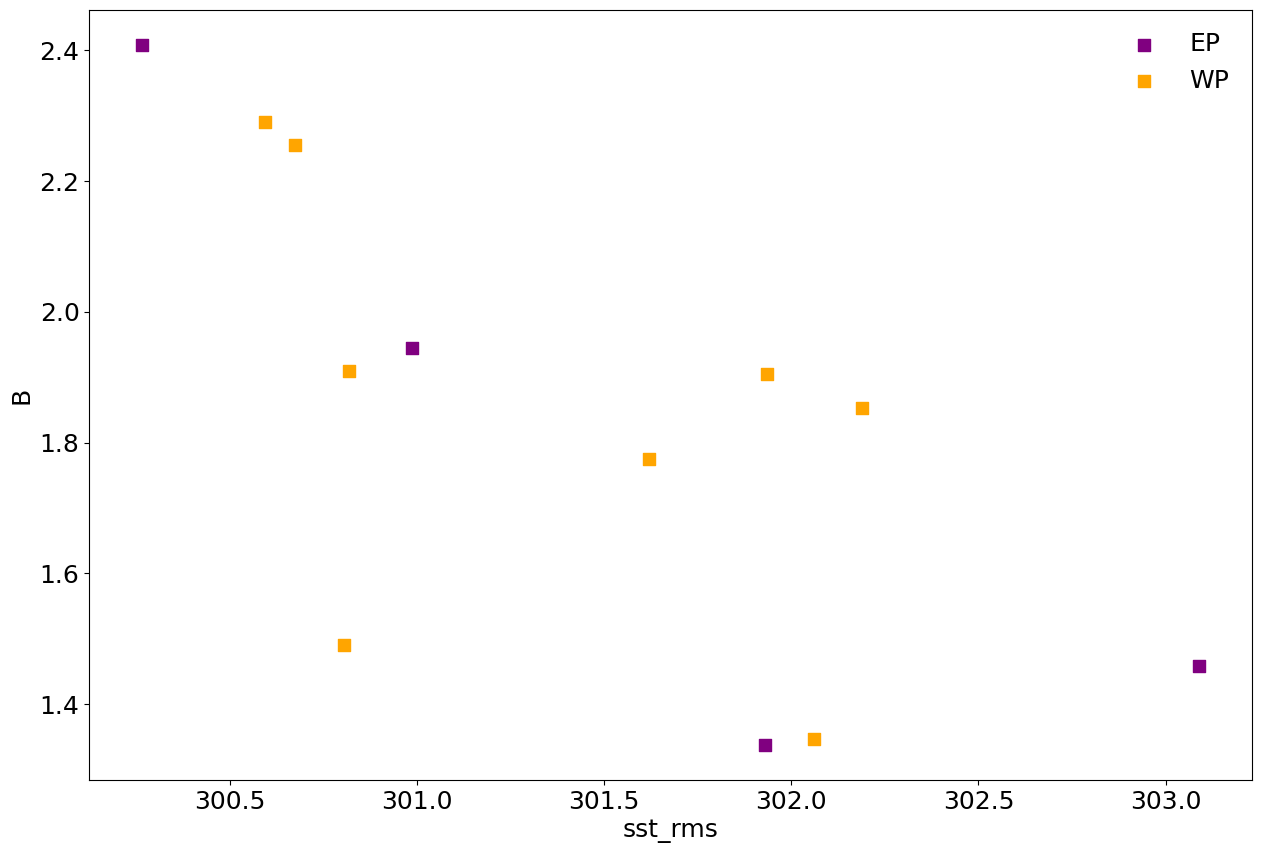

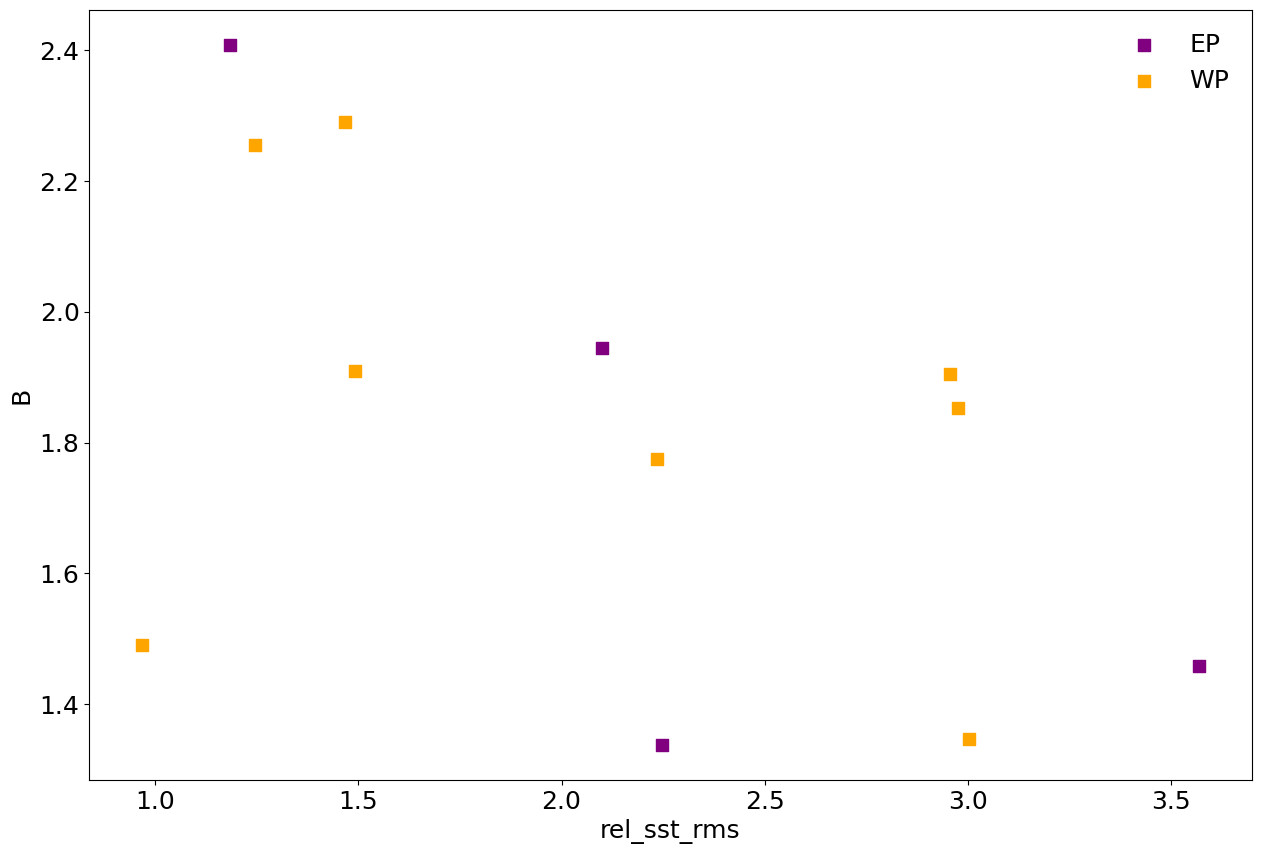

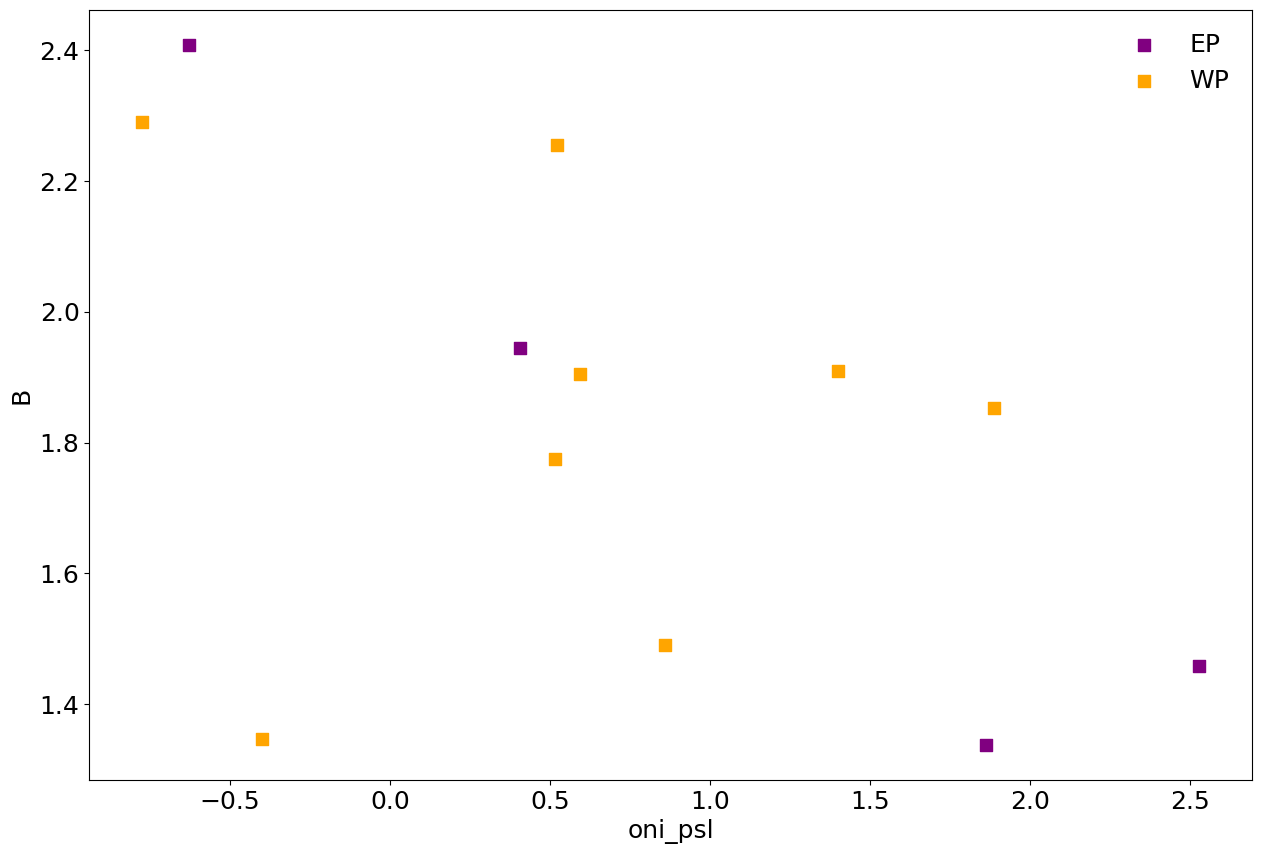

In [54]:
### SYNTHESIS
y = 'B_hol'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('B')
    plt.show()

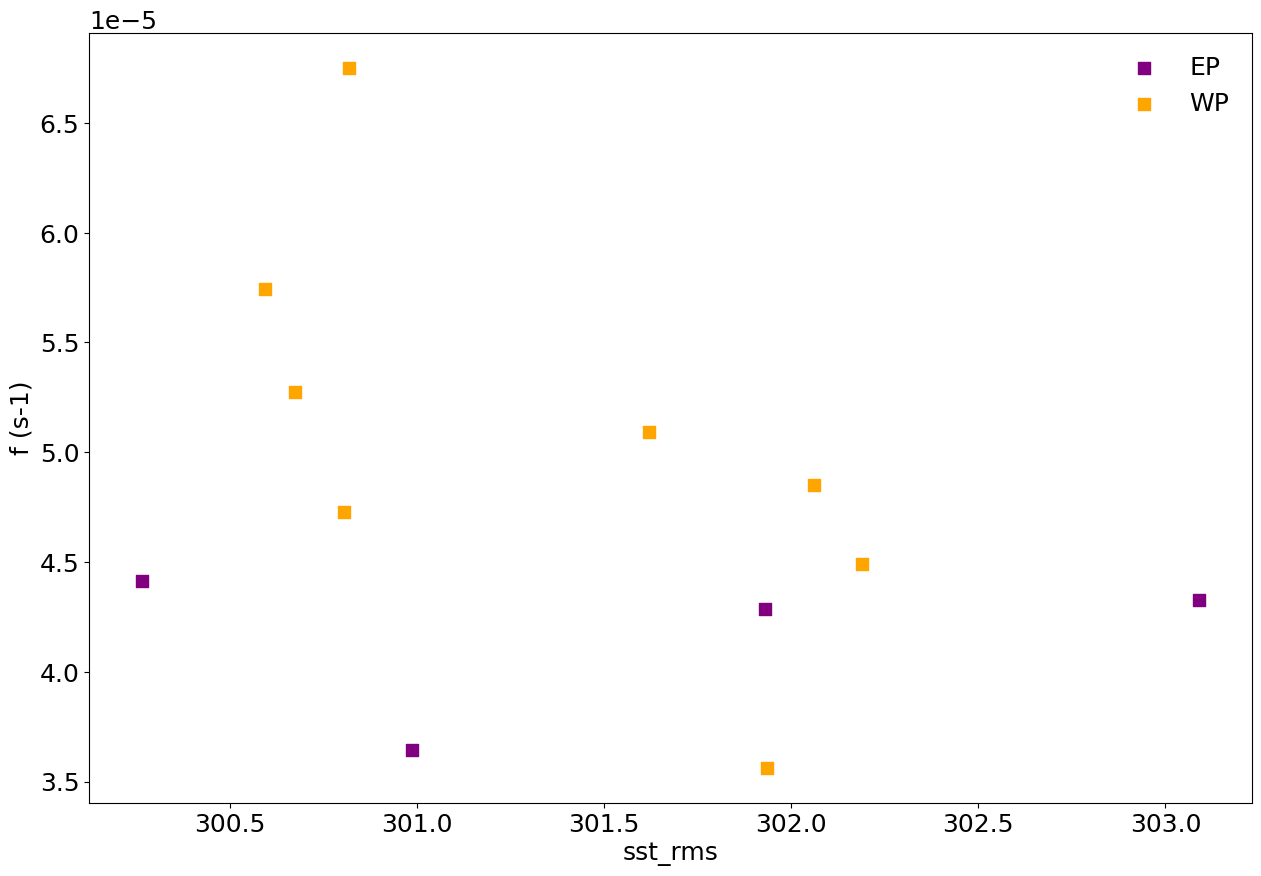

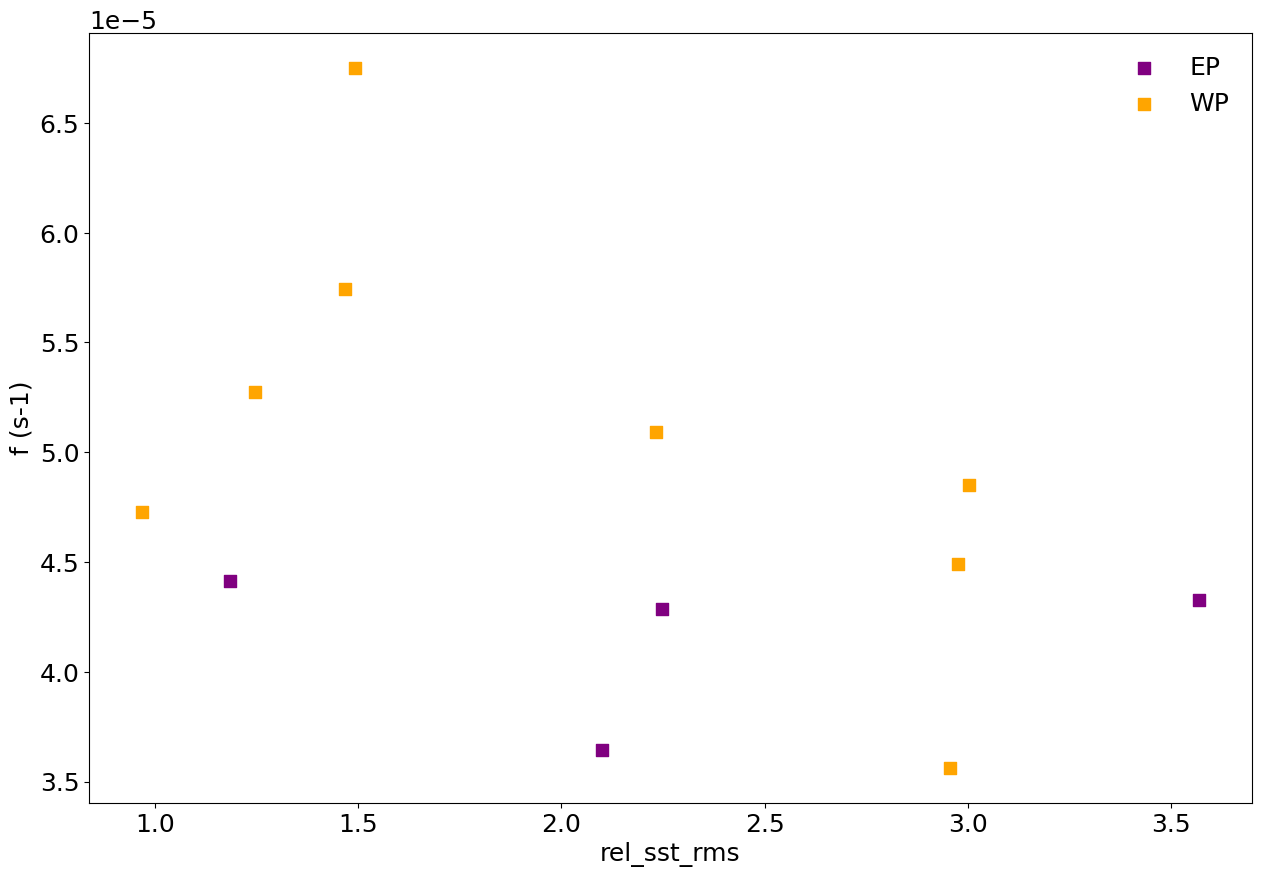

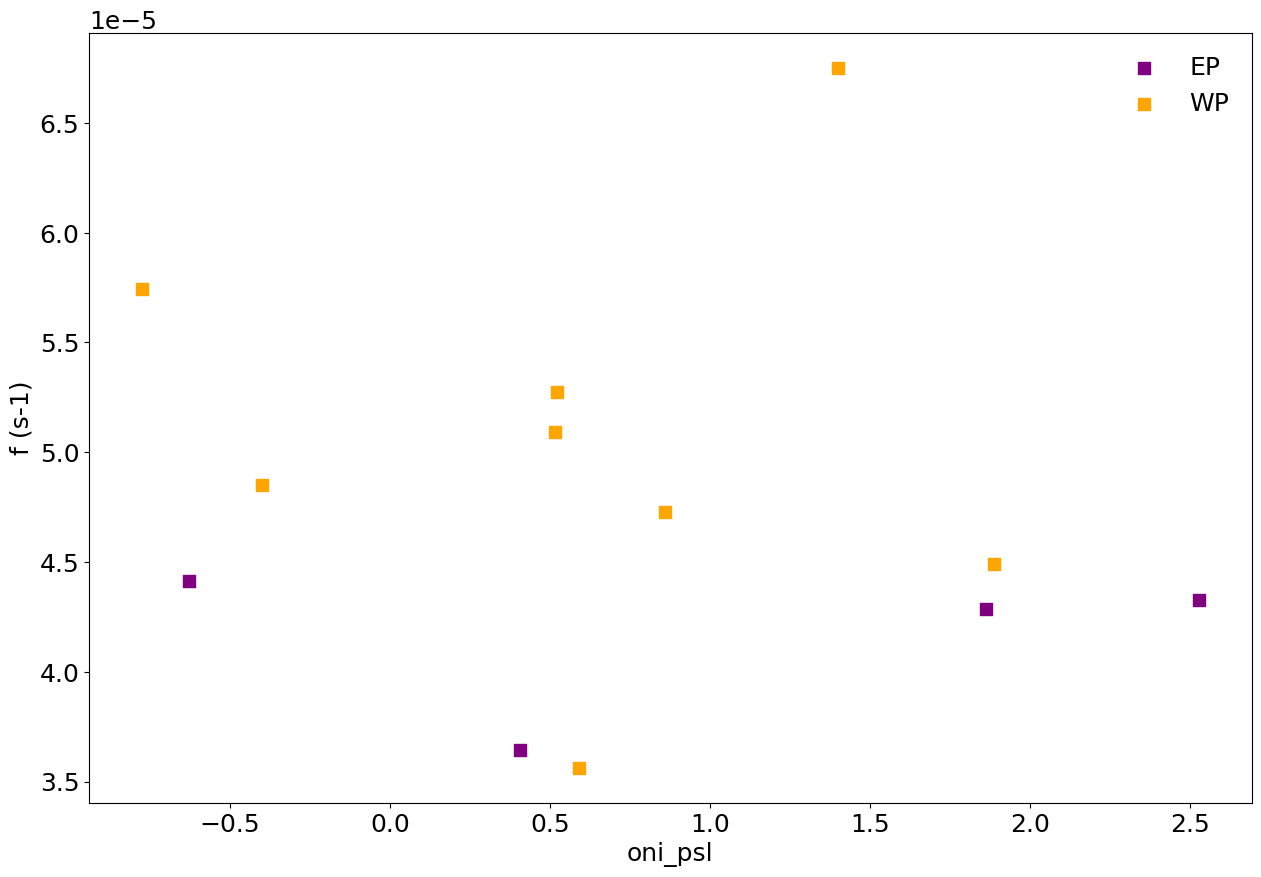

In [55]:
### SYNTHESIS
y = 'fcor'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], abs(de[y]), c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], abs(dw[y]), c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], abs(da[y]), c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], abs(ds[y]), c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('f (s-1)')
    plt.show()

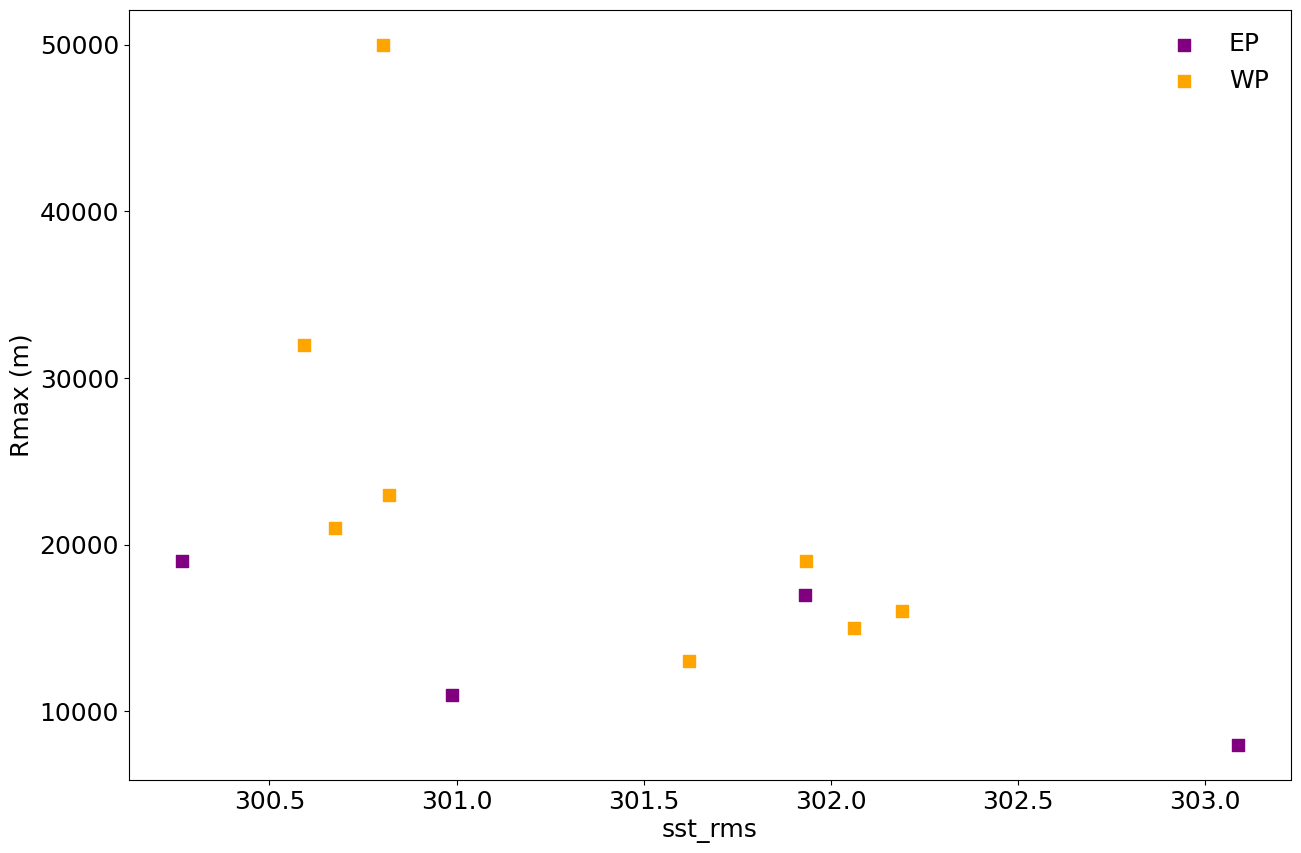

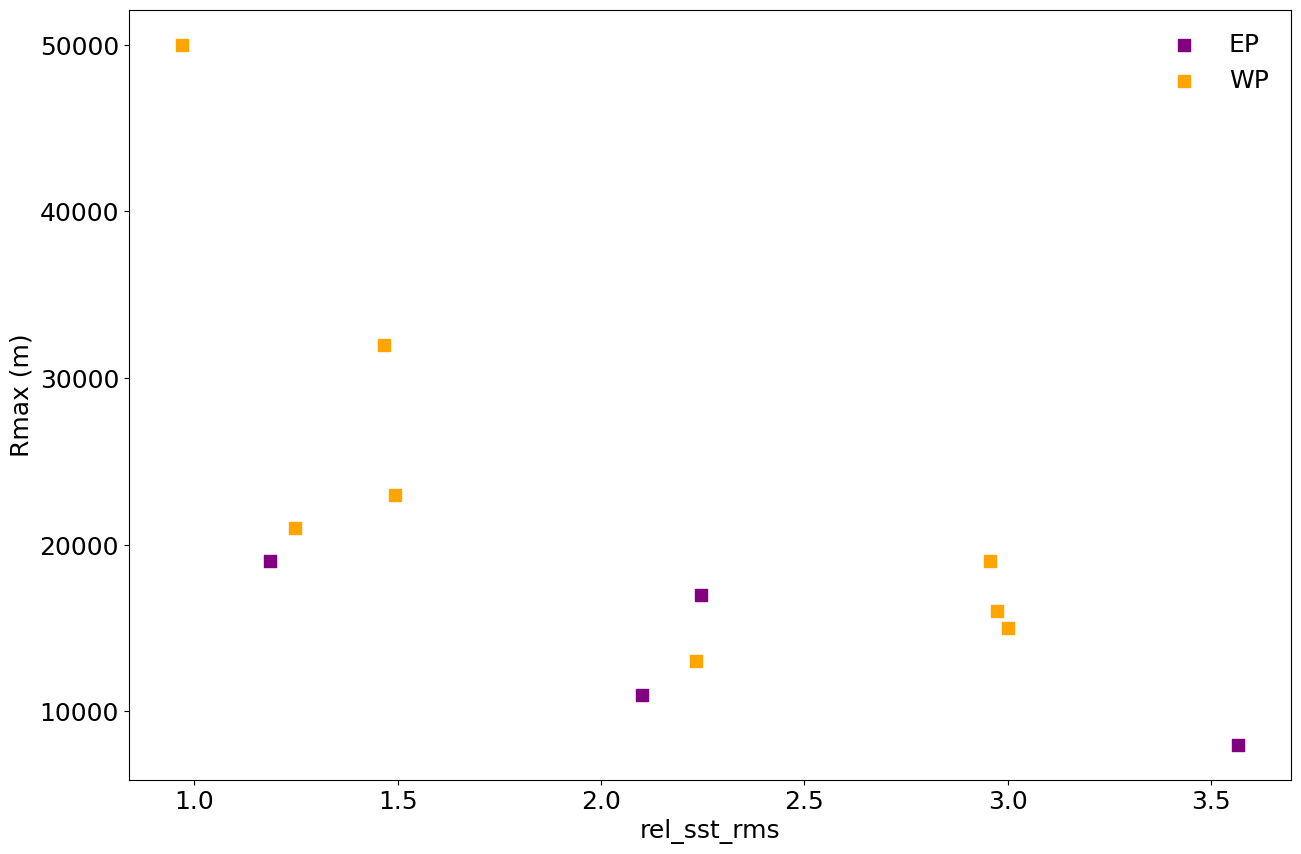

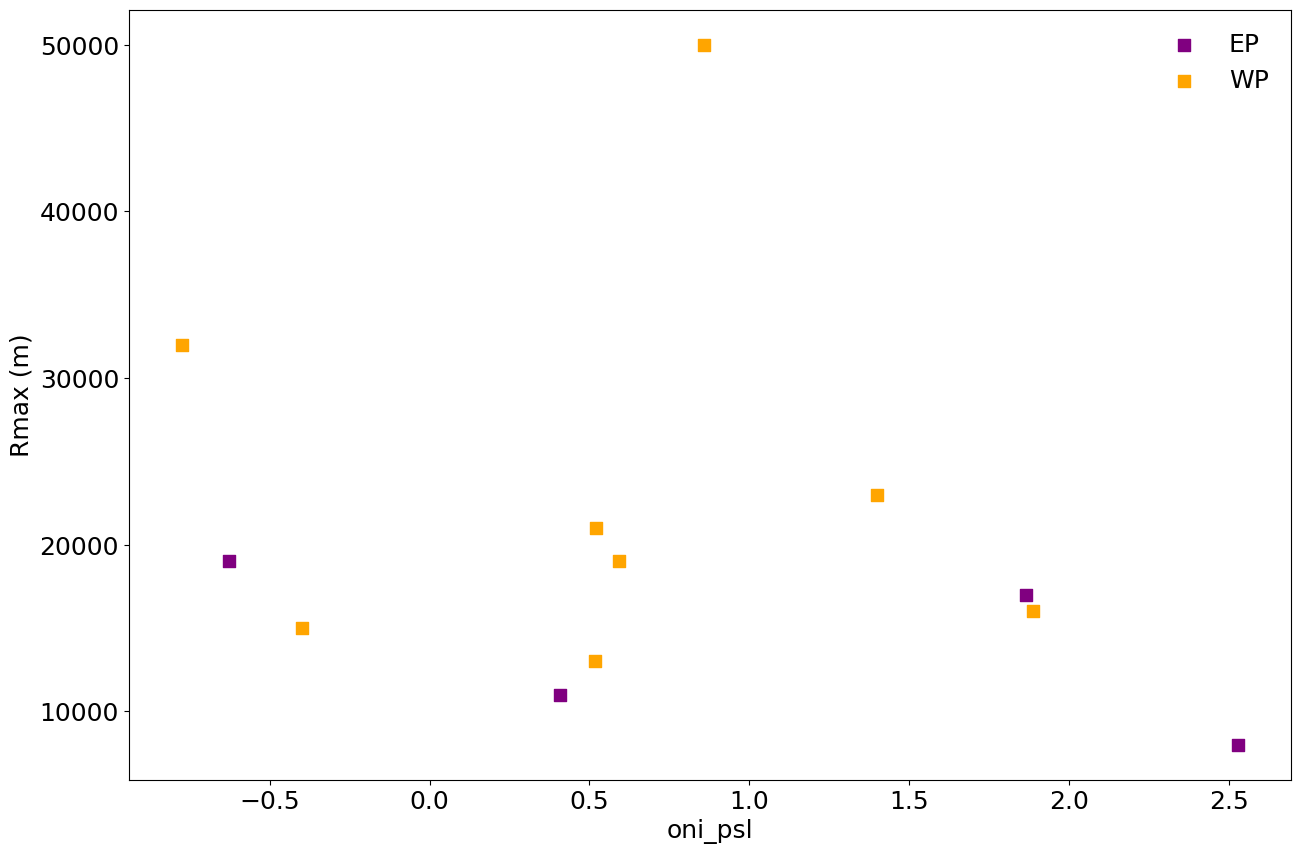

In [56]:
### SYNTHESIS
y = 'rmx'
for prm in ['sst_rms', 'rel_sst_rms', 'oni_psl']:
    plt.scatter(de[prm], de[y], c='purple', marker='s', s=80, label='EP')
    plt.scatter(dw[prm], dw[y], c='orange', marker='s', s=80, label='WP')
    # plt.scatter(da[prm], da[y], c='green',  marker='s', s=80, label='AL')
    # plt.scatter(ds[prm], ds[y], c='red',    marker='s', s=80, label='SH')
    plt.legend(frameon=False)
    plt.xlabel(prm)
    plt.ylabel('Rmax (m)')
    plt.show()

### 6) ENSO East Pacific

In [57]:
de = d.where(d.basin == 'ep', drop=True)

(array([28., 24.,  2.,  7., 15.,  1.,  0.,  0.,  4.,  2.]),
 array([-1.11729482e+00, -7.45237815e-01, -3.73180810e-01, -1.12380402e-03,
         3.70933201e-01,  7.42990207e-01,  1.11504721e+00,  1.48710422e+00,
         1.85916122e+00,  2.23121823e+00,  2.60327523e+00]),
 <BarContainer object of 10 artists>)

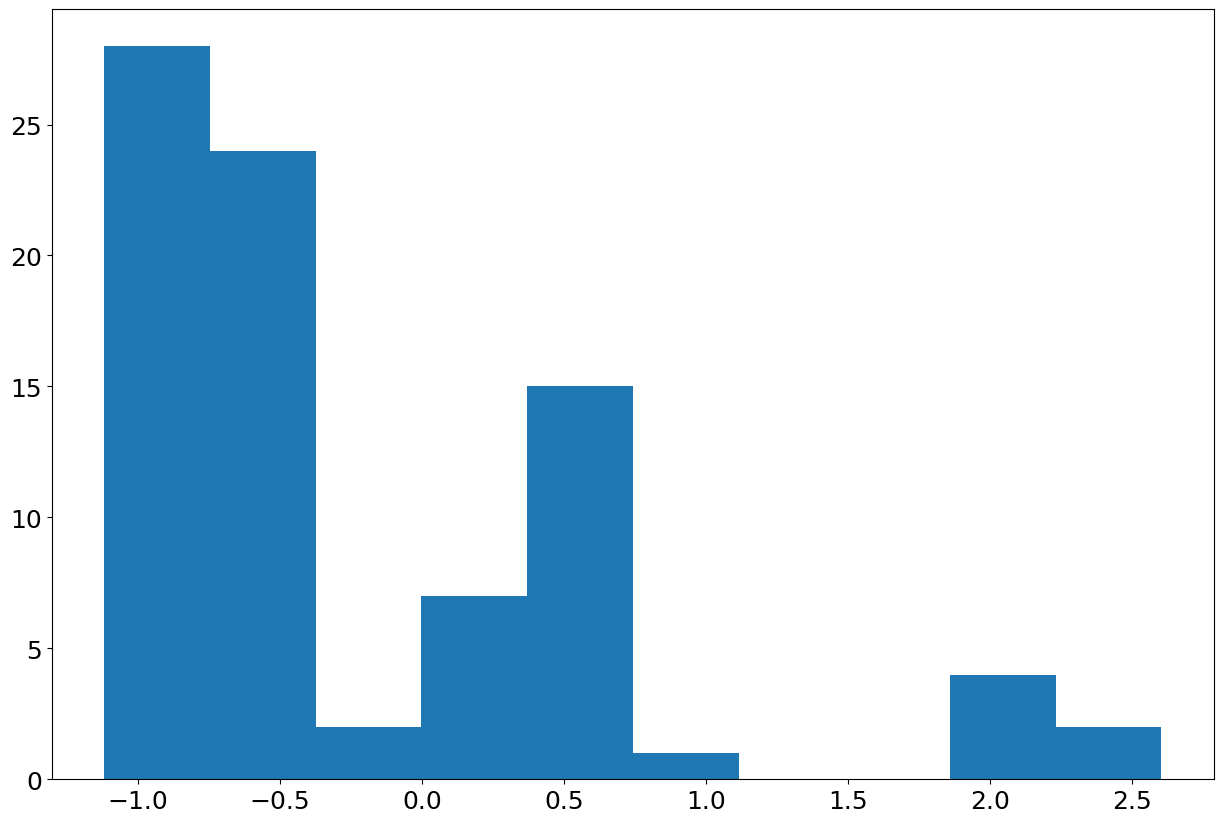

In [58]:
plt.hist(de.oni_7mths_psl)

In [59]:
de_hgh = de.where(de.oni_7mths_psl > 0.8,  drop=True)
de_low = de.where(de.oni_7mths_psl < -0.8, drop=True)

(-72.0, 72.0)

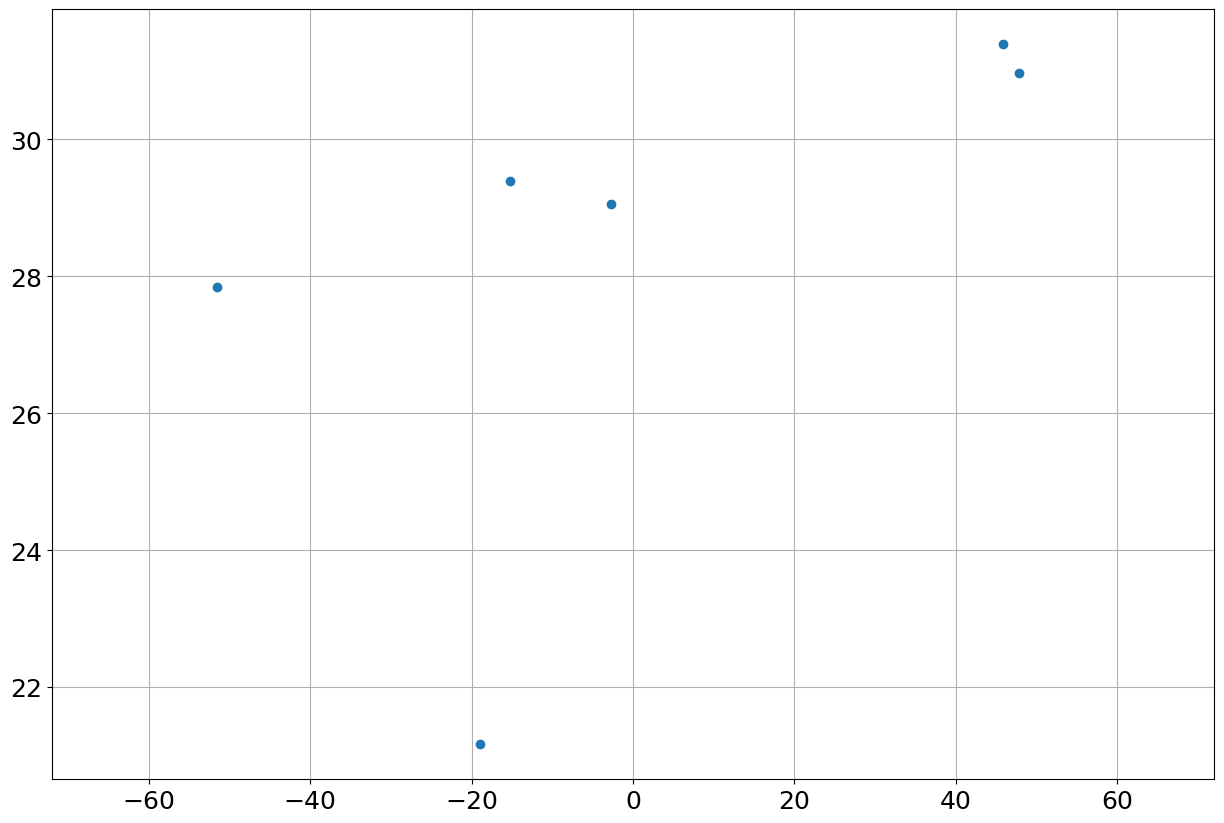

In [60]:
plt.scatter(de_hgh.t_since_lmi_ibt / 3600, de_hgh.uc)
plt.grid()
plt.xlim(-72, 72)

In [61]:
de_hgh.uc

<xarray.DataArray 'uc' (time: 6)>
array([30.97023993, 21.16763931, 27.83899465, 29.38457496, 29.04964083,
       31.38797818])
Coordinates:
  * time     (time) datetime64[ns] 2016-07-08T02:46:14 ... 2016-09-02T03:53:41
Attributes:
    long_name:    Charac. velocity
    description:  np.sqrt(3 * np.sqrt(2) * dsg.vmx ** 2 / np.sqrt(dsg.B_hol *...
    units:        m/s

In [62]:
de_hgh.rsby

<xarray.DataArray 'rsby' (time: 6)>
array([25.00572465, 39.86328756, 32.15352646, 54.65218505, 57.74706327,
       49.94543448])
Coordinates:
  * time     (time) datetime64[ns] 2016-07-08T02:46:14 ... 2016-09-02T03:53:41
Attributes:
    long_name:    Maximal Rossby number
    description:  Vmax / (f Rmax)

In [63]:
de_hgh.file

<xarray.DataArray 'file' (time: 6)>
array([array('rs2--owi-cm-20160708t024536-20160708t024652-00003-______sw.nc',
             dtype=object)                                                   ,
       array('rs2--owi-cm-20160724t140547-20160724t140702-00003-______sw.nc',
             dtype=object)                                                   ,
       array('rs2--owi-cm-20160829t022730-20160829t023009-00003-______sw.nc',
             dtype=object)                                                   ,
       array('s1a-ew-owi-cm-20160830t144512-20160830t144658-000003-0143DB_sw.nc',
             dtype=object)                                                       ,
       array('s1a-ew-owi-cm-20160831t031520-20160831t031712-000003-014425_sw.nc',
             dtype=object)                                                       ,
       array('rs2--owi-cm-20160902t035139-20160902t035544-00003-______sw.nc',
             dtype=object)                                                   ],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-08T02:46:14 ... 2016-09-02T03:53:41
Attributes:
    long_name:    Satellite file of the SAR acquisition
    description:  Taken from Ifremer TCVA product

(-72.0, 72.0)

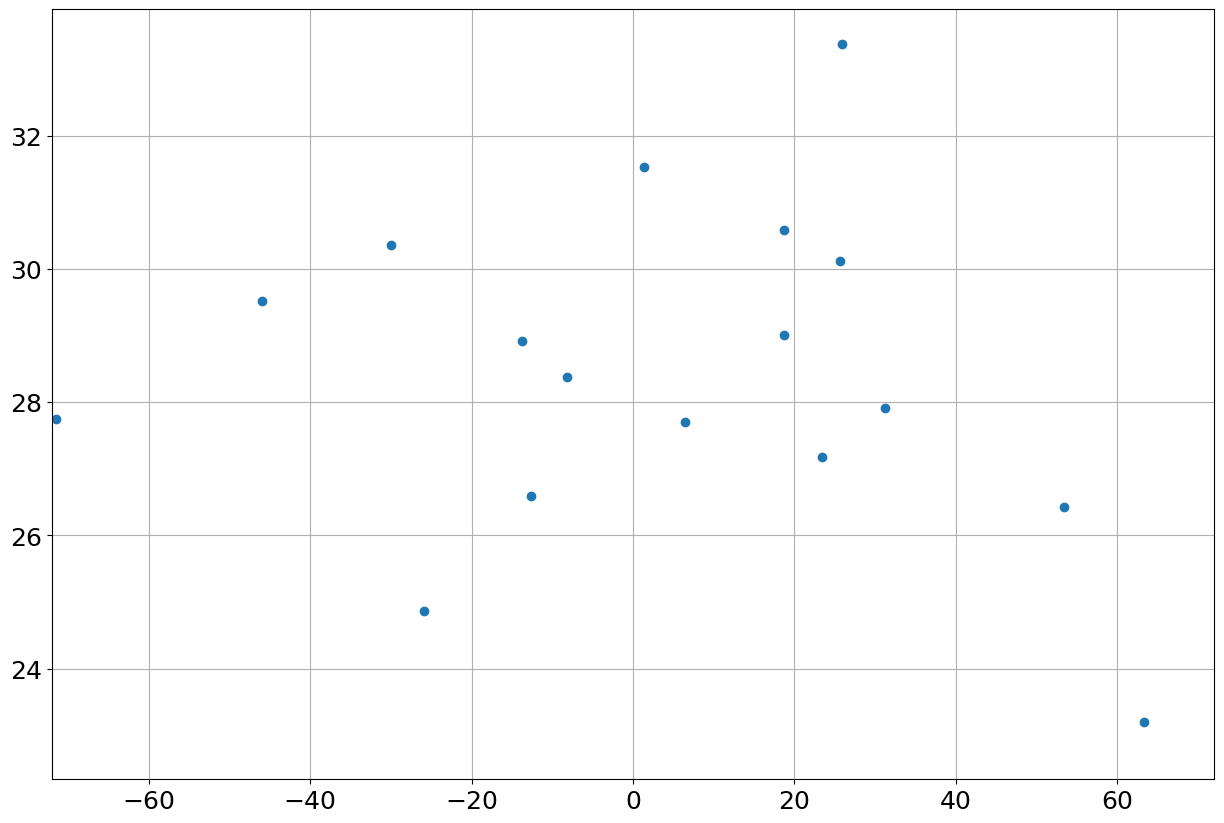

In [64]:
plt.scatter(de_low.t_since_lmi_ibt / 3600, de_low.uc)
plt.grid()
plt.xlim(-72, 72)

In [65]:
dle      = de.where((de.t_since_lmi_ibt / 3600 > -3 * hrs_thr) & (de.t_since_lmi_ibt / 3600 < 3 * hrs_thr), drop=True)

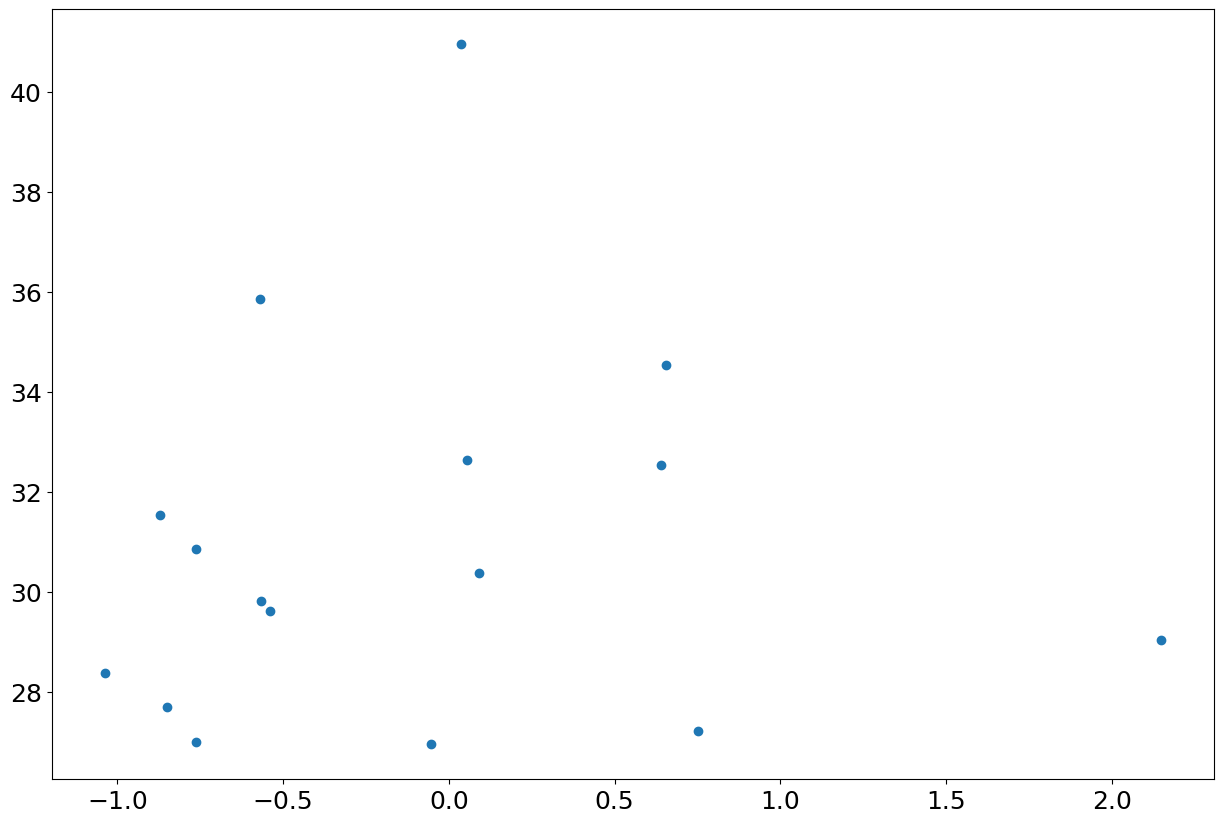

In [66]:
plt.scatter(dle.oni_7mths_psl, dle.uc)

### 7) Stationary cases

In [67]:
c_min = abs(d.dKdt).quantile(0.33)
d.where(d.dKdt < c_min, drop=True)

<xarray.Dataset>
Dimensions:              (time: 163)
Coordinates:
  * time                 (time) datetime64[ns] 2013-07-01T10:41:57 ... 2024-0...
    quantile             float64 0.33
Data variables: (12/76)
    dist2coast           (time) float64 8.115e+04 1.992e+05 ... 1.045e+05
    speed                (time) float64 5.97 5.511 6.246 ... 2.564 4.575 7.474
    name                 (time) object RUMBIA RAMMASUN ... EWINIAR EWINIAR
    id                   (time) object wp062013 wp092014 ... wp012024 wp012024
    file                 (time) object rs2--owi-cm-20130701t104119-20130701t1...
    file_tcva            (time) object rs2--owi-ca-20130701t104119-20130701t1...
    ...                   ...
    beta0_pmd            (time) float64 1.349e+04 1.326e+04 ... 1.73e+04
    beta0_T0_pmd         (time) float64 52.55 51.1 49.22 ... 53.28 63.65 63.96
    beta0                (time) float64 411.3 532.1 950.0 ... 212.9 282.1 569.8
    beta0_T0             (time) float64 1.566 2.022 3.607 ... 0.8107 1.073 2.171
    dKdt                 (time) float64 -0.03188 -0.1493 ... 0.08561 0.0788
    basin_idx            (time) float64 3.0 3.0 3.0 3.0 2.0 ... 5.0 3.0 3.0 3.0
Attributes:
    Version:            1.0
    SAR_wind_product:   Ifremer (https://cyclobs.ifremer.fr/app/tropical), co...
    Best_track_data:    IBTrACS (https://www.ncei.noaa.gov/products/internati...
    SST_product:        REMSS, collocated with tropical cyclones during MAXSS...
    Authors:            Arthur Avenas, Alexis Mouche, Théo Cevaer
    Contact:            arthur.avenas@esa.int
    TC-PRIMED_product:  Version v01r01-preliminary, created 2024-09-08T06:24:...

Text(0, 0.5, 'Uc (m/s)')

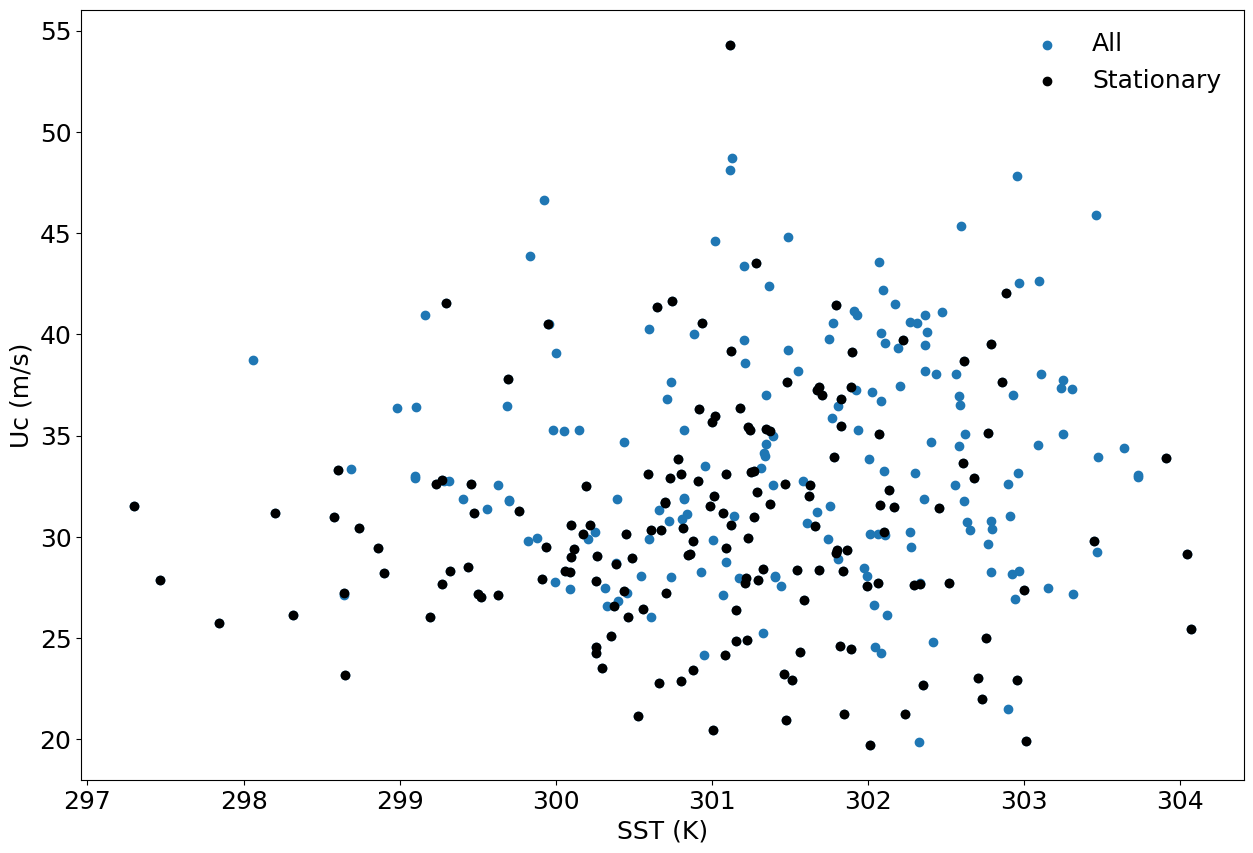

In [68]:
plt.scatter(d.sst_rms, d.uc, label='All')
plt.scatter(d.where(d.dKdt < c_min, drop=True).sst_rms, d.where(d.dKdt < c_min, drop=True).uc, c='k', label='Stationary')
plt.legend(frameon=False)
plt.xlabel('SST (K)')
plt.ylabel('Uc (m/s)')

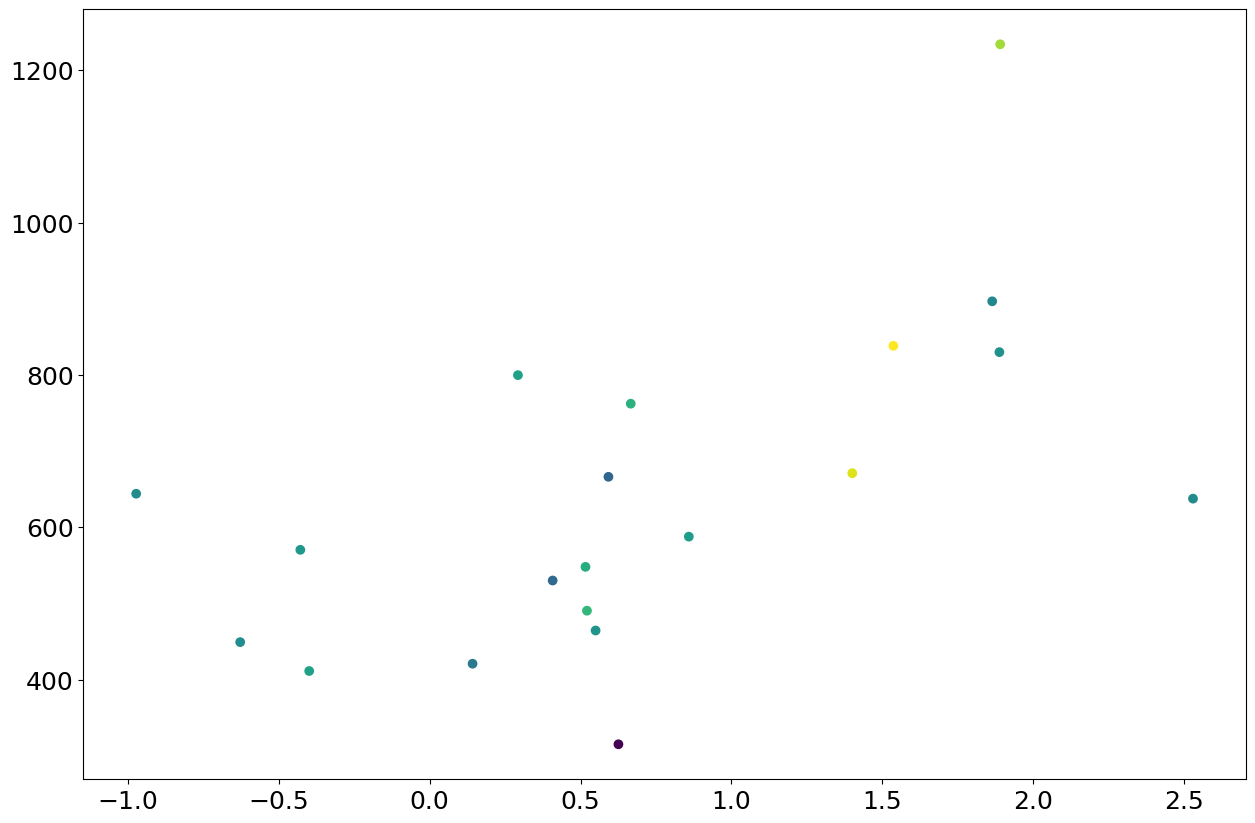

In [69]:
plt.scatter(dl.oni_psl, dl.beta0, c=abs(dl.fcor))

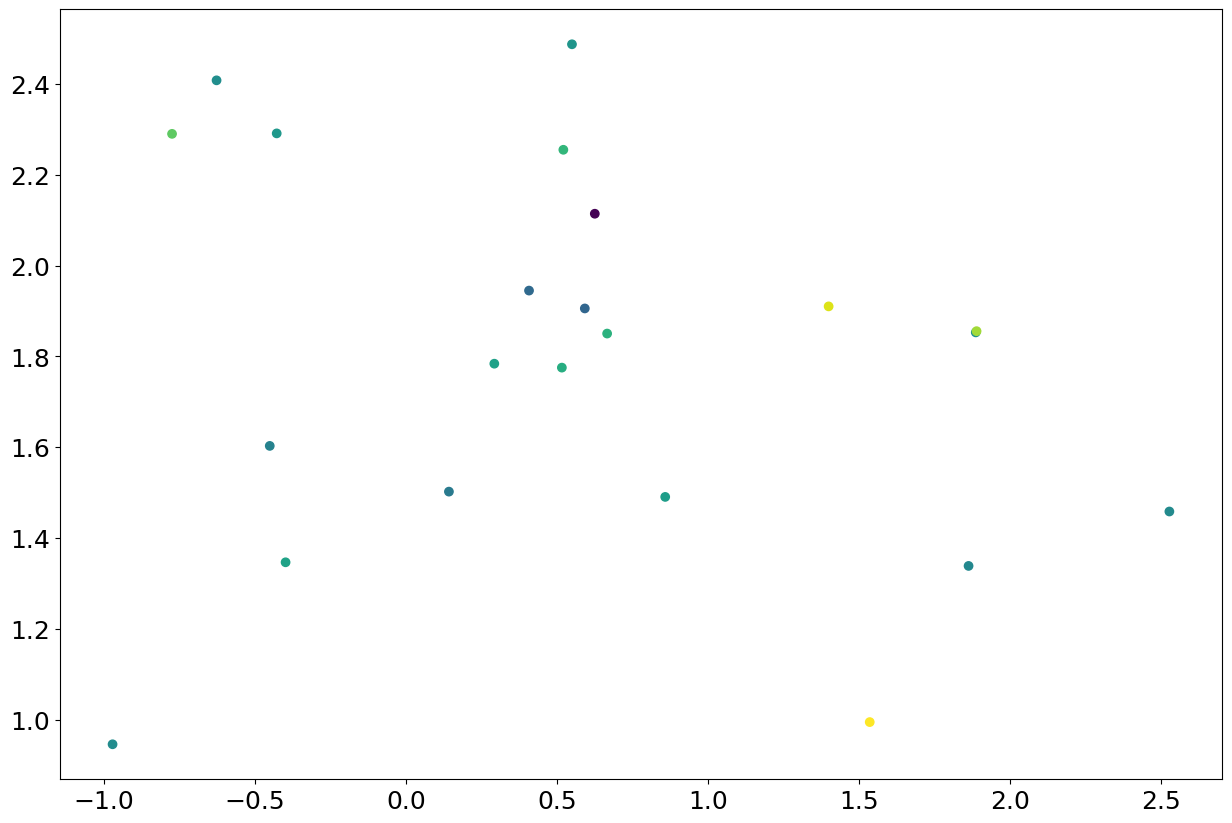

In [70]:
plt.scatter(dl.oni_psl, dl.B_hol, c=abs(dl.fcor))

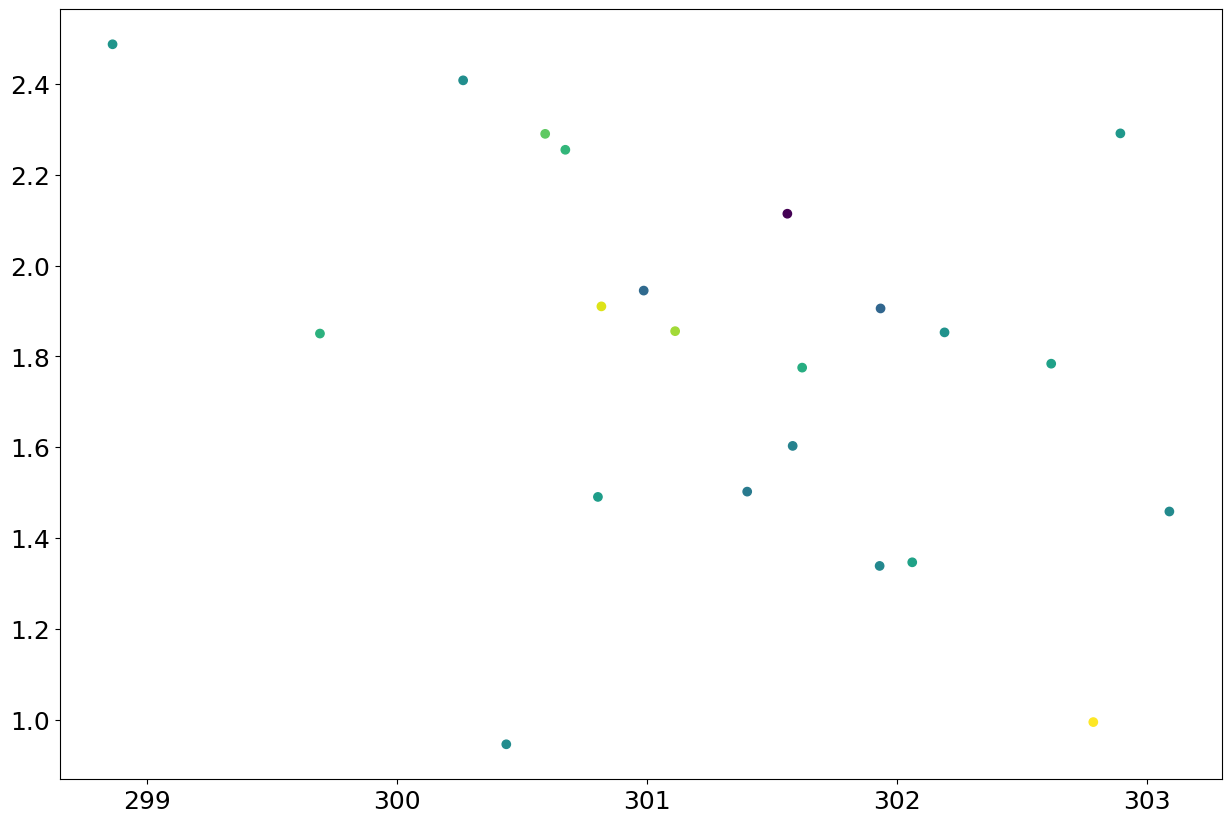

In [71]:
plt.scatter(dl.sst_rms, dl.B_hol, c=abs(dl.fcor))

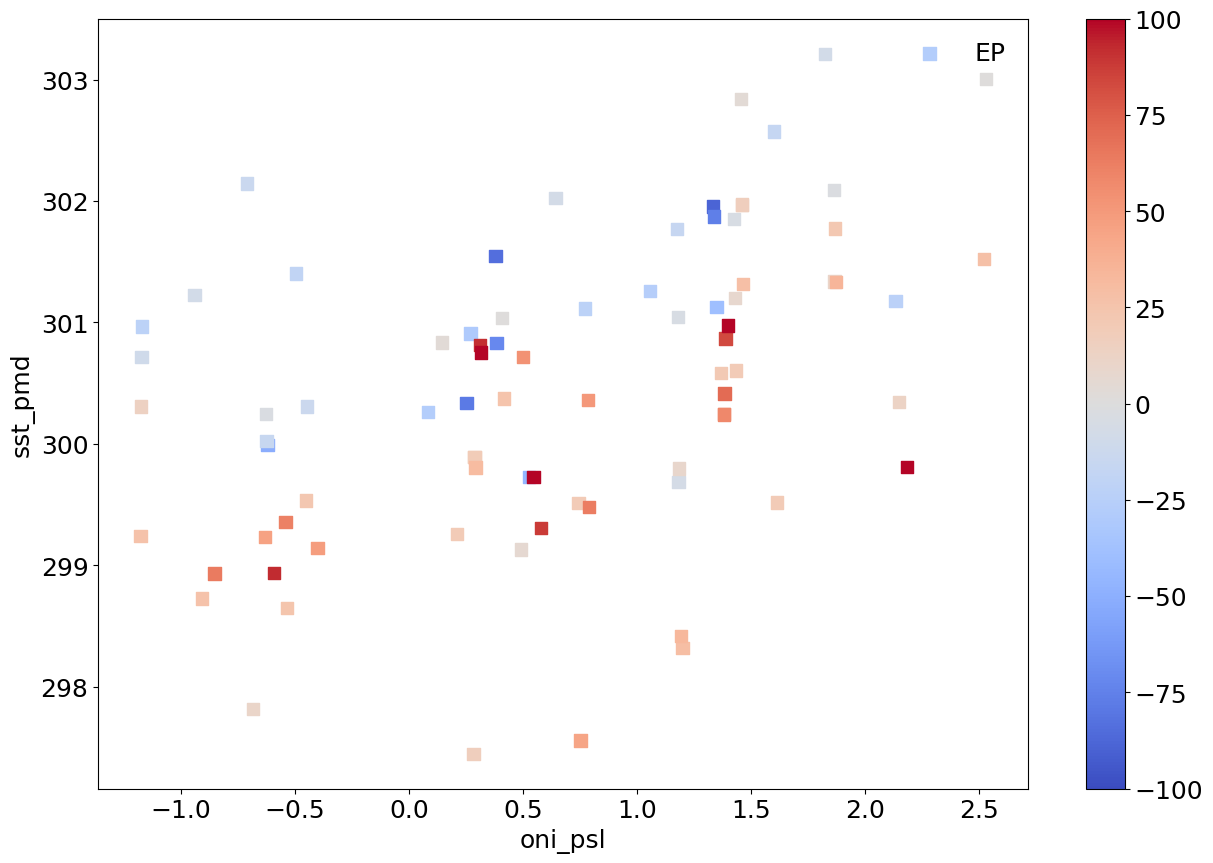

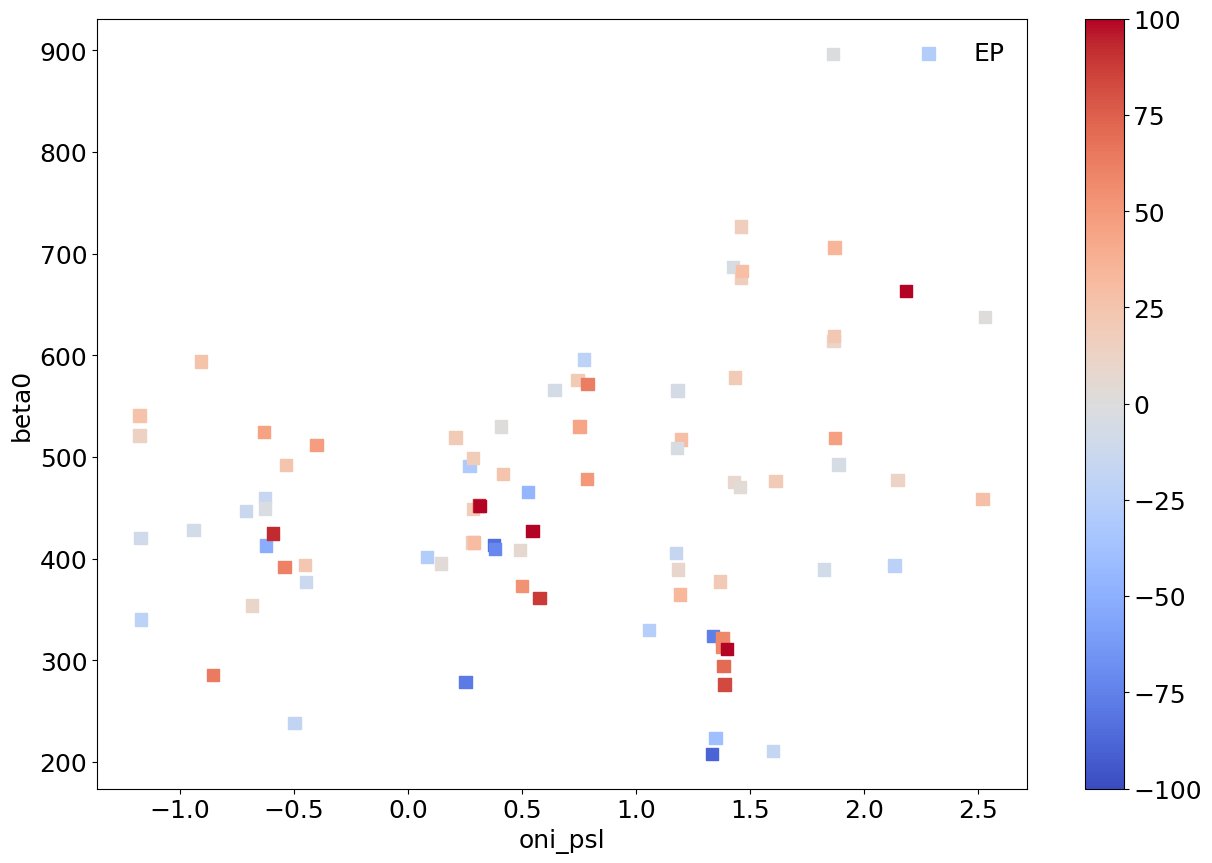

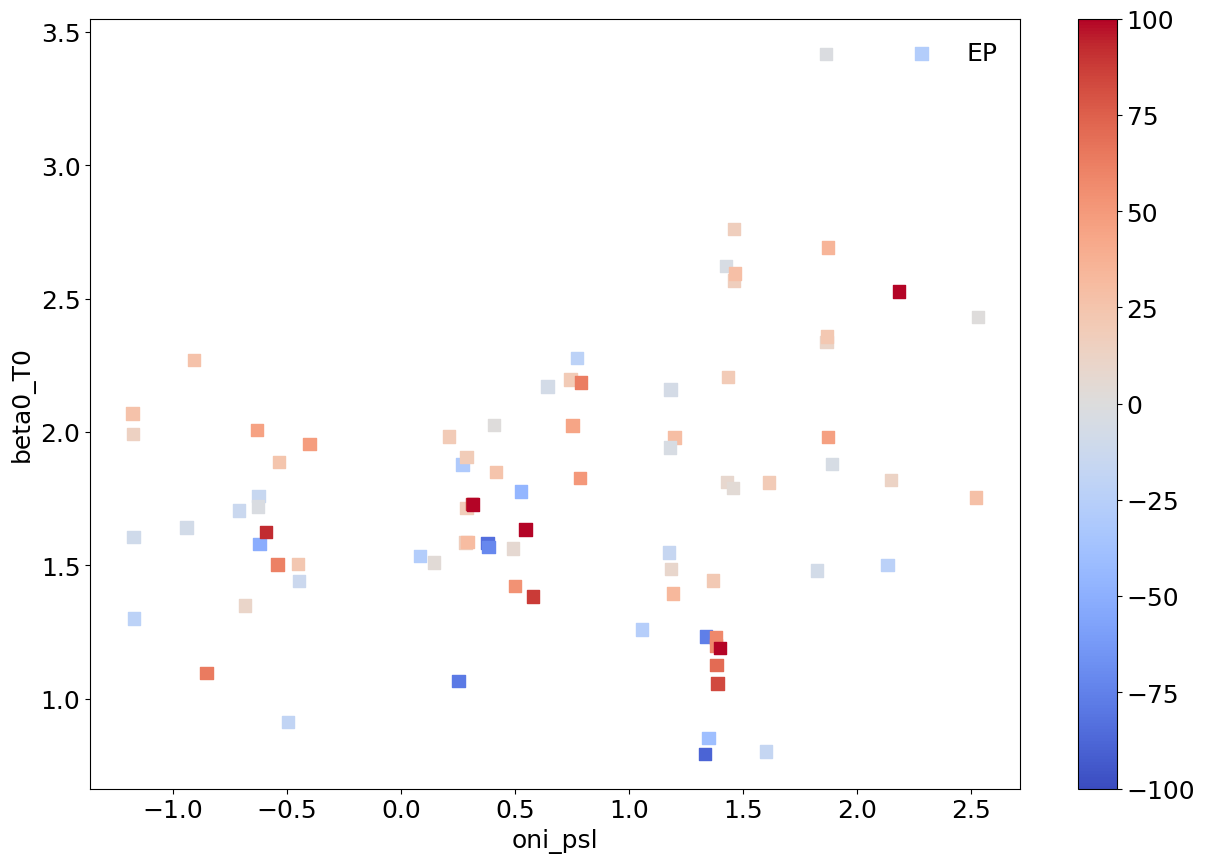

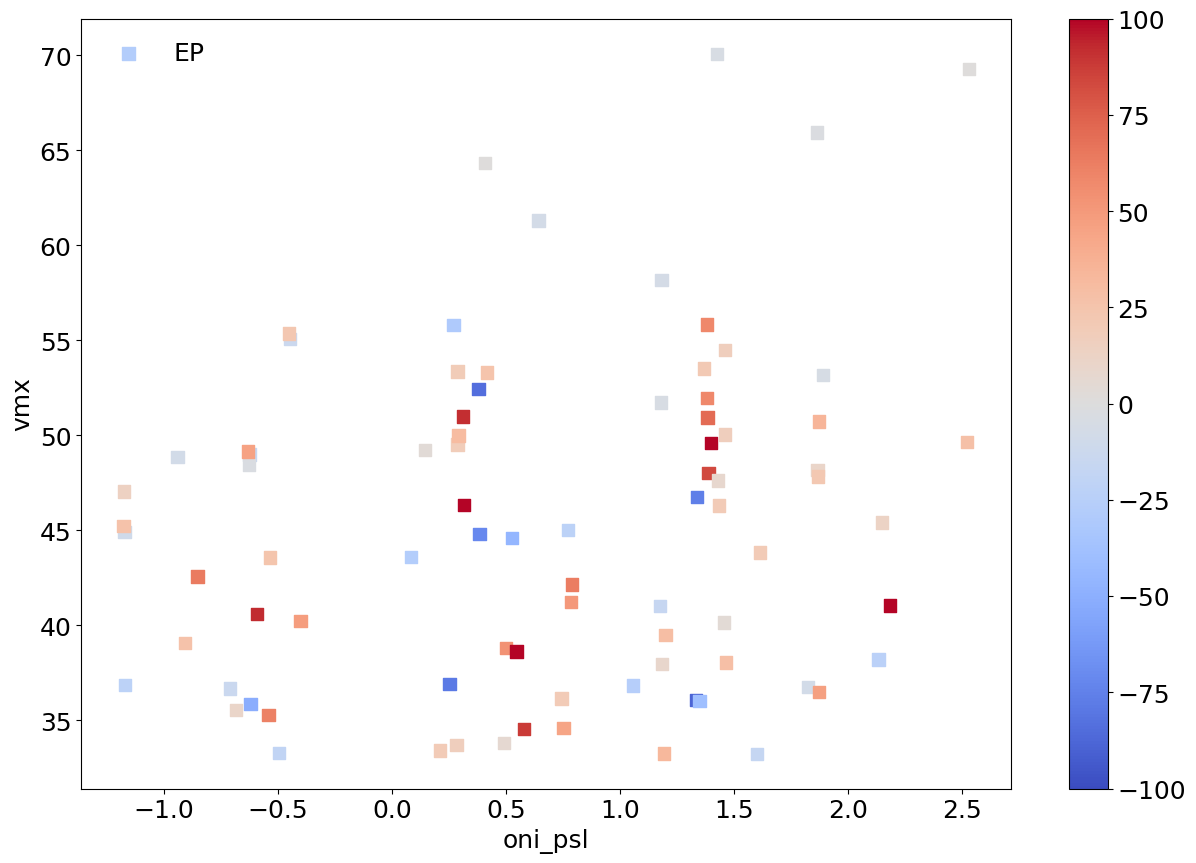

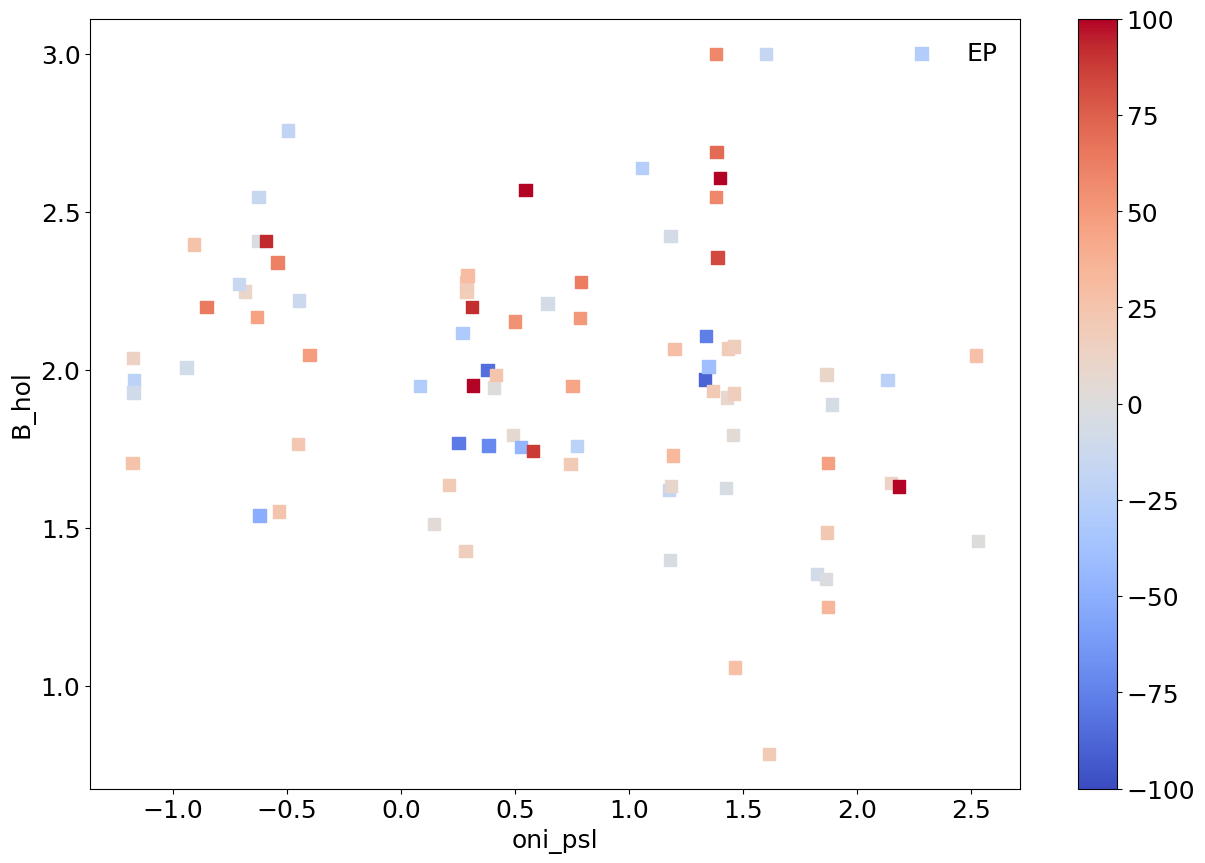

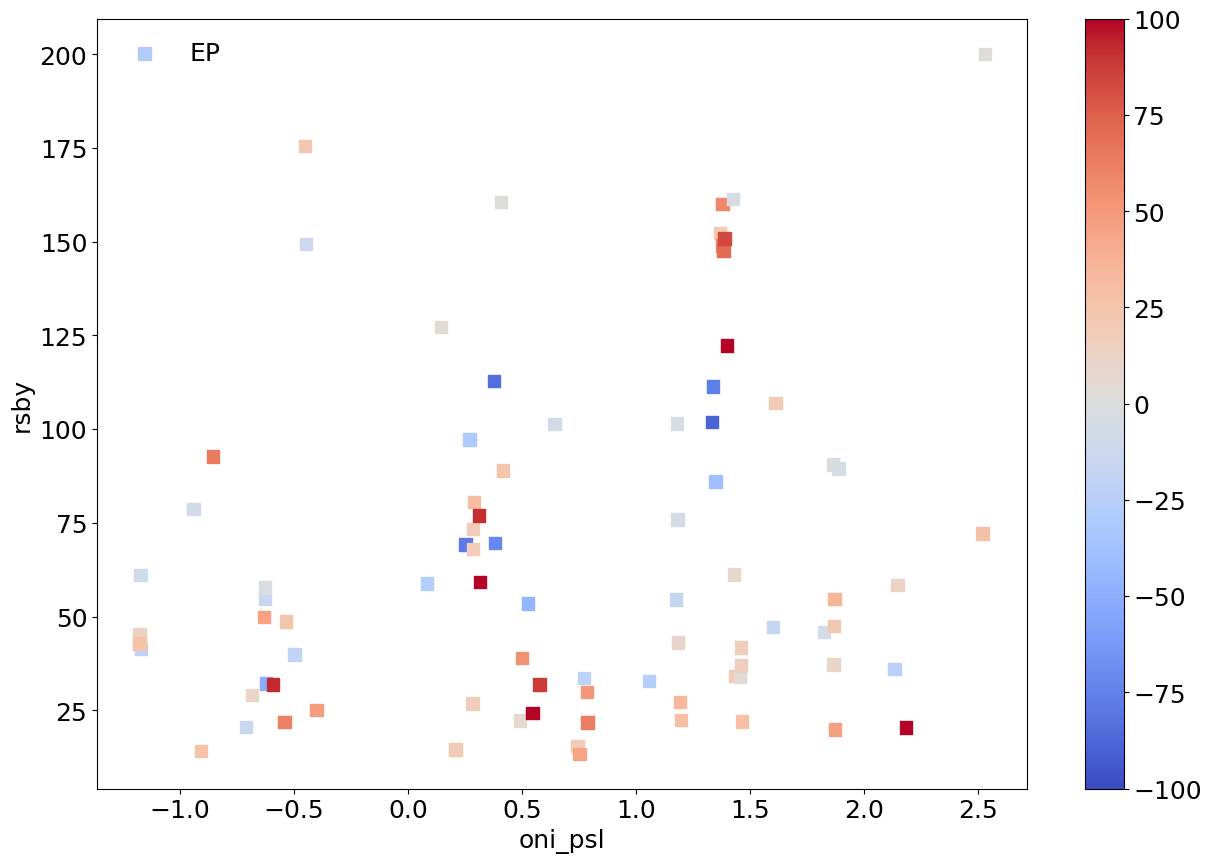

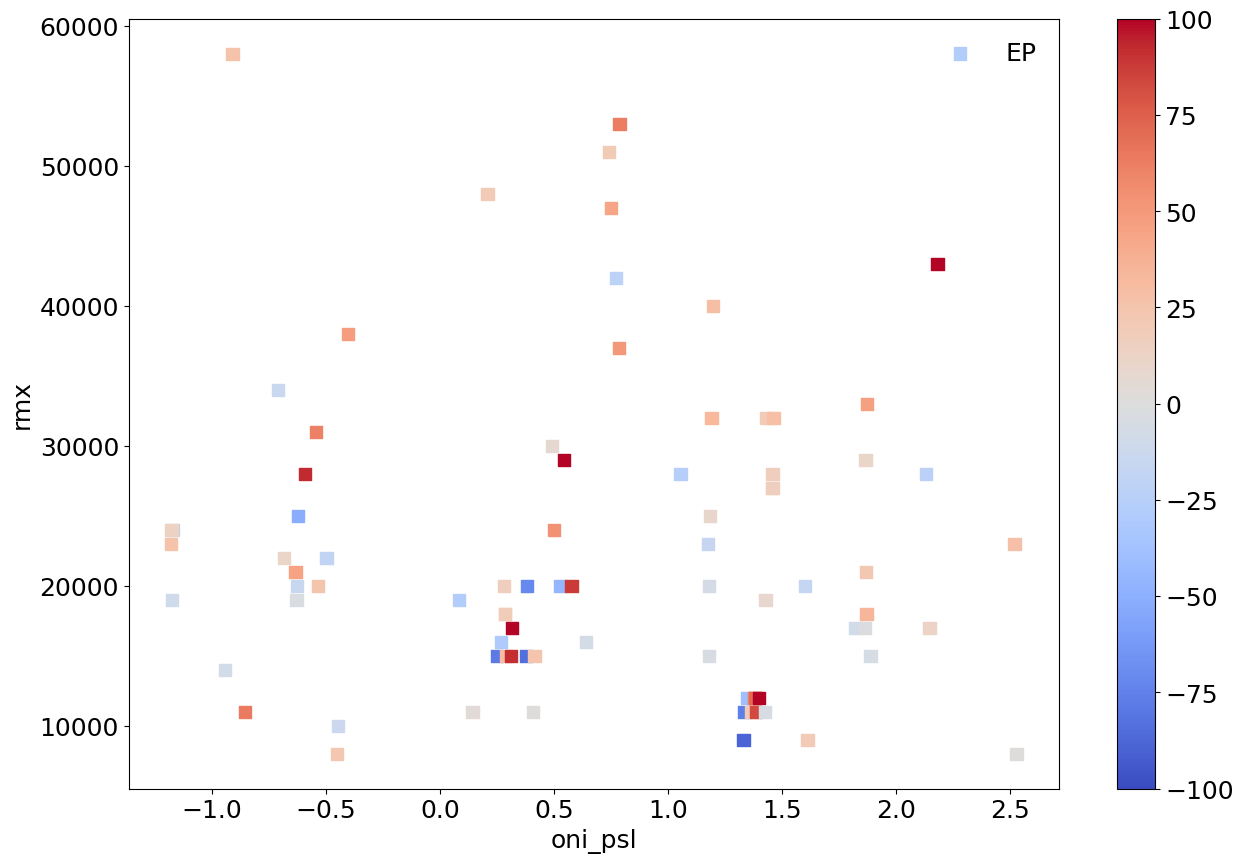

In [72]:
x = 'oni_psl'

for prm in ['sst_pmd', 'beta0', 'beta0_T0', 'vmx', 'B_hol', 'rsby', 'rmx']:
    plt.scatter(de[x], de[prm], c=de.t_since_lmi_ibt / 3600, marker='s', s=80, label='EP', cmap=cm.get_cmap('coolwarm'), vmin=-100, vmax=100)
    plt.colorbar()
    plt.legend(frameon=False)
    plt.xlabel(x)
    plt.ylabel(prm)
    plt.show()

(array([ 3.,  4., 13., 19., 31., 17., 10.,  5.,  5.,  1.]),
 array([-104.11500001,  -81.06805557,  -58.02111112,  -34.97416668,
         -11.92722223,   11.11972221,   34.16666666,   57.2136111 ,
          80.26055554,  103.30749999,  126.35444443]),
 <BarContainer object of 10 artists>)

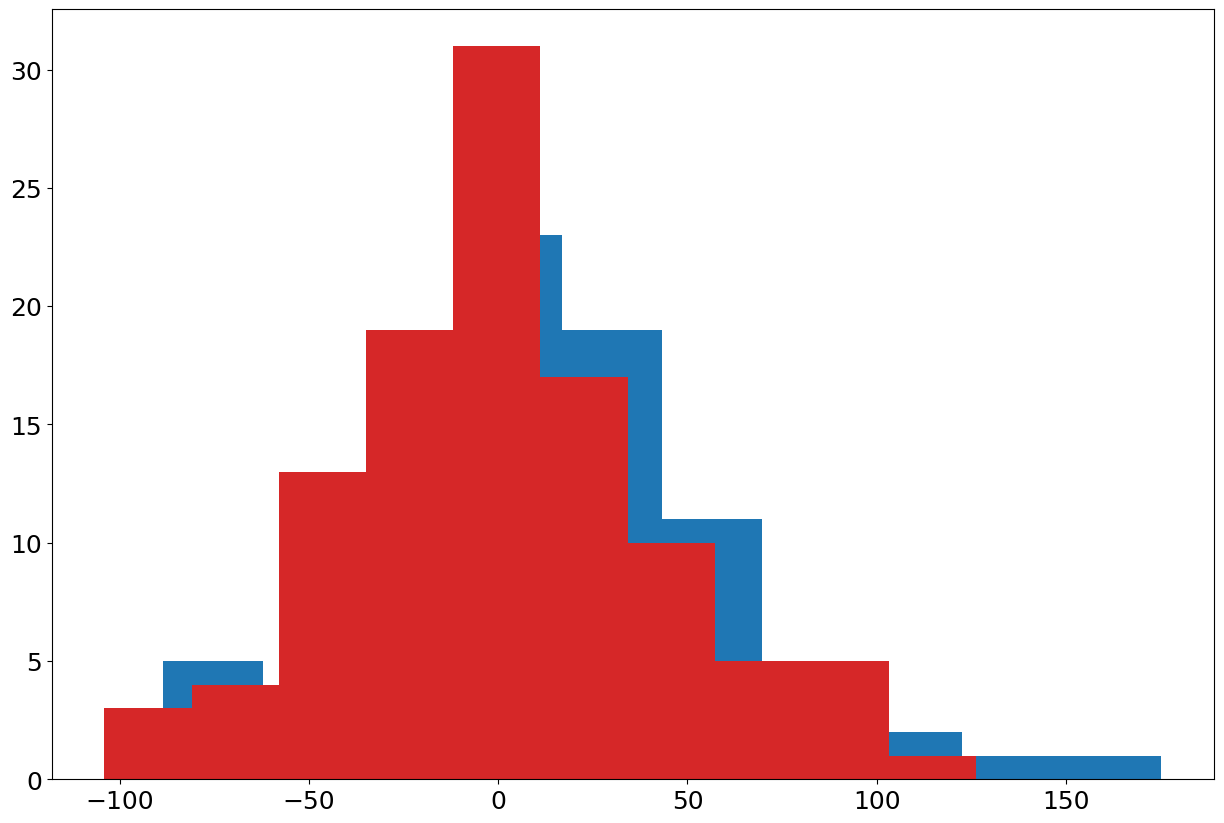

In [73]:
plt.hist(d.where(d.basin == 'ep', drop=True).t_since_lmi_ibt / 3600)
plt.hist(d.where(d.basin == 'wp', drop=True).t_since_lmi_ibt / 3600, color='tab:red')